In [1]:
cd ..

g:\OneDrive\Projects\federated_imputation_pc2


In [2]:
import pandas as pd
from src.modules.data_prep_utils import normalization, move_target_to_end
#from dython.nominal import correlation_ratio
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, recall_score, precision_score, roc_auc_score, average_precision_score
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
import numpy as np
from collections import OrderedDict
import json

## Classification Data

In [3]:
def convert_gaussian(data, target_col):
    for col in data.columns:
        if col != target_col:
            pt = PowerTransformer()
            data[col] = pt.fit_transform(data[col].values.reshape(-1, 1)).flatten()
    return data

In [4]:
def run_regression(data, target_col):

    X_train, X_test, y_train, y_test = train_test_split(data.drop(target_col, axis=1), data[target_col], test_size=0.2, random_state=42)
    print("X_train: {}".format(X_train.shape))
    clf = MLPRegressor(hidden_layer_sizes = [64, 64], random_state=42, max_iter=5000).fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("RMSE: {}".format(rmse))
    print("R2: {}".format(r2))

    return y_pred, y_test

In [5]:
def run_classification(data, target_col, smote = None):

    X_train, X_test, y_train, y_test = train_test_split(data.drop(target_col, axis=1), data[target_col], test_size=0.2, random_state=42)

    if smote == 'smote':
        sm = SMOTETomek(random_state = 42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    elif smote == 'rus':
        sm = RandomUnderSampler(random_state = 42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    else:
        pass
    
    print('X_train shape: {}'.format(X_train.shape))

    clf = MLPClassifier(
        hidden_layer_sizes = [16], random_state=42, max_iter=5000, alpha = 0.001
    ).fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accu = clf.score(X_test, y_test)
    
    if len(y_test.unique()) == 2:   
        f1 = f1_score(y_test, y_pred)
        print("Accuracy: {}".format(accu))
        print("F1: {}".format(f1))
        print('Recall: {}'.format(recall_score(y_test, y_pred)))
        print('Precision: {}'.format(precision_score(y_test, y_pred)))
        print('ROC: {}'.format(roc_auc_score(y_test, y_pred)))
        print('PRC: {}'.format(average_precision_score(y_test, y_pred)))
    else:
        f1 = f1_score(y_test, y_pred, average = 'macro')
        y_prob = clf.predict_proba(X_test)
        print("Accuracy: {}".format(accu))
        print("F1: {}".format(f1))
        print('ROC: {}'.format(roc_auc_score(y_test, y_prob, multi_class = 'ovr', average = 'macro')))

    # clf = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
    # y_pred = clf.predict(X_test)

    # accu = clf.score(X_test, y_test)
    # f1 = f1_score(y_test, y_pred)
    # print("Accuracy: {}".format(accu))
    # print("F1: {}".format(f1))
    # print('Recall: {}'.format(recall_score(y_test, y_pred)))
    # print('Precision: {}'.format(precision_score(y_test, y_pred)))

In [6]:
def avg_correlation(df):
    avg_correlation_cols = list(OrderedDict(df.corr().abs().mean().sort_values(ascending=False).to_dict()).items())
    features = set(df.columns.tolist()[:-1])
    avg_correlation_cols = [col for col in avg_correlation_cols if col[0] in features]
    return avg_correlation_cols

## Distance Analyzer

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import ot
from ot.sliced import sliced_wasserstein_distance

In [122]:
class DistanceAnalyzer:
    def __init__(
        self, 
        data_list, 
        features_numerical, 
        features_binary,
        distance_method='swd', 
        dim_reduction=None,
        n_components=10,
        n_projections=100,
        random_state=42
    ):
        """
        初始化分析器
        
        Parameters:
        -----------
        distance_method: str
            'swd' (Sliced Wasserstein) 或 'wasserstein'
        dim_reduction: str or None
            'pca', 'tsne', 'umap', 或 None
        n_components: int
            降维后的维度
        n_projections: int
            SWD使用的投影数量
        """
        self.data_list = data_list
        self.features_numerical = features_numerical
        self.features_binary = features_binary
        self.distance_method = distance_method
        self.dim_reduction = dim_reduction
        self.n_components = n_components
        self.n_projections = n_projections
        self.n_hospitals = len(data_list)
        self.random_state = random_state
        
        # 初始化降维模型
        self._init_dim_reduction()
        
    def _init_dim_reduction(self):
        """初始化降维模型"""
        if self.dim_reduction == 'pca':
            self.reducer = PCA(n_components=self.n_components, 
                             random_state=self.random_state)
        elif self.dim_reduction == 'tsne':
            self.reducer = TSNE(n_components=self.n_components, 
                              random_state=self.random_state)
        elif self.dim_reduction is None:
            self.reducer = None
        else:
            raise ValueError(f"Unsupported dimension reduction method: {self.dim_reduction}")
            
    def preprocess_dataset(self, df):
        """预处理单个数据集"""
        X_num = df[self.features_numerical].copy()
        X_bin = df[self.features_binary].copy()
        
        return X_num.values
        
    def reduce_dimensions(self, data):
        """降维处理"""
        if self.reducer is None:
            return data
        
        if self.dim_reduction == 'tsne':
            # t-SNE需要先将所有数据拟合
            return self.reducer.fit_transform(data)
        else:
            # PCA和UMAP可以分别拟合和转换
            if not hasattr(self.reducer, 'components_'):
                self.reducer.fit(data)
            return self.reducer.transform(data)
    
    def compute_distance(self, data1, data2):
        """计算两个数据集之间的距离"""
        if self.distance_method == 'swd':
            return sliced_wasserstein_distance(
                data1, data2,
                n_projections=self.n_projections,
                seed=self.random_state
            )
        elif self.distance_method == 'wasserstein':
            # 计算Wasserstein距离
            a = np.ones(len(data1)) / len(data1)
            b = np.ones(len(data2)) / len(data2)
            M = ot.dist(data1, data2)
            return ot.emd2(a, b, M)
        elif self.distance_method == 'sinkhorn':
            # 计算Sinkhorn距离
            a = np.ones(len(data1)) / len(data1)
            b = np.ones(len(data2)) / len(data2)
            M = ot.dist(data1, data2)
            return ot.sinkhorn2(a, b, M, 0.01)
        elif self.distance_method == 'correlation':
            corr_data1 = np.corrcoef(data1.T)
            corr_data2 = np.corrcoef(data2.T)
            return np.linalg.norm(corr_data1 - corr_data2)
        else:
            raise ValueError(f"Unsupported distance method: {self.distance_method}")
    
    def compute_distance_matrix(self, figsize=(20, 18)):
        # 预处理所有数据
        processed_data = [self.preprocess_dataset(df) for df in self.data_list]
        
        # 合并所有数据用于降维
        all_data = np.vstack(processed_data)
        
        # 降维
        if self.reducer is not None:
            reduced_data = self.reduce_dimensions(all_data)
            # 分割回各医院的数据
            start_idx = 0
            processed_data = []
            for df in self.data_list:
                end_idx = start_idx + len(df)
                processed_data.append(reduced_data[start_idx:end_idx])
                start_idx = end_idx
        
        # 计算距离矩阵
        distance_matrix = np.zeros((self.n_hospitals, self.n_hospitals))
        self.distance_matrix = distance_matrix
        
        for i in range(self.n_hospitals):
            for j in range(i, self.n_hospitals):
                dist = self.compute_distance(processed_data[i], processed_data[j])
                distance_matrix[i][j] = dist
                distance_matrix[j][i] = dist
                
        # 可视化结果
        clients_names = [f"Client_{i}" for i in range(len(self.data_list))]
        
        # 绘制距离矩阵热图
        plt.figure(figsize=figsize)
        sns.heatmap(distance_matrix,
                    annot=True,
                    cmap='YlOrRd',
                    xticklabels=clients_names,
                    yticklabels=clients_names)
        plt.title(f'Distance Matrix ({self.distance_method.upper()})')
        plt.tight_layout()
        plt.show()
                
        return distance_matrix
    
    def clustering(self, n_clusters=None, threshold = 0.15, linkage_method = 'average'):
        
        # 使用层次聚类
        from sklearn.cluster import AgglomerativeClustering
        
        # 执行聚类
        clustering = AgglomerativeClustering(
            n_clusters=None,
            metric='precomputed',
            linkage='average',
            distance_threshold=threshold
        )
        labels = clustering.fit_predict(self.distance_matrix)
        
        # 创建相似组
        # similar_groups = [set() for _ in range(n_clusters)]
        # for i, label in enumerate(labels):
        #     similar_groups[label].add(i)
            
        # 创建层次聚类
        linkage_matrix = linkage(distance_matrix, method='average')
        clients_names = [f"Client_{i}" for i in range(len(self.data_list))]
        
        # 获取聚类标签
        clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
        n_clusters = len(np.unique(clusters))
        
        # 创建颜色映射
        colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
        cluster_colors = {i+1: colors[i] for i in range(n_clusters)}
        
        # 设置每个叶子节点的颜色
        leaf_colors = [cluster_colors[clusters[i]] for i in range(len(clusters))]
        
        # 绘制聚类树状图
        fig, ax = plt.subplots(figsize=(10, 7))
        dendrogram(linkage_matrix, labels=clients_names, ax = ax)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        xlbls = ax.get_xmajorticklabels()
        for lbl, c in zip(xlbls, leaf_colors):
            lbl.set_color(c)    
        ax.set_title('Client Clustering Dendrogram')
        ax.set_xlabel('Clients')
        ax.set_ylabel('Distance')
        plt.legend(title='Cluster', loc='upper right', labels=[f'Cluster {i+1}' for i in range(n_clusters)])
        plt.tight_layout()
        plt.show()
        
        # Clustering Results
        print(f"\nClustering Results ({n_clusters} clusters):")
        for i in range(1, n_clusters + 1):
            cluster_members = [clients_names[j] for j in range(len(clusters)) if clusters[j] == i]
            print(f"\nCluster {i} ({len(cluster_members)} members):")
            print(", ".join(cluster_members))
            
            # 计算该簇内的平均距离
            if len(cluster_members) > 1:
                cluster_indices = [j for j in range(len(clusters)) if clusters[j] == i]
                distances = []
                for idx1 in cluster_indices:
                    for idx2 in cluster_indices:
                        if idx1 < idx2:
                            distances.append(distance_matrix[idx1][idx2])
                avg_distance = np.mean(distances)
                print(f"Average internal distance: {avg_distance:.3f}")
        
        return {
            #'similar_groups': similar_groups,
            'linkage_matrix': linkage_matrix,
            'labels': labels,
            'n_clusters': n_clusters
        }

## HHP

In [13]:
############################################################################################################
# Load data
# members
df_members = pd.read_csv('./data/hhp/raw/Members.csv')
df_members['Sex'] = df_members['Sex'].map({'M': 1, 'F': 0})
df_members['AgeAtFirstClaim'] = df_members['AgeAtFirstClaim'].map({
    '0-9': 5,
    '10-19': 15,
    '20-29': 25,
    '30-39': 35,
    '40-49': 45,
    '50-59': 55,
    '60-69': 65,
    '70-79': 75,
    '80+': 90
})

# drug and lab
df_drug = pd.read_csv('./data/hhp/raw/DrugCount.csv')
df_drug['DrugCount'] = df_drug['DrugCount'].map({'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7+': 10})
df_lab = pd.read_csv('./data/hhp/raw/LabCount.csv')
df_lab['LabCount'] = df_lab['LabCount'].map(
    {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10+': 12}
)

# days
df_days_y2 = pd.read_csv('./data/hhp/raw/DaysInHospital_Y2.csv')
df_days_y2['Year'] = 'Y1'
df_days_y3 = pd.read_csv('./data/hhp/raw/DaysInHospital_Y3.csv')
df_days_y3['Year'] = 'Y2'

df_days = pd.concat([df_days_y2, df_days_y3])

df_claims = pd.read_csv('./data/hhp/raw/Claims.csv')

# divide by provider
# providers = df_claims['ProviderID'].value_counts().iloc[: 10].index.tolist()
# df_claims = df_claims[df_claims['ProviderID'].isin(providers)]
# print(df_claims.shape)

df_claims = pd.merge(df_claims, df_members, on='MemberID', how='left')
df_claims = pd.merge(df_claims, df_drug, on=['MemberID', 'Year', 'DSFS'], how='left')
df_claims = pd.merge(df_claims, df_lab, on=['MemberID', 'Year', 'DSFS'], how='left')
df_claims = pd.merge(df_claims, df_days, on=['MemberID', 'Year'], how='left')
df_claims = df_claims[df_claims['DaysInHospital'].notna()]
print(df_claims.shape)

#################################################################################################################
# Feature engineering
# drop missing age and sex
df_claims = df_claims[df_claims['AgeAtFirstClaim'].notna()].copy()
df_claims = df_claims[df_claims['Sex'].notna()].copy()
df_claims = df_claims[df_claims['DSFS'].notna()].copy()

# transform categorical columns
def transform1(row):
    if pd.isna(row):
        return 'None'
    else:
        return str(int(row))
    
df_claims['ProviderID'] = df_claims['ProviderID'].map(transform1)
df_claims['Vendor'] = df_claims['Vendor'].map(transform1)
df_claims['PCP'] = df_claims['PCP'].map(transform1)

# handle missing values for categorical columns
df_claims['ProcedureGroup'] = df_claims['ProcedureGroup'].fillna('None', inplace=False)
df_claims['Specialty'] = df_claims['Specialty'].fillna('None', inplace=False)
df_claims['PrimaryConditionGroup'] = df_claims['PrimaryConditionGroup'].fillna('None', inplace=False)
df_claims['PlaceSvc'] = df_claims['PlaceSvc'].fillna('None', inplace=False)

# encode number of columns
df_claims['CharlsonIndex'] = df_claims['CharlsonIndex'].map({'0': 0, '1-2': 1.5, '3-4': 3.5, '5+': 7})
df_claims['PayDelay'] = df_claims['PayDelay'].apply(lambda row: int(row) if row != '162+' else 200)
df_claims['LengthOfStay'] = df_claims['LengthOfStay'].map({
    '1 day': 1, '2 days': 2, '3 days': 3, '4 days': 4, '5 days': 5, '6 days': 6, '1- 2 weeks': 10, '2- 4 weeks': 21, '4- 8 weeks': 42,
})
df_claims['DSFS'] = df_claims['DSFS'].map({
    '0- 1 month': 1, '1- 2 months': 2, '2- 3 months': 3, '3- 4 months': 4, '4- 5 months': 5, '5- 6 months': 6, 
    '6- 7 months': 7, '7- 8 months': 8, '8- 9 months': 9, '9-10 months': 10, '10-11 months': 11, '11-12 months': 12
})

# filter all large claims
df_claims = df_claims[df_claims['DaysInHospital'] > 0].copy()
print(df_claims.shape)

# fill mean values for drug and lab counts
df_claims['DrugCount'] = df_claims['DrugCount'].fillna(df_claims['DrugCount'].mean(), inplace=False)
df_claims['LabCount'] = df_claims['LabCount'].fillna(df_claims['LabCount'].mean(), inplace=False)

# drop length of stay
df_claims = df_claims.drop(columns=['LengthOfStay'])

#########################################################################################################################
# Feature selection
# numerical features
def feature_agg(df, key):
    ret = df.groupby(['MemberID', 'Year']).agg(
        **{
            key+'_mean': pd.NamedAgg(column=key, aggfunc='mean'),
            key+'_std': pd.NamedAgg(column=key, aggfunc='std'),
            key+'_max': pd.NamedAgg(column=key, aggfunc='max'),
            key+'_min': pd.NamedAgg(column=key, aggfunc='min'),
        }
    )

    ret[f'{key}_range'] = ret[f'{key}_max'] - ret[f'{key}_min']
    ret = ret.reset_index()
    ret = ret.drop(columns=[f'{key}_min'])
    
    df = pd.merge(df, ret, on=['MemberID', 'Year'], how='left')
    df = df.drop(columns=[key])
    
    return df

df_claims = feature_agg(df_claims, 'DSFS')
df_claims = feature_agg(df_claims, 'PayDelay')
df_claims = feature_agg(df_claims, 'CharlsonIndex')
df_claims = feature_agg(df_claims, 'DrugCount')
df_claims = feature_agg(df_claims, 'LabCount')

def feature_agg2(df, key):
    df = df.groupby(['MemberID', 'Year']).agg(key).nunique().reset_index(name = key+'_counts')
    df = pd.merge(df_claims, df, on = ['MemberID', 'Year'], how = 'left')
    return df

df_claims = feature_agg2(df_claims, 'ProviderID')
df_claims = feature_agg2(df_claims, 'Vendor')
df_claims = feature_agg2(df_claims, 'PCP')
df_claims = feature_agg2(df_claims, 'Specialty')
df_claims = feature_agg2(df_claims, 'PlaceSvc')
df_claims = feature_agg2(df_claims, 'PrimaryConditionGroup')
df_claims = feature_agg2(df_claims, 'ProcedureGroup')
ret = df_claims.groupby(['MemberID', 'Year']).size().reset_index(name = 'claim_counts')
df_claims = pd.merge(df_claims, ret, on = ['MemberID', 'Year'], how = 'left')

df_claims.fillna(0, inplace=True)

# categoorical one-hot features
top_k = 2
for col in ['Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup']:
    top_k_cols = pd.get_dummies(df_claims[col]).corrwith(df_claims['DaysInHospital']).abs().sort_values(ascending = False)[:top_k]
    dummies = pd.get_dummies(df_claims[col])[top_k_cols.index]
    dummies.columns = [f'{col}_{idx}' for idx in range(len(dummies.columns))]
    df_claims = pd.concat([df_claims, dummies], axis = 1)
    df_claims.drop(columns = [col], inplace = True)
    
df_claims = df_claims.drop(columns = ['MemberID', 'ProviderID', 'Vendor', 'PCP', 'Year'])

#########################################################################################################################
# Split data
# columns
num_cols = ['AgeAtFirstClaim']
for col in ['CharlsonIndex', 'PayDelay', 'DrugCount', 'LabCount', 'DSFS']:
    num_cols += [f'{col}_mean', f'{col}_std', f'{col}_max', f'{col}_range']
for col in ['ProviderID', 'Vendor', 'PCP', 'Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup', 'claim']:
    num_cols += [f'{col}_counts']
print(len(num_cols))

cat_cols = ['Sex', 'SupLOS', 'ClaimsTruncated']
cat_cols += [f'{col}_{idx}' for col in ['Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup'] for idx in range(top_k)]
print(len(cat_cols))

target = 'DaysInHospital'

# sample data
df_claims_sample = df_claims.sample(n = 20000, random_state=42)

# standardize
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
df_claims_sample[num_cols] = scaler.fit_transform(df_claims_sample[num_cols])
scaler = MinMaxScaler()
df_claims_sample[num_cols] = scaler.fit_transform(df_claims_sample[num_cols])

# reorder target to be num cols, cat cols and target
df_claims_sample = df_claims_sample[num_cols + cat_cols + [target]]

print(df_claims_sample.shape)

data = df_claims_sample

avg_correlation_cols = avg_correlation(data)
avg_correlation_cols = [col[0] for col in avg_correlation_cols if col[0] in num_cols]
avg_correlation_cols = [col for col in avg_correlation_cols][:int(data.shape[1]*0.3)]

# data config
data_config = {
    'target': target,
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target],
    'split_col_idx': [data.columns.tolist().index(col) for col in avg_correlation_cols],
    'ms_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in num_cols],
    'obs_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in cat_cols],
    "num_cols": len(num_cols),
    'task_type': 'regression',
    'clf_type': 'none',
    'data_type': 'tabular'
}

(1764556, 20)
(207078, 20)
29
11
(20000, 41)


In [105]:

############################################################################################################
# Load data
df_members = pd.read_csv('./data/hhp/raw/Members.csv')
df_drug = pd.read_csv('./data/hhp/raw/DrugCount.csv')
df_lab = pd.read_csv('./data/hhp/raw/LabCount.csv')
df_claims = pd.read_csv('./data/hhp/raw/Claims.csv')
df_days_y2 = pd.read_csv('./data/hhp/raw/DaysInHospital_Y2.csv')
df_days_y3 = pd.read_csv('./data/hhp/raw/DaysInHospital_Y3.csv')

# members
df_members['Sex'] = df_members['Sex'].map({'M': 1, 'F': 0})
df_members['AgeAtFirstClaim'] = df_members['AgeAtFirstClaim'].map({
    '0-9': 5,
    '10-19': 15,
    '20-29': 25,
    '30-39': 35,
    '40-49': 45,
    '50-59': 55,
    '60-69': 65,
    '70-79': 75,
    '80+': 90
})

# drug and lab
df_drug['DrugCount'] = df_drug['DrugCount'].map({'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7+': 10})
df_lab['LabCount'] = df_lab['LabCount'].map(
    {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10+': 12}
)

# days
df_days_y2['Year'] = 'Y1'
df_days_y3['Year'] = 'Y2'
df_days = pd.concat([df_days_y2, df_days_y3])

# merge data
df_claims = pd.merge(df_claims, df_members, on='MemberID', how='left')
df_claims = pd.merge(df_claims, df_drug, on=['MemberID', 'Year', 'DSFS'], how='left')
df_claims = pd.merge(df_claims, df_lab, on=['MemberID', 'Year', 'DSFS'], how='left')
df_claims = pd.merge(df_claims, df_days, on=['MemberID', 'Year'], how='left')
df_claims = df_claims[df_claims['DaysInHospital'].notna()]
print(df_claims.shape)

#################################################################################################################
# Data Preprocessing
# drop missing age and sex
df_claims = df_claims[df_claims['AgeAtFirstClaim'].notna()].copy()
df_claims = df_claims[df_claims['Sex'].notna()].copy()
df_claims = df_claims[df_claims['DSFS'].notna()].copy()

# transform categorical columns
def transform1(row):
    if pd.isna(row):
        return 'None'
    else:
        return str(int(row))
    
df_claims['ProviderID'] = df_claims['ProviderID'].map(transform1)
df_claims['Vendor'] = df_claims['Vendor'].map(transform1)
df_claims['PCP'] = df_claims['PCP'].map(transform1)

print(df_claims.isna().sum())

# handle missing values for categorical columns
df_claims['ProcedureGroup'] = df_claims['ProcedureGroup'].fillna('None', inplace=False)
df_claims['Specialty'] = df_claims['Specialty'].fillna('None', inplace=False)
df_claims['PrimaryConditionGroup'] = df_claims['PrimaryConditionGroup'].fillna('None', inplace=False)
df_claims['PlaceSvc'] = df_claims['PlaceSvc'].fillna('None', inplace=False)

# encode number of columns
df_claims['CharlsonIndex'] = df_claims['CharlsonIndex'].map({'0': 0, '1-2': 1.5, '3-4': 3.5, '5+': 7})
df_claims['PayDelay'] = df_claims['PayDelay'].apply(lambda row: int(row) if row != '162+' else 200)
df_claims['LengthOfStay'] = df_claims['LengthOfStay'].map({
    '1 day': 1, '2 days': 2, '3 days': 3, '4 days': 4, '5 days': 5, '6 days': 6, '1- 2 weeks': 10, '2- 4 weeks': 21, '4- 8 weeks': 42,
})
df_claims['DSFS'] = df_claims['DSFS'].map({
    '0- 1 month': 1, '1- 2 months': 2, '2- 3 months': 3, '3- 4 months': 4, '4- 5 months': 5, '5- 6 months': 6, 
    '6- 7 months': 7, '7- 8 months': 8, '8- 9 months': 9, '9-10 months': 10, '10-11 months': 11, '11-12 months': 12
})

# fill mean values for drug and lab counts
#df_claims['DrugCount'] = df_claims['DrugCount'].fillna(df_claims['DrugCount'].mean(), inplace=False)
#df_claims['LabCount'] = df_claims['LabCount'].fillna(df_claims['LabCount'].mean(), inplace=False)
# drop length of stay
df_claims = df_claims.drop(columns=['LengthOfStay'])

# drop na in drug and lab counts
df_claims = df_claims.dropna(inplace=False)

#########################################################################################################################
# Feature Engineering
# numerical features
def feature_agg(df, key):
    ret = df.groupby(['MemberID', 'Year']).agg(
        **{
            key+'_mean': pd.NamedAgg(column=key, aggfunc='mean'),
            key+'_std': pd.NamedAgg(column=key, aggfunc='std'),
            key+'_max': pd.NamedAgg(column=key, aggfunc='max'),
            key+'_min': pd.NamedAgg(column=key, aggfunc='min'),
        }
    )

    ret[f'{key}_range'] = ret[f'{key}_max'] - ret[f'{key}_min']
    ret = ret.reset_index()
    ret = ret.drop(columns=[f'{key}_min'])
    
    df = pd.merge(df, ret, on=['MemberID', 'Year'], how='left')
    df = df.drop(columns=[key])
    
    return df

df_claims = feature_agg(df_claims, 'DSFS')
df_claims = feature_agg(df_claims, 'PayDelay')
df_claims = feature_agg(df_claims, 'CharlsonIndex')
df_claims = feature_agg(df_claims, 'DrugCount')
df_claims = feature_agg(df_claims, 'LabCount')

def feature_agg2(df, key):
    df = df.groupby(['MemberID', 'Year']).agg(key).nunique().reset_index(name = key+'_counts')
    df = pd.merge(df_claims, df, on = ['MemberID', 'Year'], how = 'left')
    return df

df_claims = feature_agg2(df_claims, 'ProviderID')
df_claims = feature_agg2(df_claims, 'Vendor')
df_claims = feature_agg2(df_claims, 'PCP')
df_claims = feature_agg2(df_claims, 'Specialty')
df_claims = feature_agg2(df_claims, 'PlaceSvc')
df_claims = feature_agg2(df_claims, 'PrimaryConditionGroup')
df_claims = feature_agg2(df_claims, 'ProcedureGroup')
ret = df_claims.groupby(['MemberID', 'Year']).size().reset_index(name = 'claim_counts')
df_claims = pd.merge(df_claims, ret, on = ['MemberID', 'Year'], how = 'left')

df_claims.fillna(0, inplace=True)
print(df_claims.shape)

(1764556, 20)
MemberID                       0
ProviderID                     0
Vendor                         0
PCP                            0
Year                           0
Specialty                   1155
PlaceSvc                     808
PayDelay                       0
LengthOfStay             1152858
DSFS                           0
PrimaryConditionGroup       1536
CharlsonIndex                  0
ProcedureGroup               571
SupLOS                         0
AgeAtFirstClaim                0
Sex                            0
DrugCount                 458700
LabCount                  487392
ClaimsTruncated                0
DaysInHospital                 0
dtype: int64
(437913, 42)


### Task1 LOS prediction

In [8]:
# task1 - prediction of days in hospital
df = df_claims.copy()
use_categorical = False
selected_providers = 10
corr_thres = 0.02
sample_pct = 0.4
split_col = ['ProviderID']


# transformation of target
df['DaysInHospital'] = df['DaysInHospital'].apply(lambda x: np.log(x+1))

# categoorical one-hot features and feature selection
if use_categorical:
    print(df['PrimaryConditionGroup'].value_counts().shape)
    print(df['PlaceSvc'].value_counts().shape)
    print(df['ProcedureGroup'].value_counts().shape)
    print(df['Vendor'].value_counts().shape)
    print(df['PCP'].value_counts().shape)
    print(df['Specialty'].value_counts().shape)

    for col in ['Specialty', 'ProcedureGroup', 'PrimaryConditionGroup', 'PlaceSvc']:
        corr = pd.get_dummies(
            df[col]).corrwith(df['DaysInHospital']).abs().sort_values(ascending = False
        )
        
        corr_cols = corr[corr >= corr_thres].index.tolist()
        dummies = pd.get_dummies(df[col])[corr_cols]
        dummies.columns = [f'{col}_{idx}' for idx in range(len(dummies.columns))]
        df = pd.concat([df, dummies], axis = 1)
        df.drop(columns = [col], inplace = True)
else:
    print('No categorical features used.')
    
# drop unnecessary columns
for col in [
    'Specialty', 'ProcedureGroup', 'PrimaryConditionGroup', 'PlaceSvc', 
    'MemberID', 'Vendor', 'PCP', 'Year'
]:
    if col in df_claims.columns:
        df = df.drop(columns = [col])
print(df.shape)

# feature transformation
num_cols = ['AgeAtFirstClaim']
for col in ['CharlsonIndex', 'PayDelay', 'DrugCount', 'LabCount', 'DSFS']:
    num_cols += [f'{col}_mean', f'{col}_std', f'{col}_max', f'{col}_range']
for col in ['ProviderID', 'Vendor', 'PCP', 'Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup', 'claim']:
    num_cols += [f'{col}_counts']
print('num_cols: ', len(num_cols))

cat_cols = ['Sex', 'SupLOS', 'ClaimsTruncated']
if use_categorical:
    cat_cols += [f'{col}_{idx}' for col in ['PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup'] for idx in range(top_k)]
print('cat_cols: ', len(cat_cols))

target = 'DaysInHospital'

# standardize
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# reorder target to be num cols, cat cols and target
df = df[split_col + num_cols + cat_cols + [target]]

No categorical features used.
(437913, 34)
num_cols:  29
cat_cols:  3


In [9]:
# split and sampling
sample_pct = 0.4
provider_counts = df[split_col[0]].value_counts()
provider_selected = provider_counts.index[0:selected_providers]
print(provider_selected)
df = df[df[split_col[0]].isin(provider_selected)]
print(df.shape)
df_sample = df.sample(frac=sample_pct, random_state=42)
print(df_sample.shape)
print(df_sample[split_col[0]].value_counts())

# split indices
df_rets = [df_sub for _, df_sub in df_sample.groupby(split_col[0])]
print([df_sub.shape for df_sub in df_rets])

df_rets = [df_sub.reset_index(drop = True) for df_sub in df_rets]
split_indices = np.cumsum([df_sub.shape[0] for df_sub in df_rets[:-1]])
print(split_indices)

data = pd.concat(df_rets, axis = 0)
data = data.drop(columns = split_col)
print(data.shape)
data

Index(['7053364', '1076052', '4107701', '321261', '9585773', '8889271',
       '9860028', '6164824', '6673983', '5145548'],
      dtype='object', name='ProviderID')
(219865, 34)
(87946, 34)
ProviderID
7053364    37470
1076052    18336
4107701    14165
321261      9262
8889271     1913
9585773     1877
9860028     1509
6164824     1216
6673983     1183
5145548     1015
Name: count, dtype: int64
[(18336, 34), (9262, 34), (14165, 34), (1015, 34), (1216, 34), (1183, 34), (37470, 34), (1913, 34), (1877, 34), (1509, 34)]
[18336 27598 41763 42778 43994 45177 82647 84560 86437]
(87946, 33)


,AgeAtFirstClaim,CharlsonIndex_mean,CharlsonIndex_std,CharlsonIndex_max,CharlsonIndex_range,PayDelay_mean,PayDelay_std,PayDelay_max,PayDelay_range,DrugCount_mean,...,PCP_counts,Specialty_counts,PlaceSvc_counts,PrimaryConditionGroup_counts,ProcedureGroup_counts,claim_counts,Sex,SupLOS,ClaimsTruncated,DaysInHospital
0,0.588235,0.000000,0.000000,0.000000,0.000000,0.235000,0.012561,0.245,0.015,0.000000,...,0.0,0.111111,0.166667,0.066667,0.2,0.047619,1.0,0,0.0,0.000000
1,0.823529,0.000000,0.000000,0.000000,0.000000,0.299444,0.083595,0.400,0.135,0.000000,...,0.0,0.111111,0.166667,0.000000,0.2,0.190476,1.0,0,0.0,0.000000
2,0.588235,0.214286,0.000000,0.214286,0.000000,0.322500,0.213839,0.565,0.420,0.555556,...,0.0,0.222222,0.166667,0.066667,0.3,0.214286,0.0,0,0.0,0.000000
3,0.823529,0.214286,0.000000,0.214286,0.000000,0.409687,0.242645,0.665,0.455,0.340278,...,0.0,0.222222,0.166667,0.266667,0.3,0.357143,0.0,0,0.0,0.000000
4,0.588235,0.000000,0.000000,0.000000,0.000000,0.269000,0.012973,0.285,0.020,0.333333,...,0.0,0.111111,0.166667,0.000000,0.3,0.095238,1.0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,0.705882,0.214286,0.000000,0.214286,0.000000,0.215857,0.106885,0.450,0.360,0.438095,...,0.0,0.555556,0.666667,0.400000,0.5,0.809524,0.0,0,1.0,0.000000
1505,0.117647,0.000000,0.000000,0.000000,0.000000,0.594000,0.556815,1.000,0.840,0.000000,...,0.0,0.111111,0.166667,0.066667,0.1,0.095238,0.0,0,0.0,0.000000
1506,0.823529,0.214286,0.000000,0.214286,0.000000,0.360588,0.283407,1.000,0.890,1.000000,...,0.0,0.444444,0.666667,0.466667,0.5,0.785714,0.0,0,0.0,2.772589
1507,0.823529,0.045918,0.166592,0.214286,0.214286,0.271786,0.317995,1.000,0.890,0.253968,...,0.0,0.333333,0.333333,0.266667,0.4,0.309524,1.0,0,0.0,0.000000


In [134]:
avg_correlation_cols = avg_correlation(df)
avg_correlation_cols = [col[0] for col in avg_correlation_cols if col[0] in num_cols]
avg_correlation_cols = [col for col in avg_correlation_cols][:int(df.shape[1]*0.3)]

# data config
data_config = {
    'target': target,
    'important_features_idx': [
        idx for idx in range(0, data.shape[1]) 
        if (data.columns[idx] != target) and (data.columns[idx] not in cat_cols)
    ],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target],
	"num_cols": data.shape[1] - 1 - len(cat_cols),
	'task_type': 'regression',
	'clf_type': 'none',
	'data_type': 'tabular',
	'client_split_indices': split_indices.tolist()
}

# data config new1 - predict days in hospital - without categorical features, top10 clients, 40% iid sampling 
with open('./data/hhp/data_config_los_np1.json', 'w') as f:
    json.dump(data_config, f)
    
data.to_csv('./data/hhp/data_clean_los_np1.csv', index=False)

In [14]:
from src.modules.evaluation.imputation_quality import sliced_ws
from matplotlib import pyplot as plt
import seaborn as sns

In [17]:
datas = np.array_split(data.values, split_indices)

# compute pairwise sliced ws
pairwise_sliced_ws = np.zeros((len(datas), len(datas)))
for i in range(len(datas)):
    for j in range(i+1, len(datas)):
        pairwise_sliced_ws[i, j] = sliced_ws(datas[i][:, :-1], datas[j][:, :-1])
        pairwise_sliced_ws[j, i] = pairwise_sliced_ws[i, j]
        print(i, j , pairwise_sliced_ws[i, j])

0 1 0.05806824143071585
0 2 0.06004015929228722
0 3 0.10204021062166953
0 4 0.06063676177386109
0 5 0.06507574656411523
0 6 0.0550224023914625
0 7 0.05038742310244897
0 8 0.07191630215869806
0 9 0.08936873270651244
1 2 0.10676923328758496
1 3 0.13988375005891857
1 4 0.10761103142469912
1 5 0.11020017336699103
1 6 0.08054542062514038
1 7 0.09203220163429596
1 8 0.1146595465236286
1 9 0.07082816179506983
2 3 0.06643333165326457
2 4 0.042501850881507076
2 5 0.042525345379567724
2 6 0.0610561284458187
2 7 0.06099333030389912
2 8 0.05170662325222526
2 9 0.13996187237690744
3 4 0.09246434033711107
3 5 0.08474960539624828
3 6 0.081178077054062
3 7 0.09085385242362756
3 8 0.0880843136251239
3 9 0.17217526488628213
4 5 0.027476492140061322
4 6 0.08650155527907287
4 7 0.04981900479258041
4 8 0.03405210053635231
4 9 0.12583465044343384
5 6 0.08734857663596998
5 7 0.04411783261430465
5 8 0.023032373411272216
5 9 0.1321731485447055
6 7 0.08395728319450022
6 8 0.0954000053227387
6 9 0.12769025844866

<Axes: >

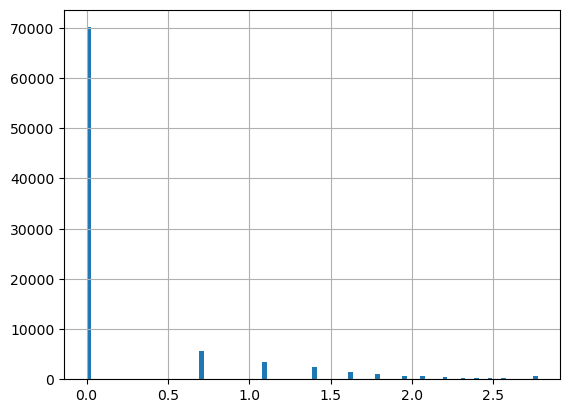

In [22]:
data[target].hist(bins = 100)


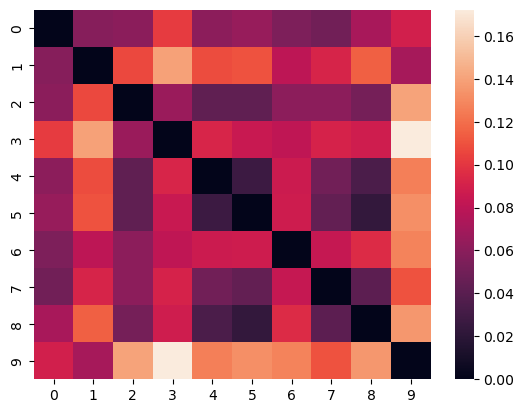

In [ ]:
sns.heatmap(pairwise_sliced_ws)
plt.show()

### Task2 Truncated Claim prediction

In [161]:
# task1 - prediction truncated claims
df = df_claims.copy()
use_categorical = False
selected_providers = 10
corr_thres = 0.02
sample_pct = 0.4
split_col = ['ProviderID']


# transformation of target
df['DaysInHospital'] = df['DaysInHospital'].apply(lambda x: np.log(x+1))

# categoorical one-hot features and feature selection
if use_categorical:
    print(df['PrimaryConditionGroup'].value_counts().shape)
    print(df['PlaceSvc'].value_counts().shape)
    print(df['ProcedureGroup'].value_counts().shape)
    print(df['Vendor'].value_counts().shape)
    print(df['PCP'].value_counts().shape)
    print(df['Specialty'].value_counts().shape)

    for col in ['Specialty', 'ProcedureGroup', 'PrimaryConditionGroup', 'PlaceSvc']:
        corr = pd.get_dummies(
            df[col]).corrwith(df['DaysInHospital']).abs().sort_values(ascending = False
        )
        
        corr_cols = corr[corr >= corr_thres].index.tolist()
        dummies = pd.get_dummies(df[col])[corr_cols]
        dummies.columns = [f'{col}_{idx}' for idx in range(len(dummies.columns))]
        df = pd.concat([df, dummies], axis = 1)
        df.drop(columns = [col], inplace = True)
else:
    print('No categorical features used.')
    
# drop unnecessary columns
for col in [
    'Specialty', 'ProcedureGroup', 'PrimaryConditionGroup', 'PlaceSvc', 
    'MemberID', 'Vendor', 'PCP', 'Year'
]:
    if col in df_claims.columns:
        df = df.drop(columns = [col])
print(df.shape)

# feature transformation
num_cols = ['AgeAtFirstClaim', 'DaysInHospital']
for col in ['CharlsonIndex', 'PayDelay', 'DrugCount', 'LabCount', 'DSFS']:
    num_cols += [f'{col}_mean', f'{col}_std', f'{col}_max', f'{col}_range']
for col in ['ProviderID', 'Vendor', 'PCP', 'Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup', 'claim']:
    num_cols += [f'{col}_counts']
print('num_cols: ', len(num_cols))

cat_cols = ['Sex', 'SupLOS']
if use_categorical:
    cat_cols += [f'{col}_{idx}' for col in ['PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup'] for idx in range(top_k)]
print('cat_cols: ', len(cat_cols))

target = 'ClaimsTruncated'

# standardize
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# reorder target to be num cols, cat cols and target
df = df[split_col + num_cols + cat_cols + [target]]

No categorical features used.
(437913, 34)
num_cols:  30
cat_cols:  2


In [162]:
# split and sampling
sample_pct = 0.4
provider_counts = df[split_col[0]].value_counts()
provider_selected = provider_counts.index[0:selected_providers]
print(provider_selected)

# remove provider 3 and 9
#retain_idx = [0, 2, 4, 7, 8]
retain_idx = list(range(provider_selected.shape[0]))
provider_selected = [provider for idx, provider in enumerate(provider_selected) if idx in retain_idx]
print(provider_selected)

print(df.shape)
df_sample = df.sample(frac=sample_pct, random_state=42)
print(df_sample[split_col[0]].value_counts())
print(df_sample.shape)

# split indices
df_sample = df_sample[df_sample[split_col[0]].isin(provider_selected)]
print(df_sample.shape)
df_rets = [df_sub for _, df_sub in df_sample.groupby(split_col[0])]
print([df_sub.shape for df_sub in df_rets])

df_rets = [df_sub.reset_index(drop = True) for df_sub in df_rets]
split_indices = np.cumsum([df_sub.shape[0] for df_sub in df_rets[:-1]])
print(split_indices)

data = pd.concat(df_rets, axis = 0, ignore_index = True)
data = data.drop(columns = split_col)
print(data.shape)
data

Index(['7053364', '1076052', '4107701', '321261', '9585773', '8889271',
       '9860028', '6164824', '6673983', '5145548'],
      dtype='object', name='ProviderID')
['7053364', '1076052', '4107701', '321261', '9585773', '8889271', '9860028', '6164824', '6673983', '5145548']
(437913, 34)
ProviderID
7053364    37268
1076052    18670
4107701    14167
321261      9109
8889271     1899
           ...  
8830038        1
2865214        1
5565469        1
9511704        1
3767726        1
Name: count, Length: 3615, dtype: int64
(175165, 34)
(87956, 34)
[(18670, 34), (9109, 34), (14167, 34), (1016, 34), (1178, 34), (1208, 34), (37268, 34), (1899, 34), (1886, 34), (1555, 34)]
[18670 27779 41946 42962 44140 45348 82616 84515 86401]
(87956, 33)


,AgeAtFirstClaim,DaysInHospital,CharlsonIndex_mean,CharlsonIndex_std,CharlsonIndex_max,CharlsonIndex_range,PayDelay_mean,PayDelay_std,PayDelay_max,PayDelay_range,...,Vendor_counts,PCP_counts,Specialty_counts,PlaceSvc_counts,PrimaryConditionGroup_counts,ProcedureGroup_counts,claim_counts,Sex,SupLOS,ClaimsTruncated
0,0.705882,0.0,0.122449,0.209121,0.214286,0.214286,0.330000,0.217289,0.545,0.340,...,0.111111,0.0,0.222222,0.333333,0.200000,0.2,0.142857,0.0,0,0.0
1,0.823529,0.0,0.214286,0.000000,0.214286,0.000000,0.308276,0.269499,1.000,0.880,...,0.111111,0.0,0.222222,0.166667,0.200000,0.3,0.666667,0.0,0,1.0
2,0.823529,0.0,0.214286,0.000000,0.214286,0.000000,0.550833,0.511741,1.000,0.875,...,0.111111,0.0,0.222222,0.166667,0.133333,0.3,0.119048,0.0,0,0.0
3,0.588235,0.0,0.214286,0.000000,0.214286,0.000000,0.248571,0.135538,0.470,0.365,...,0.166667,0.0,0.222222,0.166667,0.200000,0.3,0.809524,1.0,0,1.0
4,0.823529,0.0,0.000000,0.000000,0.000000,0.000000,0.665000,0.561080,1.000,0.670,...,0.055556,0.0,0.111111,0.166667,0.133333,0.2,0.071429,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87951,0.117647,0.0,0.000000,0.000000,0.000000,0.000000,0.253913,0.269138,1.000,0.845,...,0.222222,0.0,0.444444,0.333333,0.333333,0.3,0.523810,0.0,0,0.0
87952,0.470588,0.0,0.000000,0.000000,0.000000,0.000000,0.228214,0.147141,0.415,0.275,...,0.166667,0.0,0.333333,0.333333,0.066667,0.3,0.309524,0.0,0,0.0
87953,0.352941,0.0,0.142857,0.202031,0.214286,0.214286,0.310833,0.162972,0.455,0.240,...,0.055556,0.0,0.222222,0.333333,0.066667,0.2,0.119048,0.0,0,0.0
87954,0.470588,0.0,0.198980,0.102606,0.214286,0.214286,0.353750,0.184411,0.590,0.475,...,0.222222,0.0,0.555556,0.333333,0.533333,0.4,0.642857,0.0,0,0.0


In [164]:
data_list = [item for item in df_rets]
print(len(data_list))

10


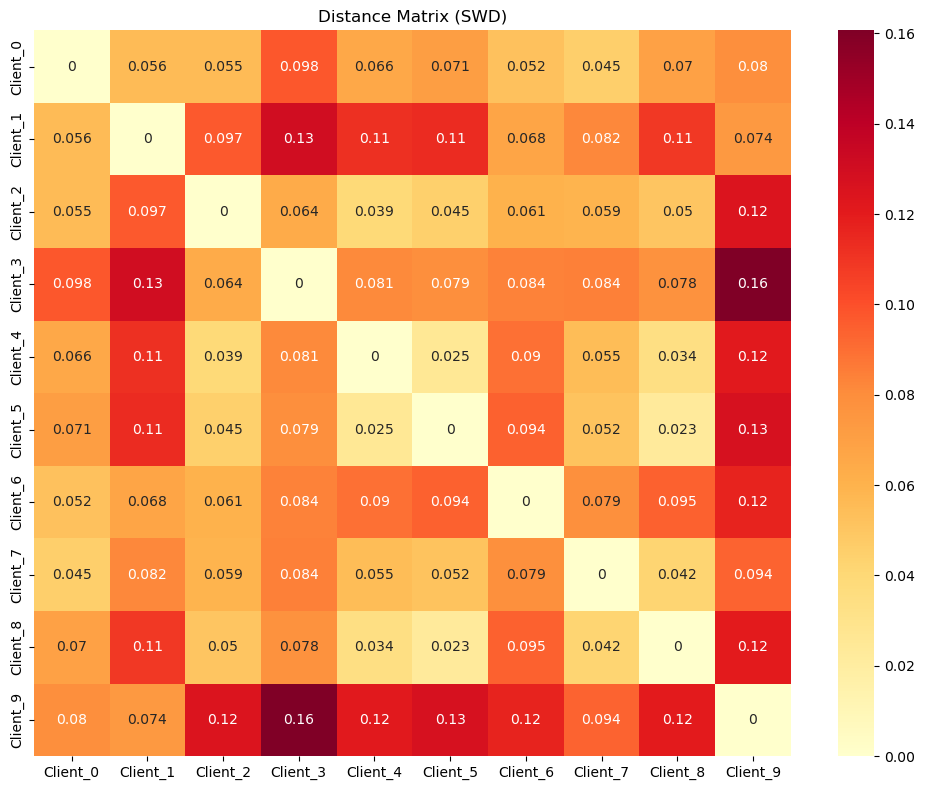

In [165]:
analyzer = DistanceAnalyzer(
        data_list=data_list,
        features_numerical=num_cols,
        features_binary=cat_cols,
        distance_method='swd',
        dim_reduction=None,
        n_components=5,
        n_projections=300
    )
    
# Distance Matrix
distance_matrix = analyzer.compute_distance_matrix(figsize=(10, 8))

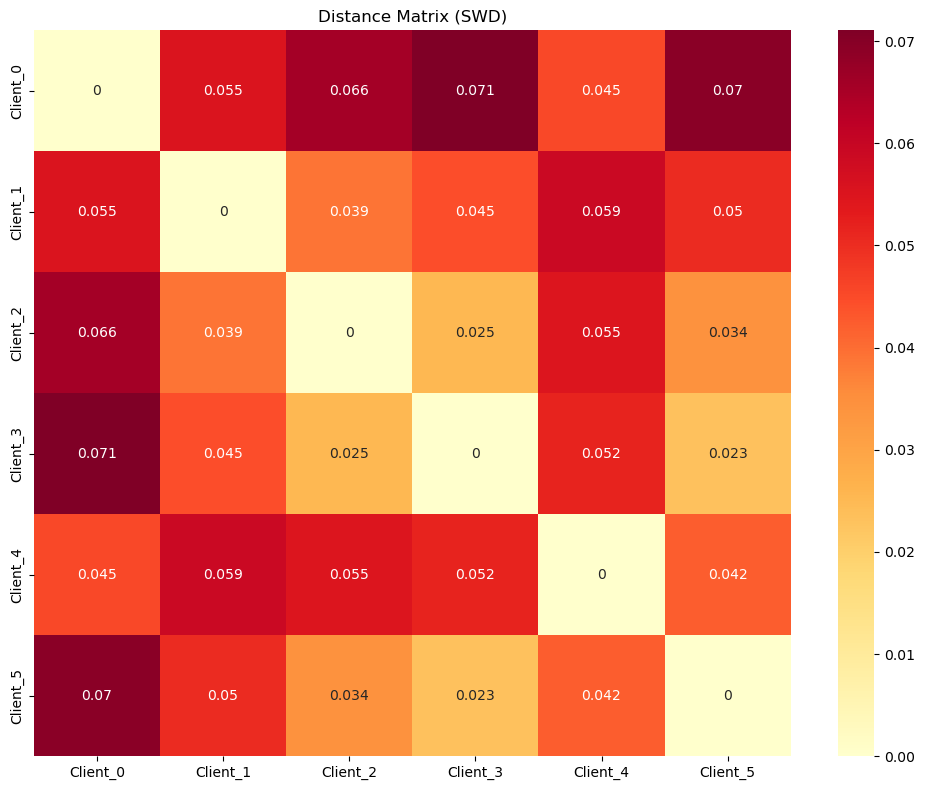

In [160]:
data_list2 = [data_list[0], data_list[2], data_list[4], data_list[5], data_list[7], data_list[8]]
analyzer = DistanceAnalyzer(
        data_list=data_list2,
        features_numerical=num_cols,
        features_binary=cat_cols,
        distance_method='swd',
        dim_reduction=None,
        n_components=5,
        n_projections=300
    )
    
# Distance Matrix
distance_matrix = analyzer.compute_distance_matrix(figsize=(10, 8))

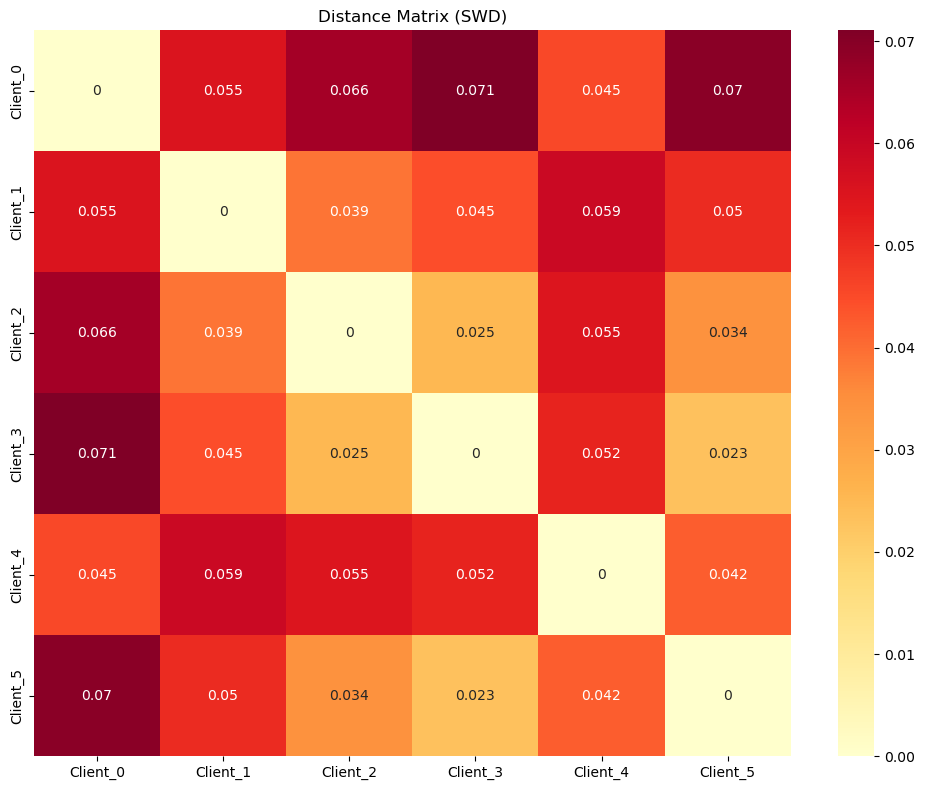

In [166]:
data_list3 = [data_list[0], data_list[2], data_list[3], data_list[4], data_list[5], data_list[6], data_list[7], data_list[8]]
analyzer = DistanceAnalyzer(
        data_list=data_list2,
        features_numerical=num_cols,
        features_binary=cat_cols,
        distance_method='swd',
        dim_reduction=None,
        n_components=5,
        n_projections=300
    )
    
# Distance Matrix
distance_matrix = analyzer.compute_distance_matrix(figsize=(10, 8))

In [168]:
df = pd.concat(data_list3, axis = 0, ignore_index = True)
split_indices = np.cumsum([df_sub.shape[0] for df_sub in data_list3[:-1]])

avg_correlation_cols = avg_correlation(df)
avg_correlation_cols = [col[0] for col in avg_correlation_cols if col[0] in num_cols]
avg_correlation_cols = [col for col in avg_correlation_cols][:int(df.shape[1]*0.3)]

# data config
data_config = {
    'target': target,
    'important_features_idx': [
        idx for idx in range(0, data.shape[1]) 
        if (data.columns[idx] != target) and (data.columns[idx] not in cat_cols)
    ],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target],
	"num_cols": data.shape[1] - 1 - len(cat_cols),
	'task_type': 'classification',
	'clf_type': 'binary-class',
	'data_type': 'tabular',
	'client_split_indices': split_indices.tolist()
}

# data config new1 - predict days in hospital - without categorical features, top10 clients, 40% iid sampling 
with open('./data/hhp/data_config_ct_np9.json', 'w') as f:
    json.dump(data_config, f)
    
data.to_csv('./data/hhp/data_clean_ct_np9.csv', index=False)

In [23]:
data[target].value_counts()

ClaimsTruncated
0.0    61676
1.0    26270
Name: count, dtype: int64

In [24]:
run_classification(data, target, smote = None)

X_train shape: (70356, 32)
Accuracy: 0.869300739056282
F1: 0.772082878953108
Recall: 0.7432716167207483
Precision: 0.8032178217821783
ROC: 0.8330154537332185
PRC: 0.673472908918107


## Vehicle

In [48]:
import scipy.io
from collections import Counter

mat = scipy.io.loadmat('./data/vehicle/vehicle.mat')
raw_x, raw_y = mat['X'], mat['Y']  # y = {-1, 1}
assert len(raw_x) == len(raw_y)
num_clients = len(raw_x)

dataset = []
for i in range(num_clients):
    features, labels = raw_x[i][0], raw_y[i][0].flatten()
    assert len(features) == len(labels)
    counter = Counter(labels)
    print(f'Client {i}:', counter, counter[1] / len(labels), raw_x[i][0].shape, raw_y[i][0].shape)
    dataset.append((features, labels))

positive_counts = [np.count_nonzero(labels + 1) for feats, labels in dataset]
positive_percentages = [np.count_nonzero(labels + 1) / len(labels) * 100
                      for feats, labels in dataset]

dfs = []
for i in range(num_clients):
    df = pd.DataFrame(dataset[i][0])
    df['label'] = dataset[i][1]
    dfs.append(df)
selected_dfs2 = dfs
selected_df = pd.concat(selected_dfs2, axis=0)

Client 0: Counter({-1: 1296, 1: 1282}) 0.4972847168347556 (2578, 100) (2578, 1)
Client 1: Counter({1: 787, -1: 724}) 0.5208471211118465 (1511, 100) (1511, 1)
Client 2: Counter({-1: 773, 1: 746}) 0.4911125740618828 (1519, 100) (1519, 1)
Client 3: Counter({1: 760, -1: 665}) 0.5333333333333333 (1425, 100) (1425, 1)
Client 4: Counter({1: 738, -1: 637}) 0.5367272727272727 (1375, 100) (1375, 1)
Client 5: Counter({-1: 629, 1: 535}) 0.45962199312714774 (1164, 100) (1164, 1)
Client 6: Counter({1: 889, -1: 794}) 0.5282234105763518 (1683, 100) (1683, 1)
Client 7: Counter({1: 918, -1: 817}) 0.5291066282420749 (1735, 100) (1735, 1)
Client 8: Counter({-1: 1080, 1: 920}) 0.46 (2000, 100) (2000, 1)
Client 9: Counter({1: 920, -1: 781}) 0.5408583186360965 (1701, 100) (1701, 1)
Client 10: Counter({1: 1021, -1: 782}) 0.5662784248474765 (1803, 100) (1803, 1)
Client 11: Counter({1: 1050, -1: 753}) 0.5823627287853578 (1803, 100) (1803, 1)
Client 12: Counter({1: 1165, -1: 789}) 0.5962128966223132 (1954, 100) 

In [49]:
from sklearn.ensemble import RandomForestRegressor  # or RandomForestClassifier based on your task

# Assuming 'label' is your prediction target
X = selected_df.drop('label', axis=1)
y = selected_df['label']

model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

sorted_features = [feature[0] for feature in sorted_features if feature[1] > 0.01]
print(sorted_features)

correlated_cols = selected_df.corrwith(selected_df['label']).abs().sort_values(ascending = False)[:30].index.tolist()
print(correlated_cols)

final_cols = list(set(sorted_features) | set(correlated_cols))
final_cols.remove('label')
print(final_cols)

[0, 4, 3, 6, 54, 51, 10, 1, 40, 5, 8, 50, 53, 58, 7, 9, 11, 41]
['label', 40, 42, 41, 44, 43, 47, 46, 45, 49, 48, 37, 8, 9, 39, 10, 11, 38, 7, 51, 36, 4, 35, 1, 12, 53, 3, 0, 54, 19]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 19, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 58]


In [67]:
final_dfs = [df.copy()[final_cols] for df in selected_dfs2]
data = selected_df[final_cols]
data = data.drop(columns = [41, 42, 43, 37, 44, 47, 46, 49, 45, 48])
print(data.shape)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

# scaling
scaler = Pipeline([
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])

cols = data.columns.tolist()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns = cols)

# Assuming 'df' is your DataFrame with binary features
gaussian_cols = [11, 35, 36, 38, 39, 40, 58]
transformer = QuantileTransformer(output_distribution='normal', random_state=0)
df_gaussianized = transformer.fit_transform(data[gaussian_cols])
df_gaussianized = pd.DataFrame(df_gaussianized, columns=gaussian_cols)
data = pd.concat([data.drop(columns = gaussian_cols), df_gaussianized], axis = 1)

# scaling
scaler = Pipeline([
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])

cols = data.columns.tolist()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns = cols)

data.columns = [idx for idx, col in enumerate(data.columns)]
data['label'] = selected_df['label'].values
client_split_indices = np.cumsum([df.shape[0] for df in selected_dfs2[:-1]])
print(client_split_indices)

datas = np.array_split(data.values, client_split_indices.tolist())
data_list = [pd.DataFrame(item, columns = data.columns) for item in datas]
remove_idx = [5, 6, 7, 9, 11, 14, 20]
data_list = [item for idx, item in enumerate(data_list) if idx not in remove_idx]
data = pd.concat(data_list, axis = 0, ignore_index=True)
client_split_indices = np.cumsum([df.shape[0] for df in data_list[:-1]])
print(client_split_indices)

target_col = 'label'
data[target_col], codes = pd.factorize(data[target_col])
num_cols = data.columns.tolist()[:-1]
cat_cols = []

data_config = {
    'target': target_col,
    'important_features_idx': list(range(len(data.columns)-1)),
    'features_idx': list(range(len(data.columns)-1)),
    'num_cols': len(num_cols),
    'task_type': 'classification',
    'clf_type': 'binary-class',
    'data_type': 'tabular',
    'client_split_indices': client_split_indices.tolist()
}

(43695, 23)
[ 2578  4089  5608  7033  8408  9572 11255 12990 14990 16691 18494 20297
 22251 24451 26665 28579 30647 32609 34896 36898 38966 41414]
[ 2578  4089  5608  7033  8408 10408 12211 14165 16365 18279 20347 22309
 24596 26598 29046]


In [63]:
data

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,label
0,0.357675,1.000000,0.404927,0.403425,0.282002,0.295630,0.242185,0.236203,0.329902,0.246364,...,0.342003,0.354476,0.538133,0.526322,0.539698,0.551666,0.538537,0.572105,0.477316,0
1,0.307950,0.271348,0.178103,0.228182,0.212612,0.266045,0.495916,0.262394,0.576165,1.000000,...,1.000000,0.712168,0.694107,0.692391,0.420758,0.422414,0.416467,0.417861,0.397048,1
2,0.417635,0.463204,0.249475,0.274103,0.227642,0.353108,0.245206,0.239683,0.329626,1.000000,...,0.469065,0.378067,0.542197,0.527326,0.533136,0.543255,0.540596,0.536571,0.478970,1
3,0.546221,1.000000,0.724081,0.334466,0.522237,0.404080,0.350616,0.218904,0.454106,0.229616,...,1.000000,0.380291,0.523628,0.440805,0.443903,0.448343,0.449062,0.450943,0.512079,1
4,0.304999,0.311562,0.199412,0.244337,0.291055,0.295692,0.448218,0.395562,1.000000,0.919801,...,0.281109,0.440528,0.669675,0.418492,0.418571,0.385278,0.402010,0.452463,0.572578,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39090,0.340515,0.612666,1.000000,0.662275,0.735880,0.890836,0.551751,0.338337,0.828253,0.252174,...,0.451989,0.456230,0.307597,0.345050,0.349007,0.357570,0.355381,0.358801,0.370734,1
39091,0.309085,0.277921,0.365680,1.000000,0.265039,0.283457,0.238505,0.824193,0.356334,0.534297,...,0.693140,0.380762,0.507682,0.396021,0.399991,0.406578,0.408014,0.411129,0.552016,1
39092,0.296525,0.256823,0.177584,0.196321,0.245273,1.000000,0.561109,0.354570,0.487476,0.255184,...,0.325778,0.344260,0.245507,0.345563,0.357396,0.358086,0.356119,0.357001,0.537162,1
39093,1.000000,0.446499,0.338420,0.458800,0.332365,0.389317,0.230082,0.202452,0.285533,0.372079,...,0.311538,0.326512,0.560325,0.461277,0.456040,0.460716,0.463097,0.462554,0.562535,0


In [69]:
with open('./data/vehicle/data_config3.json', 'w') as f:
    json.dump(data_config, f)

data.to_csv('./data/vehicle/data_clean3.csv', index=False) 

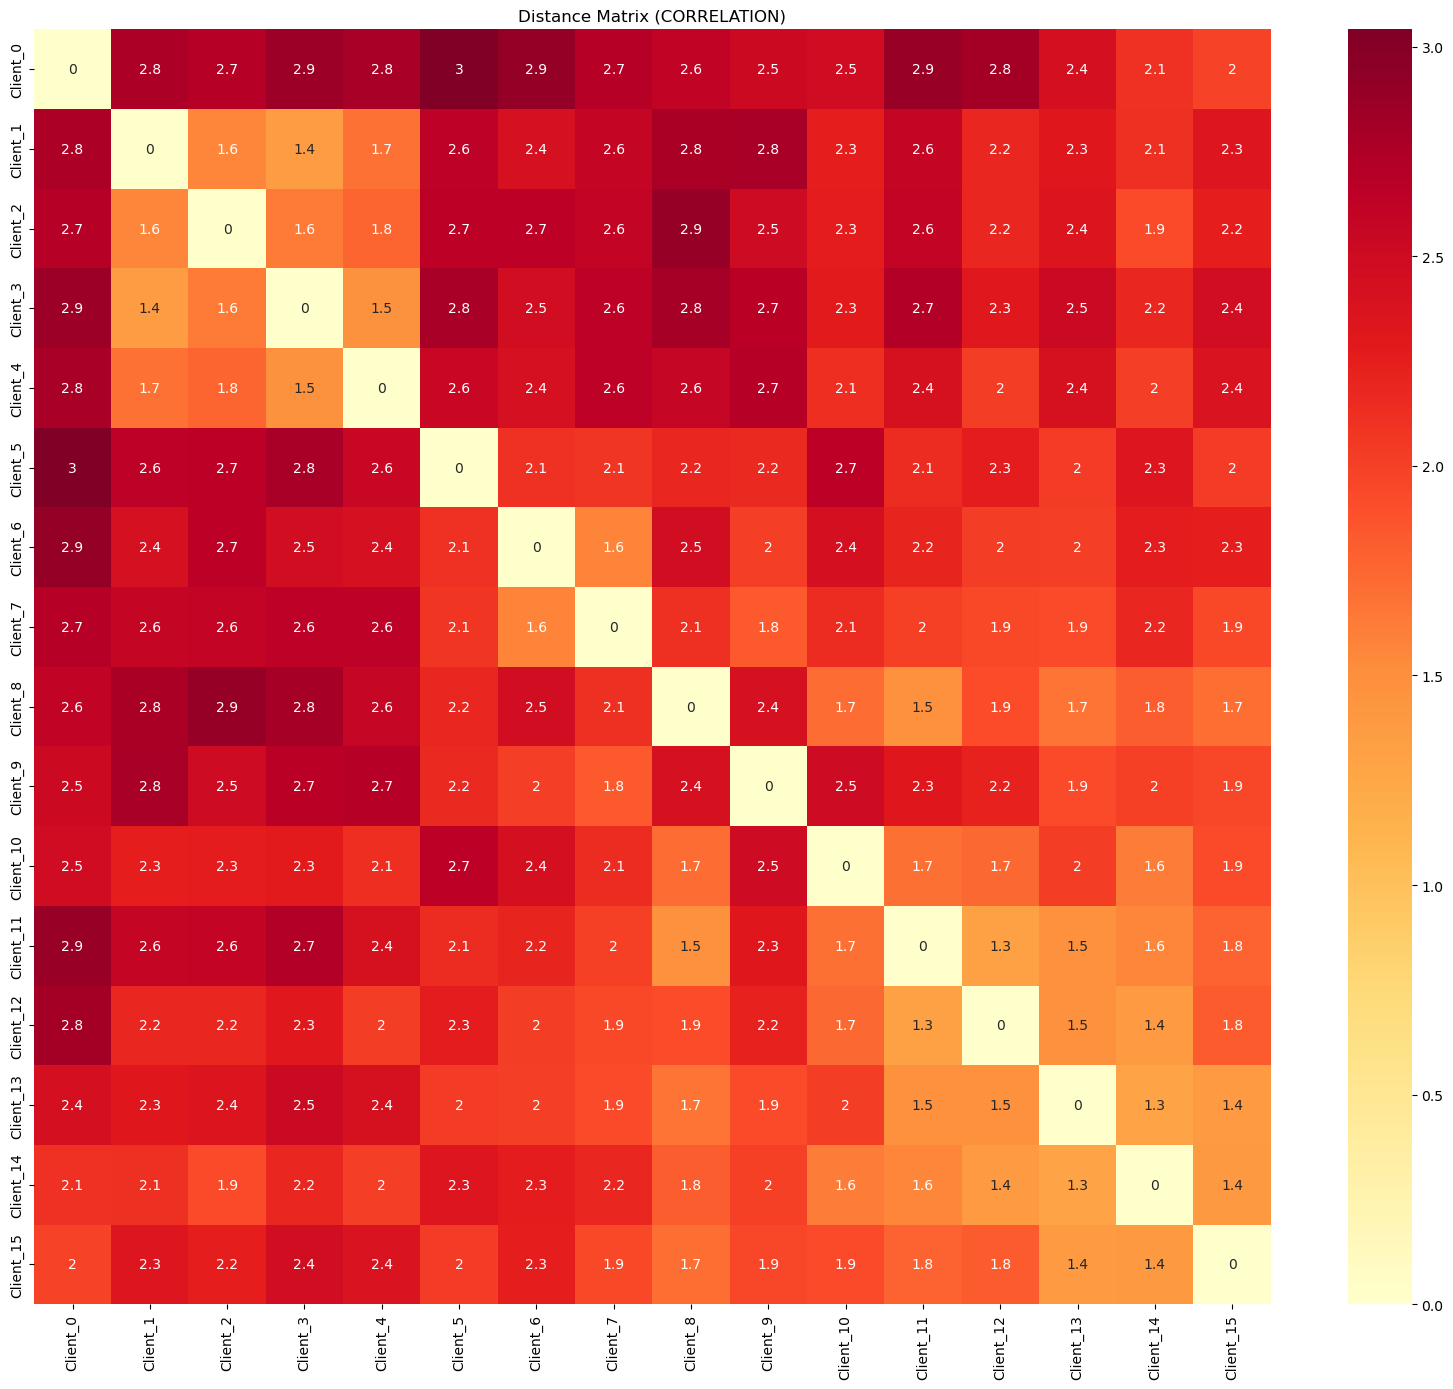

In [68]:
datas = np.array_split(data.values[:, :-1], client_split_indices.tolist())
data_list = [pd.DataFrame(item, columns = data.columns[:-1]) for item in datas]

analyzer = DistanceAnalyzer(
        data_list=data_list,
        features_numerical=num_cols,
        features_binary=cat_cols,
        distance_method='correlation',
        dim_reduction=None,
        n_components=10,
        n_projections=300
    )
    
# Distance Matrix
distance_matrix = analyzer.compute_distance_matrix(figsize=(16, 14))

## EICU

In [251]:
# vital sign features
df_all = pd.read_csv('./data/eicu/all_data.csv')
df_all = df_all.drop(columns = [
    'hospitaladmitoffset', 'hospitaldischargestatus', 'itemoffset', 'unitdischargeoffset', 'unitdischargestatus', 'age', 'gender', 'admissionheight', 
    'admissionweight', 'apacheadmissiondx', 'ethnicity'
])
print(df_all.columns)

df_all_agg = df_all.groupby('patientunitstayid')[
    ['Heart Rate', 'Invasive BP Diastolic', 'Invasive BP Systolic', 'O2 Saturation', 'Respiratory Rate', 'Temperature (C)', 'glucose'
]].agg({
    #'FiO2': ['mean', 'max'],
    'Heart Rate': ['mean', 'min', 'max'],
    'Invasive BP Diastolic': ['mean', 'min', 'max'],
    'Invasive BP Systolic': ['mean', 'min', 'max'],
    'O2 Saturation': ['mean', 'min'],
    'Respiratory Rate': ['mean', 'min', 'max'],
    'Temperature (C)': ['max'],
    'glucose': ['mean', 'min', 'max'],
    # 'pH': ['mean', 'min', 'max'],
    # 'GCS Total': ['min', 'mean'],
    # 'Motor': ['min', 'mean'],
    # 'Eyes': ['min', 'mean'],
    # 'Verbal': ['min', 'mean'],
})

df_all_agg.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in df_all_agg.columns]
print(df_all_agg.shape)
df_all_agg.head()

Index(['Eyes', 'FiO2', 'GCS Total', 'Heart Rate', 'Invasive BP Diastolic',
       'Invasive BP Systolic', 'MAP (mmHg)', 'Motor', 'O2 Saturation',
       'Respiratory Rate', 'Temperature (C)', 'Verbal', 'glucose', 'pH',
       'patientunitstayid'],
      dtype='object')
(74336, 18)


,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Invasive BP Diastolic_mean,Invasive BP Diastolic_min,Invasive BP Diastolic_max,Invasive BP Systolic_mean,Invasive BP Systolic_min,Invasive BP Systolic_max,O2 Saturation_mean,O2 Saturation_min,Respiratory Rate_mean,Respiratory Rate_min,Respiratory Rate_max,Temperature (C)_max,glucose_mean,glucose_min,glucose_max
patientunitstayid,,,,,,,,,,,,,,,,,,
141203,84.280702,61.0,118.0,56.964912,31.0,95.0,108.912281,77.0,139.0,98.350877,86.0,17.526316,7.000000,31.0,37.300000,128.368421,95.0,150.0
141265,89.721088,64.0,109.0,74.363946,55.0,102.0,127.809524,91.0,168.0,95.361678,91.0,18.877551,10.000000,33.0,37.800000,123.394558,72.0,178.0
141276,91.833333,72.0,112.0,72.657407,56.0,91.0,141.351852,116.0,167.0,96.555556,90.0,21.333333,16.000000,32.0,37.222222,148.194444,128.0,237.0
141329,68.391304,59.0,86.0,63.322981,51.0,81.0,109.978261,82.0,127.0,97.869565,84.0,19.913043,14.000000,44.0,37.111111,128.130435,128.0,134.0
141337,77.166667,64.0,90.0,63.833333,53.0,77.0,133.133333,101.0,162.0,96.033333,90.0,18.215556,14.666667,21.0,37.222222,127.800000,87.0,158.0


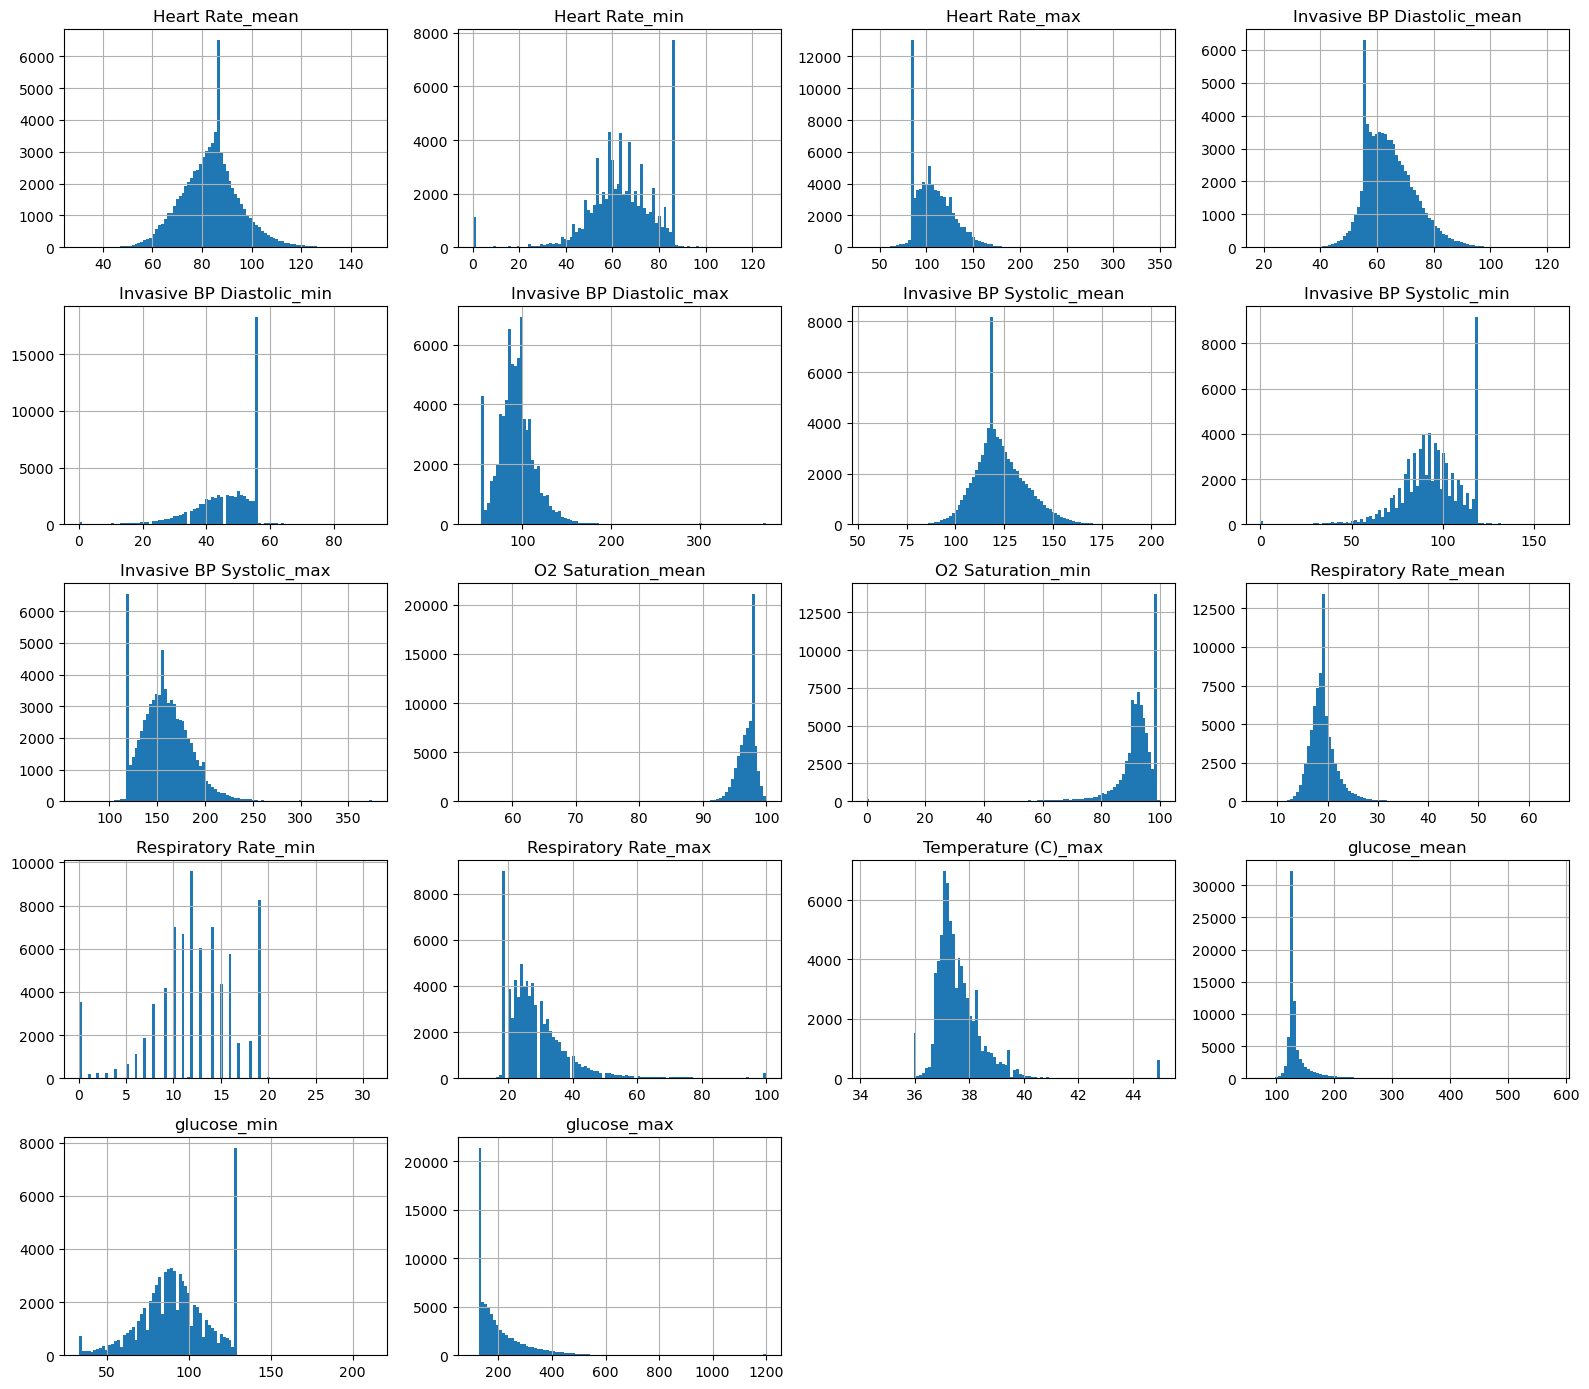

In [89]:
df_all_agg.hist(bins = 100, figsize=(16, 14))
plt.tight_layout()
plt.show()

In [252]:
# stay information
patient_info = pd.read_csv('./data/eicu/patient.csv')
hospital_info = pd.read_csv('./data/eicu/hospital.csv')
df_stay = pd.read_csv('./data/eicu/all_stays.csv')

patient_info = patient_info.join(hospital_info.set_index('hospitalid'), on = 'hospitalid', how = 'left')
patient_info = patient_info[['patientunitstayid', 'hospitalid', 'uniquepid']]
df_stay = df_stay.join(patient_info.set_index('patientunitstayid'), on = 'patientunitstayid', how = 'left')
print(df_stay.shape)

# generate stay lenght information
df_stay['hospital_los'] = df_stay['hospitaldischargeoffset'] - df_stay['hospitaladmitoffset']
df_stay['icu_los'] = df_stay['unitdischargeoffset']
df_stay['pre_icu_los'] = - df_stay['hospitaladmitoffset']
df_stay = df_stay.drop(columns = [
    'hospitaldischargeoffset', 'hospitaladmitoffset', 'unitdischargeoffset', 'hospitaladmityear', 'hospitaldischargeyear'
])

df_stay = df_stay.dropna()
print(df_stay.shape)

# Data selection - remove bad gender
df_stay = df_stay[df_stay['gender'] != 0]
print(df_stay.shape)

# Data selection - has discharge status
df_stay = df_stay[df_stay['hospitaldischargestatus'] != 2]
print(df_stay.shape)
df_stay.head()

(96212, 16)
(92398, 14)
(92368, 14)
(91558, 14)


,patientunitstayid,gender,age,ethnicity,apacheadmissiondx,admissionheight,admissionweight,hospitaldischargestatus,unitdischargestatus,hospitalid,uniquepid,hospital_los,icu_los,pre_icu_los
0,141203,1,77,3,0,160.0,70.2,0,0,66,002-23234,5399,1869,1336
1,141208,1,25,3,1,172.7,95.3,0,0,73,002-34521,607,720,1
2,141233,1,81,3,2,165.1,61.7,0,0,73,002-8979,22941,15685,1
3,141265,2,67,3,3,190.5,100.0,0,0,63,002-24408,16118,6068,1
4,141276,1,59,3,0,165.1,156.6,0,0,63,002-9090,1717,1684,1


### Task1 Mortality prediction

In [253]:
# final data
df_final = df_stay.join(df_all_agg, on = 'patientunitstayid', how = 'inner')
df_final = df_final.drop(columns = ['unitdischargestatus', 'uniquepid', 'apacheadmissiondx', 'gender', 'ethnicity'])
sample_threshold = 500

# select hospitals with 1000+ stays
stay_counts = df_final.groupby('hospitalid')['patientunitstayid'].agg('count').sort_values(ascending = False)
print(f"Number of hospitals (> {sample_threshold} stays):", stay_counts[stay_counts > sample_threshold].shape[0])
df_final = df_final[df_final['hospitalid'].isin(stay_counts[stay_counts > sample_threshold].index)]
print(df_final.shape)

df_final = df_final.set_index('patientunitstayid').reset_index(drop = True)
print(df_final.shape)

# task1 - mortality prediction
target = 'hospitaldischargestatus'
split_col = ['hospitalid']
#cat_cols = ['gender', 'ethnicity']
cat_cols = []
num_cols = [col for col in df_final.columns if col not in cat_cols + [target] + split_col]

# standardize
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
df_final[num_cols] = scaler.fit_transform(df_final[num_cols])
scaler = MinMaxScaler()
df_final[num_cols] = scaler.fit_transform(df_final[num_cols])

# one-hot categorical features
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder(handle_unknown = 'ignore', max_categories=10, drop='first')
oh.fit(df_final[cat_cols])
oh_cols = oh.get_feature_names_out(cat_cols)
print(oh_cols)
df_final_cat = pd.DataFrame(oh.transform(df_final[cat_cols]).toarray(), columns = oh_cols)
df_final = pd.concat([df_final.drop(columns = cat_cols), df_final_cat], axis = 1)
cat_cols = oh_cols.tolist()
print(cat_cols)
print(df_final.shape)

# reorder target to be num cols, cat cols and target
df_final = df_final[split_col + num_cols + cat_cols + [target]]
print(df_final.shape)

# split by hospital id
df_rets = [df_sub for _, df_sub in df_final.groupby(split_col[0])]
print(len(df_rets))

# select similar clients
#selected_clients = [10, 13, 24, 27, 28, 33, 39, 42, 43]
selected_clients = [4, 5, 6, 10, 16, 20, 21, 24, 39, 42]
df_rets = [df_sub for idx, df_sub in enumerate(df_rets) if idx in selected_clients]
print([df_sub.shape for df_sub in df_rets])

df_rets = [df_sub.reset_index(drop = True) for df_sub in df_rets]
split_indices = np.cumsum([df_sub.shape[0] for df_sub in df_rets[:-1]])
print(split_indices)

data = pd.concat(df_rets, axis = 0, ignore_index=True)
data = data.drop(columns = split_col)
print(data.shape)

# data config
data_config = {
    'target': target,
    'important_features_idx': [
        idx for idx in range(0, data.shape[1]) 
        if (data.columns[idx] != target) and (data.columns[idx] not in cat_cols)
    ],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target],
	"num_cols": data.shape[1] - 1 - len(cat_cols),
	'task_type': 'classification',
	'clf_type': 'binary-class',
	'data_type': 'tabular',
	'client_split_indices': split_indices.tolist()
}

# data config new1 - predict days in hospital - without categorical features, top10 clients, 40% iid sampling 
# with open('./data/eicu/data_config_mo_np22.json', 'w') as f:
#     json.dump(data_config, f)
    
# data.to_csv('./data/eicu/data_clean_mo_np22.csv', index=False)
data

Number of hospitals (> 500 stays): 45
(46612, 27)
(46612, 26)
[]
[]
(46612, 26)
(46612, 26)
45
[(628, 26), (770, 26), (625, 26), (1829, 26), (666, 26), (1714, 26), (2481, 26), (1756, 26), (1755, 26), (665, 26)]
[  628  1398  2023  3852  4518  6232  8713 10469 12224]
(12889, 25)


,age,admissionheight,admissionweight,hospital_los,icu_los,pre_icu_los,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Invasive BP Diastolic_mean,...,O2 Saturation_mean,O2 Saturation_min,Respiratory Rate_mean,Respiratory Rate_min,Respiratory Rate_max,Temperature (C)_max,glucose_mean,glucose_min,glucose_max,hospitaldischargestatus
0,0.661972,0.281322,0.070227,0.002792,0.024099,0.060156,0.522794,0.642857,0.226115,0.471203,...,0.997280,0.98,0.359757,0.451613,0.197802,0.252577,0.114717,0.592105,0.060662,0
1,0.450704,0.272893,0.059347,0.005215,0.021836,0.059971,0.512118,0.674603,0.216561,0.381736,...,0.973531,0.98,0.193521,0.354839,0.109890,0.242268,0.248515,0.414474,0.341912,0
2,0.478873,0.264463,0.078690,0.008145,0.058401,0.067999,0.305122,0.428571,0.162420,0.587075,...,0.922870,0.91,0.166657,0.290323,0.098901,0.268041,0.102197,0.401316,0.014706,0
3,0.633803,0.260331,0.042422,0.016913,0.142571,0.068422,0.401803,0.007937,0.210191,0.403633,...,0.973790,0.86,0.437338,0.000000,0.241758,0.314433,0.104684,0.335526,0.070772,1
4,0.394366,0.293884,0.084735,0.008979,0.026325,0.060535,0.621679,0.682540,0.270701,0.556436,...,0.976063,0.96,0.226518,0.290323,0.131868,0.268041,0.098234,0.460526,0.014706,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12884,0.830986,0.285455,0.089241,0.009478,0.025008,0.062689,0.402400,0.063492,0.219745,0.348798,...,0.937437,0.96,0.254141,0.483871,0.109890,0.283782,0.074707,0.315789,0.014706,0
12885,0.676056,0.285455,0.171447,0.026883,0.244105,0.066922,0.478249,0.420635,0.264331,0.470339,...,0.920709,0.90,0.365311,0.000000,0.945055,0.453899,0.147808,0.578947,0.166360,0
12886,0.704225,0.293884,0.154533,0.011661,0.085376,0.060075,0.325179,0.436508,0.159236,0.476222,...,0.915556,0.93,0.339149,0.516129,0.945055,0.299247,0.088024,0.309211,0.036765,0
12887,0.816901,0.285488,0.078756,0.007093,0.019312,0.059807,0.519190,0.650794,0.251592,0.389660,...,0.932178,0.95,0.222263,0.322581,0.109890,0.273472,0.142907,0.532895,0.093750,0


In [254]:
with open('./data/eicu/data_config_mo_np1121.json', 'w') as f:
    json.dump(data_config, f)
    
data.to_csv('./data/eicu/data_clean_mo_np1121.csv', index=False)

In [328]:
run_classification(data, target, smote = None)

X_train shape: (37289, 32)
Accuracy: 0.9617076048482248
F1: 0.7325842696629213
Recall: 0.6309677419354839
Precision: 0.8732142857142857
ROC: 0.8113308527178589
PRC: 0.5816468668487972


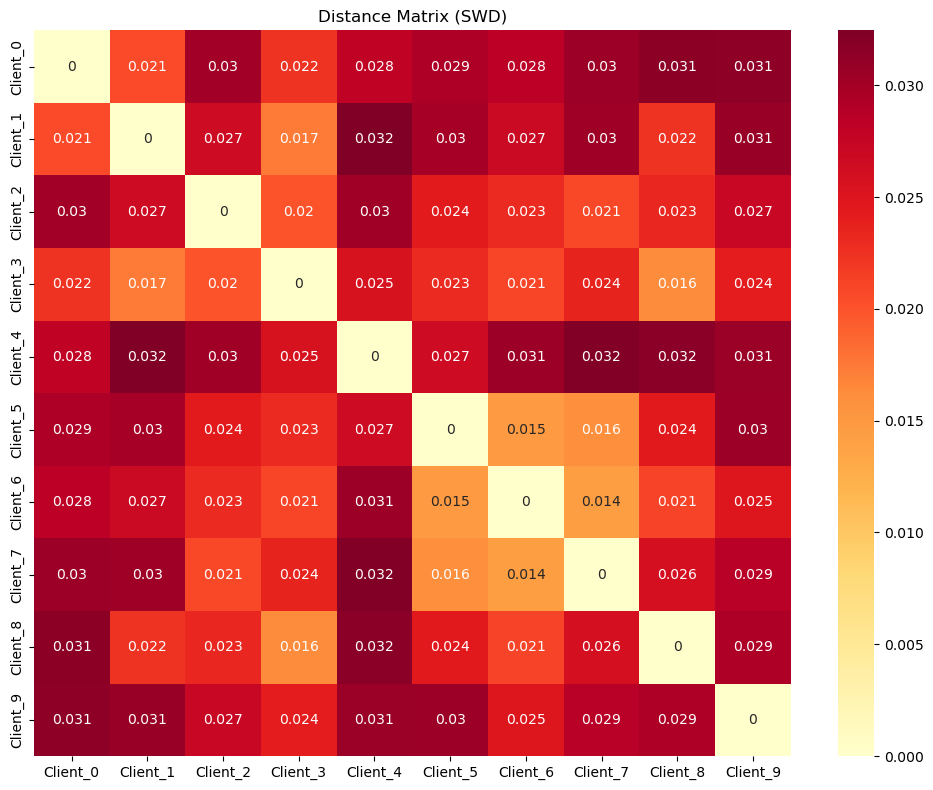

In [250]:
data_list = [item.drop(columns = [target]) for item in df_rets]

analyzer = DistanceAnalyzer(
        data_list=data_list,
        features_numerical=num_cols,
        features_binary=cat_cols,
        distance_method='swd',
        dim_reduction=None,
        n_components=10,
        n_projections=100
    )
    
# Distance Matrix
distance_matrix = analyzer.compute_distance_matrix(figsize=(10, 8))

In [332]:
thres = 0.11
for client_id in range(len(distance_matrix)):
    distances = distance_matrix[client_id]
    indices = np.where(distances <= thres)[0].tolist()
    indices.remove(client_id)
    if len(indices) > 0:
        print(f"Client {client_id}:", indices)

Client 6: [7]
Client 7: [6]
Client 8: [9]
Client 9: [8]
Client 10: [39]
Client 13: [24, 27]
Client 24: [13, 25, 27, 28, 33, 39]
Client 25: [24, 27]
Client 27: [13, 24, 25, 28, 33, 37, 39, 42, 43]
Client 28: [24, 27, 39]
Client 33: [24, 27, 39]
Client 37: [27]
Client 39: [10, 24, 27, 28, 33]
Client 42: [27]
Client 43: [27]


D:\TMP\ipykernel_30428\3730286794.py:168: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='average')


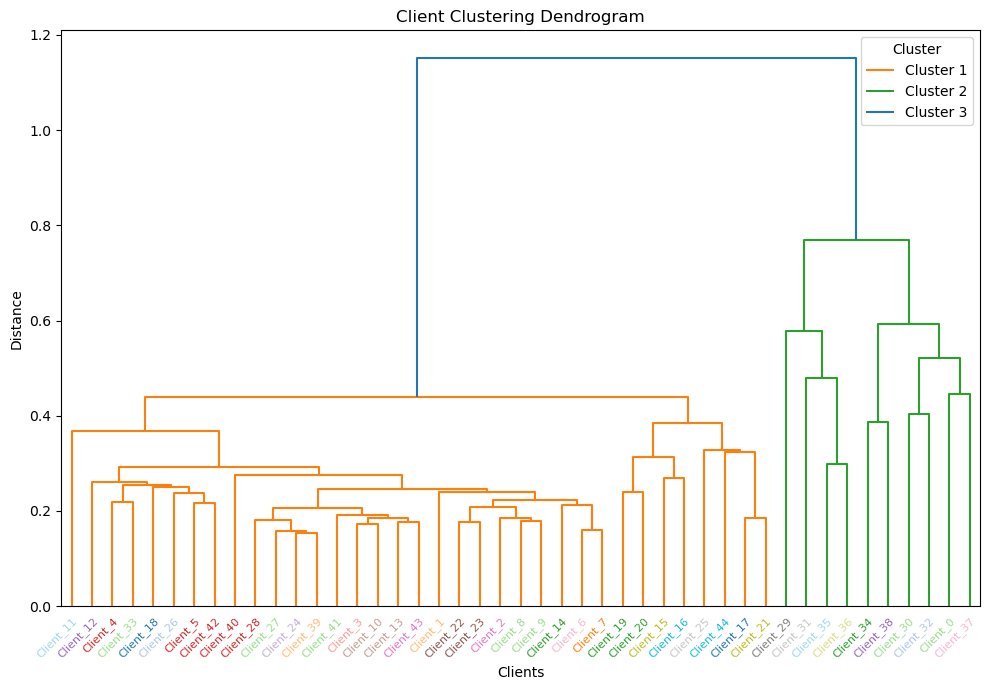


Clustering Results (33 clusters):

Cluster 1 (1 members):
Client_4

Cluster 2 (1 members):
Client_33

Cluster 3 (1 members):
Client_5

Cluster 4 (1 members):
Client_42

Cluster 5 (1 members):
Client_26

Cluster 6 (1 members):
Client_18

Cluster 7 (1 members):
Client_12

Cluster 8 (4 members):
Client_24, Client_27, Client_28, Client_39
Average internal distance: 0.108

Cluster 9 (5 members):
Client_3, Client_10, Client_13, Client_41, Client_43
Average internal distance: 0.119

Cluster 10 (2 members):
Client_22, Client_23
Average internal distance: 0.117

Cluster 11 (3 members):
Client_2, Client_8, Client_9
Average internal distance: 0.123

Cluster 12 (2 members):
Client_6, Client_7
Average internal distance: 0.110

Cluster 13 (1 members):
Client_14

Cluster 14 (1 members):
Client_1

Cluster 15 (1 members):
Client_40

Cluster 16 (1 members):
Client_11

Cluster 17 (1 members):
Client_19

Cluster 18 (1 members):
Client_20

Cluster 19 (1 members):
Client_15

Cluster 20 (1 members):
Client_

In [307]:
# Clustering
results = analyzer.clustering(n_clusters=None, threshold=0.2)

In [244]:
result['labels']

array([ 7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  4,
        0,  0,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  5,  9,  8,  6,  0,
       10,  1,  1,  2,  3,  0,  0,  0,  0,  0,  0], dtype=int64)

## Heart Disease

In [282]:
dfs = []
for site in ['cleveland', 'hungarian', 'switzerland', 'va']:

    df = pd.read_csv('./data/heart_disease/processed.{}.data'.format(site), header=None, na_values='?')
    columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
    df.columns = columns
    print(site, df.shape)
    #print(df.isna().sum())
    df['fbs']  = df['fbs'].fillna(df['fbs'].mean())
    df['trestbps'] = df['trestbps'].fillna(df['trestbps'].mean())
    df['chol'] = df['chol'].fillna(df['chol'].mean())
    df['thalach'] = df['thalach'].fillna(df['thalach'].mean())
    df['exang'] = df['exang'].fillna(df['exang'].mean())
    df = df.drop(columns=['ca', 'slope', 'thal'])
    df = df.dropna()
    df['fbs'] = df['fbs'].astype(int)
    df['sex'] = df['sex'].astype(int)
    df['cp'] = df['cp'].astype(int)
    df['restecg'] = df['restecg'].astype(int)
    print(site, df.shape)
    dfs.append(df)

cat_cols = ['sex', 'cp', 'restecg', 'fbs']
target_col = 'num'
num_cols = [col for col in dfs[0].columns if col != target_col and col not in cat_cols]

df = pd.concat(dfs, axis=0)
client_split_indices = np.cumsum([df_sub.shape[0] for df_sub in dfs[:-1]])
print(client_split_indices)

# standardize
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(df.shape)
print(num_cols)
cat_cols = [col for col in df.columns if col not in num_cols + [target_col]]
df = df[num_cols + cat_cols + [target_col]]
for col in cat_cols:
    df[col] = df[col].astype(int)
    
df[target_col] = df[target_col].map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})

data_config = {
    'target': target,
    'important_features_idx': [
        idx for idx in range(0, df.shape[1]) 
        if (df.columns[idx] != target) and (df.columns[idx] not in cat_cols)
    ],
	'features_idx': [idx for idx in range(0, df.shape[1]) if df.columns[idx] != target],
	"num_cols": df.shape[1] - 1 - len(cat_cols),
	'task_type': 'classification',
	'clf_type': 'binary-class',
	'data_type': 'tabular',
	'client_split_indices': client_split_indices.tolist()
}
print(data_config)

with open('./data/heart_disease/data_config_binary.json', 'w') as f:
    json.dump(data_config, f)

df.to_csv('./data/heart_disease/data_clean_binary.csv', index=False)


cleveland (303, 14)
cleveland (303, 11)
hungarian (294, 14)
hungarian (293, 11)
switzerland (123, 14)
switzerland (116, 11)
va (200, 14)
va (144, 11)
[303 596 712]
(856, 14)
['age', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak']
{'target': 'ClaimsTruncated', 'important_features_idx': [0, 1, 2, 3, 4, 5, 13], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'num_cols': 6, 'task_type': 'classification', 'clf_type': 'binary-class', 'data_type': 'tabular', 'client_split_indices': [303, 596, 712]}


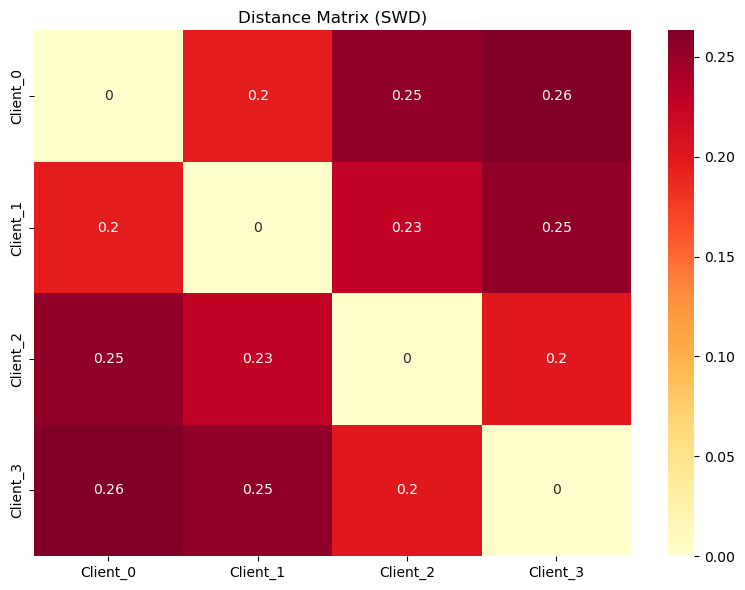

In [284]:
datas = np.array_split(df.values[:, :-1], client_split_indices.tolist())
data_list = [pd.DataFrame(item, columns = df.columns[:-1]) for item in datas]

analyzer = DistanceAnalyzer(
        data_list=data_list,
        features_numerical=num_cols,
        features_binary=cat_cols,
        distance_method='swd',
        dim_reduction=None,
        n_components=10,
        n_projections=300
    )
    
# Distance Matrix
distance_matrix = analyzer.compute_distance_matrix(figsize=(8, 6))

In [184]:
dfs = []
for site in ['cleveland', 'hungarian', 'switzerland', 'va']:

    df = pd.read_csv('./data/heart_disease/processed.{}.data'.format(site), header=None, na_values='?')
    columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
    df.columns = columns
    print(site, df.shape)
    #print(df.isna().sum())
    df['fbs']  = df['fbs'].fillna(df['fbs'].mean())
    df['trestbps'] = df['trestbps'].fillna(df['trestbps'].mean())
    df['chol'] = df['chol'].fillna(df['chol'].mean())
    df['thalach'] = df['thalach'].fillna(df['thalach'].mean())
    df['exang'] = df['exang'].fillna(df['exang'].mean())
    df = df.drop(columns=['ca', 'slope', 'thal'])
    df = df.dropna()
    df['fbs'] = df['fbs'].astype(int)
    df['sex'] = df['sex'].astype(int)
    df['cp'] = df['cp'].astype(int)
    df['restecg'] = df['restecg'].astype(int)
    print(site, df.shape)
    dfs.append(df)

cat_cols = ['sex', 'cp', 'restecg', 'fbs']
target_col = 'num'
num_cols = [col for col in dfs[0].columns if col != target_col and col not in cat_cols]

df = pd.concat(dfs, axis=0)
client_split_indices = np.cumsum([df_sub.shape[0] for df_sub in dfs[:-1]])
print(client_split_indices)

# standardize
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(df.shape)
print(num_cols)
cat_cols = []
num_cols = [col for col in df.columns if col != target_col]
df = df[num_cols + cat_cols + [target_col]]
for col in num_cols:
    df[col] = df[col].astype(float)
    
df[target_col] = df[target_col].map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})

data_config = {
    'target': target,
    'important_features_idx': [
        idx for idx in range(0, df.shape[1]) 
        if (df.columns[idx] != target) and (df.columns[idx] not in cat_cols)
    ],
	'features_idx': [idx for idx in range(0, df.shape[1]) if df.columns[idx] != target],
	"num_cols": df.shape[1] - 1 - len(cat_cols),
	'task_type': 'classification',
	'clf_type': 'binary-class',
	'data_type': 'tabular',
	'client_split_indices': client_split_indices.tolist()
}
print(data_config)

with open('./data/heart_disease/data_config_binary1.json', 'w') as f:
    json.dump(data_config, f)

df.to_csv('./data/heart_disease/data_clean_binary1.csv', index=False)

cleveland (303, 14)
cleveland (303, 11)
hungarian (294, 14)
hungarian (293, 11)
switzerland (123, 14)
switzerland (116, 11)
va (200, 14)
va (144, 11)
[303 596 712]
(856, 14)
['age', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak']
{'target': 'DaysInHospital', 'important_features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'num_cols': 13, 'task_type': 'classification', 'clf_type': 'binary-class', 'data_type': 'tabular', 'client_split_indices': [303, 596, 712]}


In [174]:
df[target_col].value_counts()

num
0    390
1    248
2    101
3     91
4     26
Name: count, dtype: int64

In [172]:
for col in df.columns:
    print(col, abs(df[col].corr(df[target_col])))

age 0.34573128518610674
trestbps 0.12107963023517393
chol 0.25578878141385764
thalach 0.35994754554711567
exang 0.39119166171843556
oldpeak 0.443403212229427
sex_1 0.25902373573137183
cp_2 0.3408289187051263
cp_3 0.17806996683216728
cp_4 0.4403297533627321
restecg_1 0.11004985577628348
restecg_2 0.09676481134651557
fbs_1 0.11242042311751703
num 1.0


In [176]:
df[target_col] = df[target_col].map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})

run_classification(df, target_col=target_col)

X_train shape: (684, 13)
Accuracy: 0.8313953488372093
F1: 0.8585365853658536
Recall: 0.8543689320388349
Precision: 0.8627450980392157
ROC: 0.8257351906570987
PRC: 0.8243119103590861


## Iris

In [17]:
normalize = True
threshold = 0.3
data = pd.read_csv("./data/iris/iris.csv", header=None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
data['5'] = data['5'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
target_col = '5'

if normalize:
	data = normalization(data, target_col)

# move target to the end of the dataframe
data = move_target_to_end(data, target_col)

# correlation
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
data_config = {
	'target': 'diagnosis',
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != 'diagnosis'],
	'num_cols': data.shape[1] - 1,
	'task_type': 'classification',
	'clf_type': 'multi-class'
}
correlation_ret

['3', '4', '1', '2']
(150, 5)
3
Average correlation: 0.8366399020186166 0.9702159417163926
0    0.333333
1    0.333333
2    0.333333
Name: 5, dtype: float64


5    1.000000
3    0.970216
4    0.963761
1    0.786578
2    0.626004
dtype: float64

## Breast Cancer

In [10]:
normalize = True
threshold = 0.3
data = pd.read_csv("./data/breast/data.csv", header=0)
data = data.drop(["id"], axis=1)
data = data.dropna()
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

target_col = 'diagnosis'

if normalize:
	data = normalization(data, target_col)

# drop co-linear features
drop_list = ['perimeter_mean', 'radius_mean', 'compactness_mean', 'concave points_mean', 'radius_se',
			 'perimeter_se', 'radius_worst', 'perimeter_worst', 'compactness_worst', 'concave points_worst',
			 'compactness_se', 'concave points_se', 'texture_worst', 'area_worst']
data = data.drop(drop_list, axis=1)  # do not modify x, we will use it later

# move target to the end of the dataframe
data = move_target_to_end(data, target_col)

# correlation
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
# data_config = {
# 	'target': 'diagnosis',
# 	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
# 	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != 'diagnosis'],
# 	'num_cols': data.shape[1] - 1,
# 	'task_type': 'classification',
# 	'clf_type': 'binary-class'
# }
correlation_ret

['area_mean', 'concavity_mean', 'concavity_worst', 'area_se', 'smoothness_worst', 'symmetry_worst', 'texture_mean', 'smoothness_mean', 'symmetry_mean', 'fractal_dimension_worst']
(569, 17)
2
Average correlation: 0.33159035999547587 0.70898383658539
0    0.627417
1    0.372583
Name: diagnosis, dtype: float64


diagnosis                  1.000000
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
area_se                    0.548236
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
concavity_se               0.253730
fractal_dimension_se       0.077972
smoothness_se              0.067016
fractal_dimension_mean     0.012838
texture_se                 0.008303
symmetry_se                0.006522
dtype: float64

## Wine Red

In [20]:
threshold = 0.15
data = pd.read_csv("./data/wine/winequality-red.csv", delimiter=';')

# data = data.drop(["id", "Unnamed: 32"], axis=1)
data = data.dropna()

print(data['quality'].value_counts())
#data['target'] = data.apply(lambda row: 0 if row['quality'] <= 5 else 1, axis=1)
#data = data.drop('quality', axis=1)

target_col = 'quality'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)

# print("Wine Red data loaded. Train size {}, Test size {}".format(train.shape, test.shape))
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)

# data_config = {
# 	'target': target_col,
# 	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
# 	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
# 	"num_cols": data.shape[1] - 1,
# 	'task_type': 'classification',
# 	'clf_type': 'binary-class'
# }

# if verbose:
# 	print("Data shape {} Test shape {}".format(data.shape))
# 	print(data_config)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64
['alcohol', 'volatile acidity', 'total sulfur dioxide', 'sulphates', 'citric acid', 'density']
(1599, 12)
6
Average correlation: 0.22335763929061636 0.5163981913679647
5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64


quality                 1.000000
alcohol                 0.516398
volatile acidity        0.400631
total sulfur dioxide    0.272119
sulphates               0.255621
citric acid             0.241260
density                 0.200875
fixed acidity           0.139067
chlorides               0.136353
free sulfur dioxide     0.121255
pH                      0.115950
residual sugar          0.057405
dtype: float64

## Wine White

In [22]:
threshold = 0.15
data = pd.read_csv("./data/wine/winequality-white.csv", delimiter=';')
data = data.dropna()
print(data['quality'].value_counts())
#data['target'] = data.apply(lambda row: 0 if row['quality'] <= 5 else 1, axis=1)
#data = data.drop(['quality'], axis=1)

target_col = 'quality'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64
['alcohol', 'density', 'volatile acidity', 'total sulfur dioxide', 'chlorides', 'residual sugar', 'free sulfur dioxide']
(4898, 12)
7
Average correlation: 0.20032979867866105 0.4688951098954679
6    0.448755
5    0.297468
7    0.179665
8    0.035729
4    0.033279
3    0.004083
9    0.001021
Name: quality, dtype: float64


quality                 1.000000
alcohol                 0.468895
density                 0.339018
volatile acidity        0.265695
total sulfur dioxide    0.229209
chlorides               0.222536
residual sugar          0.159467
free sulfur dioxide     0.153702
fixed acidity           0.124789
pH                      0.110645
sulphates               0.066696
citric acid             0.062975
dtype: float64

## Wine all three

In [6]:
threshold = 0.1
normalize = True
# merge data
data_white = pd.read_csv("./data/wine/winequality-white.csv", delimiter=';')
data_white['type'] = 0
data_red = pd.read_csv("./data/wine/winequality-red.csv", delimiter=';')
data_red['type'] = 1
data = pd.concat([data_white, data_red], axis=0)
data = data.dropna()

# label
data['quality'] = data.apply(lambda row: 0 if row['quality'] <= 5 else 1 if row['quality'] <=7 else 2, axis=1)
print(data['quality'].value_counts())
target_col = 'quality'
data = move_target_to_end(data, target_col)

# normalize
if normalize:
    data = normalization(data, target_col, categorical_cols=['type'])

# correlation
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret
data

1    3915
0    2384
2     198
Name: quality, dtype: int64
['alcohol', 'density', 'volatile acidity', 'chlorides', 'type']
(6497, 13)
3
Average correlation: 0.13679298297333367 0.4143662905490882
1    0.602586
0    0.366939
2    0.030476
Name: quality, dtype: float64


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942,0,1
1,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391,0,1
2,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348,0,1
3,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,0,1
4,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,0.198347,0.346667,0.048193,0.021472,0.134551,0.107639,0.087558,0.150183,0.565891,0.202247,0.362319,1,0
1595,0.173554,0.313333,0.060241,0.024540,0.088040,0.131944,0.103687,0.154425,0.620155,0.303371,0.463768,1,1
1596,0.206612,0.286667,0.078313,0.026074,0.111296,0.097222,0.078341,0.166377,0.542636,0.297753,0.434783,1,1
1597,0.173554,0.376667,0.072289,0.021472,0.109635,0.107639,0.087558,0.161172,0.658915,0.275281,0.318841,1,0


## Spambase

In [ ]:
threshold = 0.1
data = pd.read_csv("./data/spambase/spambase.csv", header=None)

# data = data.drop(["id", "Unnamed: 32"], axis=1)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '58'

# Normalization
if normalize:
	data = normalization(data, target_col)

# move target to the end of the dataframe
data = move_target_to_end(data, target_col)

# split train and test
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## Block data

In [ ]:
threshold = 0.2
data = pd.read_csv("./data/block/page-blocks.csv", delimiter='\s+', header=None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '11'
data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
data_config = {
		'target': target_col,
		'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
		'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
		"num_cols": data.shape[1] - 1,
		'task_type': 'classification',
	}
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## Ecoli

In [4]:
normalize = True
threshold = 0.2
data = pd.read_csv("./data/ecoli/ecoli.csv", delimiter='\s+', header=None)
data = data.dropna()
data  = data.drop([0], axis=1)
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '8'
if normalize:
	data = normalization(data, target_col)
data[target_col] = data[target_col].map(
		{'cp': 0, 'im': 1, 'pp': 2, 'imU': 3, 'om': 4, 'omL': 5, 'imL': 6, 'imS': 7}
	)
data = move_target_to_end(data, target_col)
data[target_col] = pd.factorize(data[target_col])[0]
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret
# if verbose:
# 	logger.debug("Important features {}".format(important_features))
# 	logger.debug("Data shape {}".format(data.shape, data.shape))
# 	logger.debug(data_config)

(336, 8)
8
Average correlation: 0.7634879968279279 0.8914591490774081
8
0    0.425595
1    0.229167
7    0.154762
4    0.104167
5    0.059524
6    0.014881
2    0.005952
3    0.005952
Name: proportion, dtype: float64


8    1.000000
6    0.891459
3    0.836800
7    0.816406
2    0.754526
1    0.726390
4    0.706051
5    0.612785
dtype: float64

In [12]:
data['4'].value_counts(normalize=True)[0]

0.9970238095238095

## Glass Data

In [ ]:
normalize = True
threshold = 0.15
data = pd.read_csv("./data/glass/glass.csv", delimiter=',', header=None)
data = data.dropna()
data  = data.drop([0], axis=1)
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '10'
if normalize:
 	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
data = data[data[target_col] != 6]
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## OptDigits

In [ ]:
normalize = True
threshold = 0.5
data_test = pd.read_csv("./data/optdigits/optdigits_test.csv", delimiter=',', header=None)
data_train = pd.read_csv("./data/optdigits/optdigits_train.csv", delimiter=',', header=None)
data = pd.concat([data_test, data_train]).reset_index(drop=True)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '65'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
correlation_ret
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## Segmentation

In [ ]:
normalize = True
threshold = 0.5
data_test = pd.read_csv("./data/segment/segmentation_test.csv", delimiter=',')
data_train = pd.read_csv("./data/segment/segmentation.csv", delimiter=',')
data = pd.concat([data_test, data_train]).reset_index(drop=True)
data = data.dropna()
target_col = 'TARGET'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
data[target_col].value_counts()
data[target_col] = data[target_col].map({
	'BRICKFACE': 0,
	'SKY': 1,
	'FOLIAGE': 2,
	'CEMENT': 3,
	'WINDOW': 4,
	'PATH': 5,
	'GRASS': 6,
})
data = data.drop(["REGION-PIXEL-COUNT"], axis = 1)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## Sonar

In [ ]:
normalize = True
threshold = 0.15
data = pd.read_csv("./data/sonar/sonar.csv", delimiter=',', header=None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '61'
if normalize:
 	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
data[target_col] = data[target_col].map({
	'R': 0,
	'M': 1,
})
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## Sensor

In [122]:
normalize = True
threshold = 0.2
pca = True
data = pd.read_csv("./data/sensor/Sensorless_drive_diagnosis.csv", delimiter='\s+', header=None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '49'
print(data.shape)
if normalize:
	data = normalization(data, target_col)

if pca:
	pca = PCA(n_components=10)
	pca.fit(data.drop(target_col, axis=1))
	data = pd.concat([pd.DataFrame(pca.transform(data.drop(target_col, axis=1))), data[target_col]], axis=1)

data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
#data = data[important_features + [target_col]]
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

(58509, 49)
[1, 2, 3]
(58509, 11)
11
Average correlation: 0.27216658940385624 0.9784887849947083
49
1     0.090909
2     0.090909
3     0.090909
4     0.090909
5     0.090909
6     0.090909
7     0.090909
8     0.090909
9     0.090909
10    0.090909
11    0.090909
Name: proportion, dtype: float64


49    1.000000
1     0.978489
2     0.767892
3     0.325555
4     0.197333
0     0.151313
9     0.148325
7     0.063658
8     0.039029
5     0.025545
6     0.024528
dtype: float64

In [123]:
run_classification(data, target_col=target_col)

d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Accuracy: 0.9938472056058794
F1: 0.9938468024779495


## Waveform

In [ ]:
normalize = True
threshold = 0.15
data = pd.read_csv("./data/waveform/waveform-5000.csv", delimiter=',', header=None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '41'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
data[target_col] = data[target_col].map({'N': 0,'P': 1})
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret


## Yeast

In [11]:
normalize = True
threshold = 0.4
data = pd.read_csv("./data/yeast/yeast.csv", delimiter='\s+', header=None)
data = data.drop([0], axis = 1)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '9'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
print(data[target_col].value_counts())
data[target_col] = data[target_col].map({
	'CYT': 0,
	'NUC': 1,
	'MIT': 2,
	'END': 3,
	'ME3': 4,
	'ME2': 5,
	'ME1': 6,
	'EXC': 7,
	'VAC': 8,
	'POX': 9,
	'ERL': 10,
})
data = data[data[target_col] != 10]
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: 9, dtype: int64
['3', '6', '1', '2', '4']
(1479, 9)
9
Average correlation: 0.44110086913680074 0.6782641275813955
0    0.313049
1    0.290061
2    0.164976
4    0.110210
5    0.034483
6    0.029750
7    0.023665
8    0.020284
9    0.013523
Name: 9, dtype: float64


9    1.000000
3    0.678264
6    0.644011
1    0.609456
2    0.545681
4    0.489175
8    0.343947
7    0.163831
5    0.054441
dtype: float64

## Letter

In [31]:
normalize = True
threshold = 0.3
data = pd.read_csv("./data/letter/letter-recognition.csv", delimiter=',', header=None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '1'
data = move_target_to_end(data, target_col)
# convert columns to gaussian
data = convert_gaussian(data, target_col)

if normalize:
	data = normalization(data, target_col)

#data[target_col].value_counts()
data[target_col] = data[target_col].map(lambda x: ord(x) - ord('A'))
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)

important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

['12', '8', '14', '13', '15', '10', '16', '9', '7', '11', '17', '4', '6', '2']
(20000, 17)
26
Average correlation: 0.538381865210026 0.7785937224191333
1
20    0.04065
3     0.04025
15    0.04015
19    0.03980
12    0.03960
0     0.03945
23    0.03935
24    0.03930
13    0.03915
16    0.03915
5     0.03875
6     0.03865
4     0.03840
1     0.03830
21    0.03820
11    0.03805
17    0.03790
8     0.03775
14    0.03765
22    0.03760
18    0.03740
9     0.03735
10    0.03695
2     0.03680
7     0.03670
25    0.03670
Name: proportion, dtype: float64


1     1.000000
12    0.778594
8     0.771149
14    0.746649
13    0.731932
15    0.731113
10    0.694809
16    0.678927
9     0.614407
7     0.552050
11    0.551592
17    0.516553
4     0.380062
6     0.363800
2     0.319234
5     0.118186
3     0.065056
dtype: float64

<Axes: >

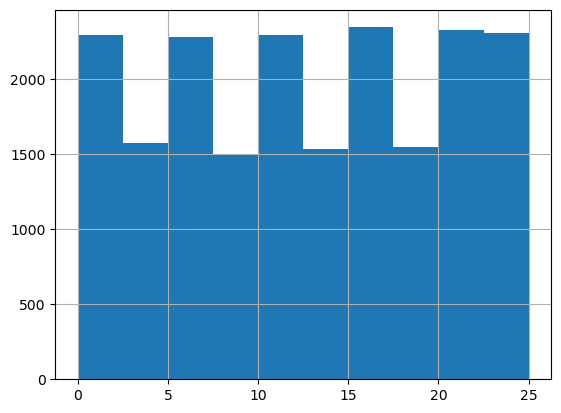

In [29]:
col = data.columns[16]
data[col].hist()

In [32]:
run_classification(data, target_col)

Accuracy: 0.92125
F1: 0.9210670105135317


C:\Users\sitao\miniconda3\envs\fed_imp\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


## Raisin

In [ ]:
normalize = True
threshold = 0.2
data = pd.read_csv("./data/raisin/Raisin_Dataset.csv", delimiter=',')
data = data.dropna()
target_col = 'Class'
data = move_target_to_end(data, target_col)
if normalize:
 	data = normalization(data, target_col)
#data[target_col].value_counts()
data[target_col] = data[target_col].map({"Kecimen": 0, "Besni": 1})
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## Dermatology

In [ ]:
normalize = True
threshold = 0.5
data = pd.read_csv("./data/dermatology/dermatology.csv", delimiter=',', na_values='?', header = None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '35'
data = move_target_to_end(data, target_col)
if normalize:
 	data = normalization(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
	'clf_type': 'multi-class'
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## Pima Indianas Diabetes

In [13]:
normalize = True
threshold = 0.1
data = pd.read_csv("./data/pima_indianas_diabetes/diabetes.csv", delimiter=',', header=0)
data['Outcome'].value_counts()
target_col = 'Outcome'

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
print(correlation_ret)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
dtype: float64
['Glucose', 'BMI', 'Age', 'Pregnancies', 'DiabetesPedigreeFunction', 'Insulin']
(768, 9)
2
Average correlation: 0.20796785112727043 0.4665813983068738
0    0.651042
1    0.348958
Name: Outcome, dtype: float64


## Telugu Vowel

In [7]:
normalize = True
threshold = 0.1

data = pd.read_csv("./data/telugu_vowel/telugu.csv", delimiter=',', header=0)
target_col = 'class'

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)

important_features = data.columns.tolist()
important_features.remove(target_col)
print(data['class'].value_counts())

1    200
2    200
3    200
4    200
5    200
6    200
Name: class, dtype: int64


## Telugu Tabular

In [4]:
normalize = True
threshold = 0.1

data = pd.read_csv("./data/telugu_tabular/telugu.csv", delimiter='\s+', header=None)
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '1'

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)
data[target_col] = pd.factorize(data[target_col])[0]

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)

important_features = data.columns.tolist()
important_features.remove(target_col)
print(data[target_col].value_counts())

1
4    207
5    180
2    172
3    151
1     89
0     72
Name: count, dtype: int64


## Wine Data

In [22]:
normalize = True
threshold = 0.1

data = pd.read_csv("./data/wine2/wine.csv", delimiter=',', header=None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '1'

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
# print(data[target_col].value_counts())

['8', '14', '13', '2', '11', '12', '7', '3', '5', '10', '9', '4', '6']


## Parkinsons

## Wifi Localization

In [12]:
normalize = True
threshold = 0.5

data = pd.read_csv("./data/wifi_localization/wifi_localization.csv", delimiter='\s+', header=None)
data = data.dropna()
# data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = 7

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)
data[target_col] = pd.factorize(data[target_col])[0]

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data[target_col].value_counts())
print(data.shape)
correlation_ret

[3, 0, 4, 5, 6, 2]
7
0    500
1    500
2    500
3    500
Name: count, dtype: int64
(2000, 8)


7    1.000000
3    0.894730
0    0.893372
4    0.880661
5    0.803960
6    0.771457
2    0.698395
1    0.170905
dtype: float64

## Adult

In [21]:
from sklearn.preprocessing import OneHotEncoder

In [28]:
normalize = True
threshold = 0.1
retain_threshold = 0.05

columns = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
	           "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
	           "Hours per week", "Country", "Target"]
types = {
    0: int, 1: str, 2: int, 3: str, 4: int, 5: str, 6: str, 7: str, 8: str, 9: str, 10: int,
    11: int, 12: int, 13: str, 14: str
}

data_train = pd.read_csv(
    "./data/adult/adult_train.csv", names=columns, na_values=['?'], sep=r'\s*,\s*', engine='python',
    dtype=types
)
data_test = pd.read_csv(
    "./data/adult/adult_test.csv", names=columns, na_values=['?'], sep=r'\s*,\s*', engine='python',
    dtype=types
)
data = pd.concat([data_train, data_test], axis=0)
data = data.dropna()
col_drop = ["Country", "Education", "fnlwgt"]
data = data.drop(col_drop, axis=1)
# target
target_col = 'Target'
data[target_col] = data[target_col].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})

# convert categorical to numerical
for col in ["Sex", "Martial Status", "Relationship", "Race",  "Workclass", "Occupation"]:
    values = data[col].value_counts().index.tolist()
    corr_y = []
    for value in values:
        corr_y_data = data[data[col] == value][target_col].value_counts(normalize=True)
        corr = corr_y_data[0]/corr_y_data[1]
        corr_y.append(corr)

    sorted_values = sorted(values, key = lambda x: corr_y[values.index(x)])
    mapping = {value: idx for idx, value in enumerate(sorted_values)}
    print(mapping)
    data[col] = data[col].map(mapping)

# one-hot encoding
# categorical_features = [
#     "Workclass", "Education", "Martial Status", "Occupation", "Relationship", "Race", "Sex", "Country"
# ]
# one_hot_encoder = OneHotEncoder(
#     categories='auto', handle_unknown='ignore', drop='first', max_categories=5
# )
# one_hot_encoder.fit(data[categorical_features])
# one_hot_encoded = one_hot_encoder.transform(data[categorical_features]).toarray()
# one_hot_encoded = pd.DataFrame(one_hot_encoded)
# data = data.drop(categorical_features, axis=1).reset_index(drop=True)
# num_cols = data.shape[1] - 1
# data = pd.concat([data, one_hot_encoded], axis=1)

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)
data[target_col] = pd.factorize(data[target_col])[0]

# # sample balance
# data_y0 = data[data[target_col] == 0]
# data_y1 = data[data[target_col] == 1]
# data_y0 = data_y0.sample(n=data_y1.shape[0], random_state=0)
# data = pd.concat([data_y0, data_y1], axis=0).reset_index(drop=True)


correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
# retained_features = correlation_ret[correlation_ret >= retain_threshold].index.tolist()
# new_cols = []
# new_num_cols = 0
# for idx, feature in enumerate(data.columns.tolist()):
#     if feature in retained_features:
#         new_cols.append(feature)
#         if idx < num_cols:
#             new_num_cols += 1

# data = data[new_cols]

important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'binary-class',
    'data_type': 'tabular'
}
correlation_ret

{'Male': 0, 'Female': 1}
{'Married-civ-spouse': 0, 'Married-AF-spouse': 1, 'Divorced': 2, 'Married-spouse-absent': 3, 'Widowed': 4, 'Separated': 5, 'Never-married': 6}
{'Wife': 0, 'Husband': 1, 'Not-in-family': 2, 'Unmarried': 3, 'Other-relative': 4, 'Own-child': 5}
{'Asian-Pac-Islander': 0, 'White': 1, 'Other': 2, 'Black': 3, 'Amer-Indian-Eskimo': 4}
{'Self-emp-inc': 0, 'Federal-gov': 1, 'Local-gov': 2, 'Self-emp-not-inc': 3, 'State-gov': 4, 'Private': 5, 'Without-pay': 6}
{'Exec-managerial': 0, 'Prof-specialty': 1, 'Protective-serv': 2, 'Tech-support': 3, 'Armed-Forces': 4, 'Sales': 5, 'Craft-repair': 6, 'Transport-moving': 7, 'Adm-clerical': 8, 'Machine-op-inspct': 9, 'Farming-fishing': 10, 'Handlers-cleaners': 11, 'Other-service': 12, 'Priv-house-serv': 13}


Target            1.000000
Martial Status    0.413213
Relationship      0.383811
Occupation        0.341454
Education-Num     0.332800
Age               0.237040
Hours per week    0.227199
Capital Gain      0.221034
Sex               0.215760
Workclass         0.150828
Capital Loss      0.148687
Race              0.096798
dtype: float64

## Default Credit

In [45]:
normalize = True
threshold = 0.1
retain_threshold = 0.1


data = pd.read_csv("./data/default_credit/default_creidt.csv")
data = data.dropna()
data = data.drop('ID', axis=1)

# target
target_col = 'default payment next month'

# convert categorical to numerical
for col in ["SEX", "MARRIAGE", "EDUCATION"]:
    values = data[col].value_counts().index.tolist()
    corr_y = []
    for value in values:
        corr_y_data = data[data[col] == value][target_col].value_counts(normalize=True)
        if corr_y_data.shape[0] == 1:
            if corr_y_data.index[0] == 0:
                corr = 0
            else:
                corr = 1e5
        else:
            corr = corr_y_data[0]/corr_y_data[1]
        
        corr_y.append(corr)

    sorted_values = sorted(values, key = lambda x: corr_y[values.index(x)])
    mapping = {value: idx for idx, value in enumerate(sorted_values)}
    print(mapping)
    data[col] = data[col].map(mapping)

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)
data[target_col] = pd.factorize(data[target_col])[0]

# # sample balance
# data_y0 = data[data[target_col] == 0]
# data_y1 = data[data[target_col] == 1]
# data_y1 = data_y1.sample(n=data_y0.shape[0], random_state=0)
# data = pd.concat([data_y0, data_y1], axis=0).reset_index(drop=True)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

retained_features = correlation_ret[correlation_ret >= retain_threshold].index.tolist()
new_cols = []
for idx, feature in enumerate(data.columns.tolist()):
    if feature in retained_features:
        new_cols.append(feature)

data = data[new_cols]

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'binary-class',
    'data_type': 'tabular'
}

correlation_ret

{1: 0, 2: 1}
{3: 0, 1: 1, 2: 2, 0: 3}
{0: 0, 3: 1, 2: 2, 1: 3, 6: 4, 5: 5, 4: 6}


default payment next month    1.000000
PAY_0                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
LIMIT_BAL                     0.153520
PAY_AMT1                      0.072929
EDUCATION                     0.068142
PAY_AMT2                      0.058579
PAY_AMT4                      0.056827
PAY_AMT3                      0.056250
PAY_AMT5                      0.055124
PAY_AMT6                      0.053183
SEX                           0.039961
MARRIAGE                      0.033213
BILL_AMT1                     0.019644
BILL_AMT2                     0.014193
BILL_AMT3                     0.014076
AGE                           0.013890
BILL_AMT4                     0.010156
BILL_AMT5                     0.006760
BILL_AMT6                     0.005372
dtype: float64

## Firewall

In [106]:
normalize = True
threshold = 0.1
retain_threshold = 0.1


data = pd.read_csv("./data/firewall/log2.csv")
data = data[data['Action'] != 'reset-both']
target_col = 'Action'
data[target_col] = pd.factorize(data[target_col])[0]
data = data.dropna()
source_freq = data['Source Port'].value_counts(normalize=True)
source_freq.name = 'source_freq'
destination_freq = data['Destination Port'].value_counts(normalize=True)
destination_freq.name = 'destination_freq'
nat_source_freq = data['NAT Source Port'].value_counts(normalize=True)
nat_source_freq.name = 'nat_source_freq'
nat_destination_freq = data['NAT Destination Port'].value_counts(normalize=True)
nat_destination_freq.name = 'nat_destination_freq'

data = data.merge(source_freq, how = 'left', left_on='Source Port', right_index=True)
data = data.merge(destination_freq, how = 'left', left_on='Destination Port', right_index=True)
data = data.merge(nat_source_freq, how = 'left', left_on='NAT Source Port', right_index=True)
data = data.merge(nat_destination_freq, how = 'left', left_on='NAT Destination Port', right_index=True)
data['sd_pair'] = data[['Source Port', 'Destination Port']].apply(lambda x: tuple(x), axis=1)
data['nat_sd_pair'] = data[['NAT Source Port', 'NAT Destination Port']].apply(lambda x: tuple(x), axis=1)
sd_pair_freq = data['sd_pair'].value_counts(normalize=True)
sd_pair_freq.name = 'sd_pair_freq'
nat_sd_pair_freq = data['nat_sd_pair'].value_counts(normalize=True)
nat_sd_pair_freq.name = 'nat_sd_pair_freq'
data = data.merge(sd_pair_freq, how = 'left', left_on='sd_pair', right_index=True)
data = data.merge(nat_sd_pair_freq, how = 'left', left_on='nat_sd_pair', right_index=True)

data = data.drop([
    'sd_pair', 'nat_sd_pair', 'Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port'
    ], axis=1)

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)

# # # sample balance
# # data_y0 = data[data[target_col] == 0]
# # data_y1 = data[data[target_col] == 1]
# # data_y1 = data_y1.sample(n=data_y0.shape[0], random_state=0)
# # data = pd.concat([data_y0, data_y1], axis=0).reset_index(drop=True)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}
print(data.shape)
correlation_ret

(65478, 14)


Action                  1.000000
nat_sd_pair_freq        0.982195
nat_source_freq         0.982195
nat_destination_freq    0.886994
destination_freq        0.714055
sd_pair_freq            0.200021
Elapsed Time (sec)      0.187267
source_freq             0.180081
Bytes Received          0.026105
pkts_received           0.023785
Packets                 0.017074
Bytes                   0.014861
pkts_sent               0.010798
Bytes Sent              0.005014
dtype: float64

In [105]:
run_classification(data, target_col=target_col)

Accuracy: 0.9980146609651802
F1: 0.99801223267393


## Dry Bean

In [103]:
normalize = True
threshold = 0.1
retain_threshold = 0.1

data = pd.read_excel("./data/dry_bean/Dry_Bean_Dataset.xlsx")
target_col = 'Class'
# data = data[data['Action'] != 'reset-both']
# target_col = 'Action'
data[target_col] = pd.factorize(data[target_col])[0]
data = data.dropna()
data = data.drop(['Extent', 'Solidity', 'ShapeFactor4', 'roundness'], axis=1)

# convert columns to gaussian
data = convert_gaussian(data, target_col)

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}
print(data.shape)
correlation_ret

(13611, 13)


Class              1.000000
MajorAxisLength    0.931274
Perimeter          0.930830
ShapeFactor2       0.928938
ConvexArea         0.922399
EquivDiameter      0.921556
Area               0.921539
Compactness        0.904610
ShapeFactor3       0.904537
AspectRation       0.902179
Eccentricity       0.900969
MinorAxisLength    0.898471
ShapeFactor1       0.896564
dtype: float64

In [102]:
data[target_col].value_counts()

Class
6    3546
5    2636
0    2027
4    1928
3    1630
1    1322
2     522
Name: count, dtype: int64

In [82]:
run_classification(data, target_col)

Accuracy: 0.9155343371281675
F1: 0.9156577273371562


## CodRNA

In [10]:
from sklearn.datasets import fetch_openml
normalize = True
threshold = 0.1
sample_balance = False
gaussian = True
data_obj = fetch_openml(data_id = 351, as_frame='auto', parser = 'auto')
X = pd.DataFrame(data_obj.data.todense(), columns=data_obj.feature_names)
y = pd.DataFrame(data_obj.target, columns = data_obj.target_names)
data = pd.concat([X, y], axis=1)

target_col = 'Y'
data[target_col] = pd.factorize(data[target_col])[0]
data = data.dropna()

if gaussian:
    data = convert_gaussian(data, target_col)

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

if sample_balance:
    data_y0 = data[data[target_col] == 0]
    data_y1 = data[data[target_col] == 1]
    data_y0 = data_y0.sample(n=data_y1.shape[0], random_state=0)
    data = pd.concat([data_y0, data_y1], axis=0).reset_index(drop=True)

data = data.sample(n = 50000).reset_index(drop=True)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'binary-class',
    'data_type': 'tabular'
}
print(data.shape)
print(data['Y'].value_counts())
correlation_ret

(50000, 9)
Y
0    33304
1    16696
Name: count, dtype: int64


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


Y     1.000000e+00
X1    5.213973e-01
X8    6.349164e-16
X3    5.801881e-16
X4    4.278746e-16
X5    3.654741e-16
X2    2.432693e-16
X6    0.000000e+00
X7    0.000000e+00
dtype: float64

In [90]:
run_classification(data, target_col)

X_train shape: (40000, 8)
Accuracy: 0.9624
F1: 0.9624875074444895
Recall: 0.9624
Precision: 0.9626570840059854
Accuracy: 0.9498
F1: 0.9498230386435629
Recall: 0.9498
Precision: 0.9498491219318055


In [91]:
run_classification(data, target_col, smote = True)

X_train shape: (53454, 8)
Accuracy: 0.9604
F1: 0.9607156396616993
Recall: 0.9604
Precision: 0.962096027208788
Accuracy: 0.9461
F1: 0.946612933766978
Recall: 0.9461
Precision: 0.9486648252428673


## Bank Marketing

In [87]:
threshold = 0.1
normalize = True
data = pd.read_csv("./data/bank_market/bank-full.csv", sep=';')
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
for col in cat_cols:
    data[col] = pd.factorize(data[col])[0]
target_col = 'y'
# target_col = 'Y'
data[target_col] = pd.factorize(data[target_col])[0]
data = data.dropna()

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)

# sample balance
# data_y0 = data[data[target_col] == 0]
# data_y1 = data[data[target_col] == 1]
# data_y0 = data_y0.sample(n=data_y1.shape[0], random_state=0)
# data = pd.concat([data_y0, data_y1], axis=0).reset_index(drop=True)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'binary-class',
    'data_type': 'tabular'
}

correlation_ret

y            1.000000
duration     0.394521
poutcome     0.259315
month        0.166663
housing      0.139173
contact      0.130590
pdays        0.103621
previous     0.093236
campaign     0.073172
loan         0.068185
education    0.058675
balance      0.052838
marital      0.043846
day          0.028348
age          0.025155
default      0.022419
job          0.022396
dtype: float64

In [88]:
data[target_col].value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

## IJCNN

In [127]:
from sklearn.datasets import fetch_openml
normalize = True
data_obj = fetch_openml(data_id = 1575, as_frame='auto', parser = 'auto')
X = pd.DataFrame(data_obj.data.todense(), columns=data_obj.feature_names)
y = pd.DataFrame(data_obj.target, columns = data_obj.target_names)
data = pd.concat([X, y], axis=1)

target_col = 'class'
data[target_col] = pd.factorize(data[target_col])[0]
data = data.dropna()
pca = PCA(n_components=20)
pca.fit(data.iloc[:, :-1])
data_pca = pca.transform(data.iloc[:, :-1])
data_pca = pd.DataFrame(data_pca)
data_pca = pd.concat([data_pca, data[target_col]], axis=1)
data = data_pca

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

correlation_ret

class    1.000000
18       0.298654
16       0.212200
15       0.208563
14       0.128144
11       0.065834
12       0.052288
13       0.048484
4        0.035952
3        0.023617
1        0.018933
2        0.018033
19       0.016998
10       0.011122
0        0.004583
9        0.003706
6        0.003395
17       0.001930
8        0.001557
7        0.001446
5        0.000067
dtype: float64

In [84]:
data[target_col].value_counts()

class
0    173263
1     18418
Name: count, dtype: int64

## Skin

In [94]:
from sklearn.datasets import fetch_openml

data_obj = fetch_openml(data_id = 1502, as_frame='auto', parser = 'auto')
X = pd.DataFrame(data_obj.data, columns=data_obj.feature_names)
y = pd.DataFrame(data_obj.target, columns = data_obj.target_names)
data = pd.concat([X, y], axis=1)


target_col = 'Class'
data[target_col] = pd.factorize(data[target_col])[0]
data = data.dropna()

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data = data.sample(n = 50000).reset_index(drop=True)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

correlation_ret

Class    1.000000
V3       0.569958
V2       0.120327
V1       0.092030
dtype: float64

In [95]:
data[target_col].value_counts()

Class
1    39614
0    10386
Name: count, dtype: int64

In [96]:
run_classification(data, target_col)

X_train shape: (40000, 3)
Accuracy: 0.9985
F1: 0.9985004028764377
Recall: 0.9985
Precision: 0.9985010793406389
Accuracy: 0.9221
F1: 0.9224766927240715
Recall: 0.9221
Precision: 0.9229297172505674


In [97]:
run_classification(data, target_col, smote=True)

X_train shape: (63356, 3)
Accuracy: 0.9986
F1: 0.9986007512481622
Recall: 0.9986
Precision: 0.9986025959025532
Accuracy: 0.9325
F1: 0.9350187680221524
Recall: 0.9325
Precision: 0.9431570032626004


## SVM guide1

In [11]:
threshold = 0.1
normalize = True
data_train = pd.read_csv("./data/svm1/svm_p.csv", sep=',', header = None)
data_test = pd.read_csv("./data/svm1/svm_pt.csv", sep=',', header = None)
data = pd.concat([data_train, data_test], axis=0).reset_index(drop=True)
data = data.dropna()
data.columns = [str(i) for i in range(data.shape[1])]
target_col = '0'
data[target_col] = pd.factorize(data[target_col])[0]

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)


correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'binary-class',
    'data_type': 'tabular'
}

correlation_ret

0    1.000000
2    0.679235
4    0.533025
1    0.527964
3    0.233265
dtype: float64

## Pendigits

In [19]:
threshold = 0.1
normalize = True
data_train = pd.read_csv("./data/pendigits/pendigits.tra", sep=',', header=None)
data_test = pd.read_csv("./data/pendigits/pendigits.tes", sep=',', header=None)
data = pd.concat([data_train, data_test], axis=0).reset_index(drop=True)
data = data.dropna()
data.columns = [str(i) for i in range(data.shape[1])]
target_col = '16'
data[target_col] = pd.factorize(data[target_col])[0]

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)

data = convert_gaussian(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

print(data.shape)
correlation_ret

(10992, 17)


16    1.000000
15    0.849678
13    0.820472
4     0.781146
7     0.772960
5     0.769259
10    0.757793
8     0.734025
11    0.731596
9     0.721901
14    0.721614
0     0.717654
1     0.659020
3     0.644406
6     0.611788
2     0.507330
12    0.459465
dtype: float64

In [18]:
run_classification(data, target_col=target_col)

Accuracy: 0.992269213278763
F1: 0.9922820660818847


## statlog

In [5]:
threshold = 0.1
normalize = True
data_train = pd.read_csv("./data/statlog/shuttle.trn.trn", sep='\s+', header=None)
data_test = pd.read_csv("./data/statlog/shuttle.tst.tst", sep='\s+', header=None)
data = pd.concat([data_train, data_test], axis=0).reset_index(drop=True)

data = data.dropna()
data.columns = [str(i) for i in range(data.shape[1])]
target_col = '9'
data[target_col] = pd.factorize(data[target_col])[0]

# sample balance
data = data[data[target_col].isin([2,1,3])]
data_rest = data[data[target_col].isin([1,3])]
data_more = data[data[target_col].isin([2])]
data_more = data_more.sample(n=data_rest.shape[0], random_state=42)
data = pd.concat([data_rest, data_more], axis=0).reset_index(drop=True)

data = move_target_to_end(data, target_col)

if normalize:
    data = normalization(data, target_col)

# #data = convert_gaussian(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

print(data.shape)
print(data[target_col].value_counts())
correlation_ret

(24340, 10)
9
2    12170
1     8903
3     3267
Name: count, dtype: int64


9    1.000000
0    0.918795
6    0.812970
8    0.771910
7    0.558087
4    0.443462
2    0.202672
1    0.054291
3    0.013202
5    0.004803
dtype: float64

In [32]:
run_classification(data, target_col=target_col)

Accuracy: 0.9990517241379311
F1: 0.999135039673383


## Avila

In [63]:
threshold = 0.1
normalize = True
data_train = pd.read_csv("./data/avila/avila-tr.txt", sep=',', header=None)
data_test = pd.read_csv("./data/avila/avila-ts.txt", sep=',', header=None)
data = pd.concat([data_train, data_test], axis=0).reset_index(drop=True)

data = data.dropna()
data.columns = [str(i) for i in range(data.shape[1])]
target_col = '10'
data = data[data[target_col].isin(['A', 'F', 'E', 'I', 'X', 'H', 'G', 'D'])]
data[target_col] = pd.factorize(data[target_col])[0]
data = move_target_to_end(data, target_col)

if normalize:
    data = normalization(data, target_col)

# #data = convert_gaussian(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

print(data.shape)
print(data[target_col].value_counts())
correlation_ret

(20029, 11)
10
0    8572
1    3923
3    2190
4    1663
6    1044
2    1039
7     893
5     705
Name: count, dtype: int64


10    1.000000
8     0.439498
3     0.316348
5     0.312607
6     0.311208
4     0.243893
0     0.234072
9     0.224227
7     0.167128
2     0.111404
1     0.055065
dtype: float64

In [64]:
run_classification(data, target_col=target_col)

Accuracy: 0.7983025461807289
F1: 0.7927764026641473


## SUSY

In [92]:
threshold = 0.1
normalize = True
data = pd.read_csv("./data/susy/SUSY.csv", sep=',', header=None)

data = data.dropna()
data.columns = [str(i) for i in range(data.shape[1])]
target_col = '0'
data[target_col] = pd.factorize(data[target_col])[0]
data[target_col].value_counts()

data = data.sample(frac = 0.01, random_state=42)

if normalize:
    data = normalization(data, target_col)

# #data = convert_gaussian(data, target_col)
data = move_target_to_end(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'binary-class',
    'data_type': 'tabular'
}

print(data.shape)
print(data[target_col].value_counts())
correlation_ret

(50000, 19)
0
0    27237
1    22763
Name: count, dtype: int64


0     1.000000
7     0.439508
12    0.426846
1     0.395619
9     0.285267
16    0.280535
18    0.272013
11    0.269359
15    0.260561
4     0.196171
13    0.112637
14    0.085809
10    0.073441
17    0.031605
3     0.002636
5     0.001936
6     0.001268
8     0.000587
2     0.000554
dtype: float64

In [94]:
run_classification(data, target_col=target_col)

Accuracy: 0.7984
F1: 0.7951374819022355


## Higgs

In [105]:
threshold = 0.1
normalize = True
data = pd.read_csv("./data/higgs/higgs_new.csv", sep=',')

data = data.dropna()
target_col = '0'
# #data = convert_gaussian(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'binary-class',
    'data_type': 'tabular'
}

print(data.shape)
print(data[target_col].value_counts())
correlation_ret

(55000, 29)
0
0    29133
1    25867
Name: count, dtype: int64


0     1.000000
26    0.151953
28    0.117370
4     0.096404
6     0.060735
27    0.058519
13    0.054225
1     0.039663
18    0.032394
25    0.025057
23    0.024172
17    0.021704
10    0.017418
22    0.011538
24    0.011117
14    0.010538
21    0.008518
3     0.006377
8     0.004684
7     0.003358
12    0.003331
9     0.002967
2     0.001678
15    0.001449
19    0.001385
20    0.000977
16    0.000642
5     0.000269
11    0.000247
dtype: float64

## Accel

In [104]:
threshold = 0.1
normalize = True
data = pd.read_csv("./data/accelerometer/accelerometer_gyro_mobile.csv", sep=',')

data = data.dropna()
#data.columns = [str(i) for i in range(data.shape[1])]
data.head()
target_col = 'Activity'
data[target_col] = pd.factorize(data[target_col])[0]
data[target_col].value_counts()

# data = data.sample(frac = 0.01, random_state=42)

# if normalize:
#     data = normalization(data, target_col)

# # #data = convert_gaussian(data, target_col)
# data = move_target_to_end(data, target_col)

# correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
# important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
# important_features.remove(target_col)

# data_config = {
#     'target': target_col,
#     'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
#     'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
#     "num_cols": data.shape[1] - 1,
#     'task_type': 'classification',
#     'clf_type': 'binary-class',
#     'data_type': 'tabular'
# }

# print(data.shape)
# print(data[target_col].value_counts())
# correlation_ret

Activity
0    31420
1      571
Name: count, dtype: int64

## NHIS

In [7]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA


In [32]:
data_folder = 'data/NHIS/'
paths = {
    'family': data_folder+'familyxx.csv',
    'child': data_folder+'samchild.csv',
    'adult': data_folder+'samadult.csv',
    'person': data_folder+'personsx.csv',
    'household': data_folder+'househld.csv',
    'injury': data_folder+'injpoiep.csv',
    'X_income': data_folder+'custom/X_income.csv',
}
sep = ','

household = pd.read_csv(paths['household'], sep=sep)
adult = pd.read_csv(paths['adult'], sep=sep)
family = pd.read_csv(paths['family'], sep=sep)
person = pd.read_csv(paths['person'], sep=sep)

# Merge dataframes
df = household.merge(family, how='inner', on=['SRVY_YR', 'HHX'],
        suffixes=('', '%to_drop')
    ).merge(
        person, how='inner', on=['SRVY_YR', 'HHX', 'FMX'],
        suffixes=('', '%to_drop')
    ).merge(
        adult, how='inner', on=['SRVY_YR', 'HHX', 'FMX', 'FPX'],
        suffixes=('', '%to_drop')
    ).dropna(subset=['ERNYR_P'])

df = df.loc[:, ~df.columns.str.endswith('%to_drop')]
df['IDX'] = df.index
df.head()
print("Shape of raw data: ", df.shape)
df = df.reset_index(drop=True)

###########################################################################
# Target
###########################################################################
target_col = 'ERNYR_P'
df[target_col] = df[target_col].map(lambda x: x if x < 90 else np.nan)
df.dropna(subset=['ERNYR_P'], inplace=True)
df[target_col] = df[target_col].map(lambda x: 1 if x > 6 else 0)
df = move_target_to_end(df, target_col)
df[target_col] = pd.factorize(df[target_col])[0]

###########################################################################
# drop columns with unique values and many values
###########################################################################
unique_cols = []
for column in adult.columns:
    if df[column].nunique() == 1:
        unique_cols.append(column)

df.drop(unique_cols, axis=1, inplace=True)
print("Shape of data after dropping columns only contains one value: ", df.shape)

# drop columns with too many values
many_values_cols = []
for column in df.columns:
    if df[column].nunique()/df.shape[0] > 0.7:
        many_values_cols.append(column)

df.drop(many_values_cols, axis=1, inplace=True)
print("Shape of data after dropping high cardinality columns: ", df.shape)

###########################################################################
# drop missing values
###########################################################################
ms_pct = df.isnull().sum()/adult.shape[0]
ms_thres = 0.0
ms_cols = ms_pct[ms_pct > ms_thres].index.tolist()
df = df.drop(columns=ms_cols)
df = df.dropna(how = 'any')
print("Shape of data remove columns with missing values: ", df.shape)

# numerical columns
numerical_cols = [col for col in df.columns if col.startswith('WT')]
print(numerical_cols)

###########################################################################
# Feature selection
###########################################################################
cat_cols = [col for col in df.columns if col not in numerical_cols and col != target_col]
mi = mutual_info_classif(
    X = df[cat_cols], y = df[target_col], random_state = 42, discrete_features=True
)

num_features = 10
corr_mi = pd.Series(mi)
corr_mi.index = cat_cols
features = corr_mi.sort_values(ascending=False)[0:num_features].index.tolist()
print(features)
###########################################################################
# one-hot encoding
###########################################################################
oh = OneHotEncoder(sparse_output=False, drop = 'first', max_categories = 15, handle_unknown='ignore')
X = df[features]
X_cat = oh.fit_transform(X)
X_cat = pd.DataFrame(X_cat)
print(X_cat.shape)

###########################################################################
# final df
###########################################################################
y = df[target_col].reset_index(drop = True)
X_num = df[numerical_cols].reset_index(drop = True)
print(X_cat.shape, X_num.shape, y.shape)
df_new = pd.concat([X_cat, y], axis=1)
df_new.columns = df_new.columns.astype(str)

###########################################################################
# PCA
###########################################################################
pca = PCA(n_components = 30, random_state=42, svd_solver='auto')
X = df_new.drop([target_col], axis=1)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

df_new = pd.concat([pd.DataFrame(X_pca), df_new[target_col]], axis=1)

###########################################################################
# Normalization
###########################################################################
df_new = convert_gaussian(df_new, target_col)
df_new = normalization(df_new, target_col)
data = df_new.copy()

###########################################################################
# Correlation
###########################################################################
threshold = 0.1
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

#df_new = df_new[important_features + [target_col]]

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}
print(data.shape)
correlation_ret

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
(14585, 30)
(14585, 31)


ERNYR_P    1.000000
0          0.435411
1          0.370548
24         0.268693
5          0.211013
15         0.210014
20         0.145068
3          0.142882
9          0.108909
2          0.095234
4          0.092712
21         0.089733
7          0.085167
19         0.069649
27         0.061809
6          0.057093
22         0.055687
18         0.049325
11         0.047530
13         0.044692
17         0.043795
25         0.038313
28         0.028791
8          0.024007
23         0.022297
26         0.014367
29         0.013101
10         0.011634
16         0.011537
12         0.006816
14         0.000082
dtype: float64

In [152]:
data_folder = 'data/NHIS/'
paths = {
    'family': data_folder+'familyxx.csv',
    'child': data_folder+'samchild.csv',
    'adult': data_folder+'samadult.csv',
    'person': data_folder+'personsx.csv',
    'household': data_folder+'househld.csv',
    'injury': data_folder+'injpoiep.csv',
    'X_income': data_folder+'custom/X_income.csv',
}
sep = ','

household = pd.read_csv(paths['household'], sep=sep)
adult = pd.read_csv(paths['adult'], sep=sep)
family = pd.read_csv(paths['family'], sep=sep)
person = pd.read_csv(paths['person'], sep=sep)

# Merge dataframes
df = household.merge(family, how='inner', on=['SRVY_YR', 'HHX'],
        suffixes=('', '%to_drop')
    ).merge(
        person, how='inner', on=['SRVY_YR', 'HHX', 'FMX'],
        suffixes=('', '%to_drop')
    ).merge(
        adult, how='inner', on=['SRVY_YR', 'HHX', 'FMX', 'FPX'],
        suffixes=('', '%to_drop')
    ).dropna(subset=['ERNYR_P'])

df = df.loc[:, ~df.columns.str.endswith('%to_drop')]
df['IDX'] = df.index
df.head()
print("Shape of raw data: ", df.shape)
df = df.reset_index(drop=True)

###########################################################################
# Target
###########################################################################
target_col = 'ERNYR_P'
df[target_col] = df[target_col].map(lambda x: x if x < 90 else np.nan)
df.dropna(subset=['ERNYR_P'], inplace=True)
df[target_col] = df[target_col].map(lambda x: 1 if x > 6 else 0)
df = move_target_to_end(df, target_col)
df[target_col] = pd.factorize(df[target_col])[0]

###########################################################################
# drop columns with unique values and many values
###########################################################################
unique_cols = []
for column in adult.columns:
    if df[column].nunique() == 1:
        unique_cols.append(column)

df.drop(unique_cols, axis=1, inplace=True)
print("Shape of data after dropping columns only contains one value: ", df.shape)

# drop columns with too many values
many_values_cols = []
for column in df.columns:
    if df[column].nunique()/df.shape[0] > 0.7:
        many_values_cols.append(column)

df.drop(many_values_cols, axis=1, inplace=True)
print("Shape of data after dropping high cardinality columns: ", df.shape)

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)


In [155]:
ms = df.isnull().sum()/df.shape[0]
ms[ms > 0]

NON_INTV    1.000000
CURWRKN     0.009325
WRKCELN     0.058485
PHONEUSE    0.699486
FSSKIP      0.861776
              ...   
YTQ_MDY1    0.827220
YTQ_BTT1    0.984985
YTQ_MDT1    0.984985
YTQ_BTQ1    0.993966
YTQ_MDQ1    0.993966
Length: 984, dtype: float64

In [157]:
msk = pd.isna(df)

In [173]:
msk.shape

(14585, 1390)

In [175]:
def get_pattern(row):
    return ''.join([str(int(i)) for i in row])

pattern = msk.apply(lambda row: get_pattern(row), axis=1)

In [169]:
dict = {}

for item in pattern:
    if item not in dict:
        dict[item] = 1
    else:
        dict[item] += 1

In [179]:
dict.values()

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [180]:
df['AGE_CHG']

0       NaN
2       NaN
4       NaN
5       NaN
6       NaN
         ..
16863   NaN
16864   NaN
16865   NaN
16866   NaN
16867   NaN
Name: AGE_CHG, Length: 14585, dtype: float64

In [33]:
df_new.corr()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,ERNYR_P
0,1.000000,0.041388,0.133851,-0.017487,-0.014966,-0.035246,-0.010445,0.039838,0.017032,0.040222,...,0.068740,-0.009177,0.015678,0.162962,0.068938,0.014285,0.026908,0.003770,-0.000587,0.435411
1,0.041388,1.000000,0.018735,-0.016131,-0.017559,-0.011517,-0.018780,-0.011409,-0.010864,0.011611,...,-0.103292,0.017363,-0.022459,-0.275118,-0.053326,-0.027977,-0.042073,-0.007038,0.005325,-0.370548
2,0.133851,0.018735,1.000000,-0.100259,-0.145032,-0.182755,-0.054377,0.058130,0.022016,0.002518,...,0.015858,-0.010271,-0.010832,-0.020405,0.045692,-0.000541,0.005314,-0.007600,-0.005418,-0.095234
3,-0.017487,-0.016131,-0.100259,1.000000,0.031813,0.023068,-0.024001,0.000331,0.000527,-0.003877,...,0.003823,0.002183,-0.003117,0.025961,-0.022520,-0.012269,0.019670,0.002075,-0.099302,0.142882
4,-0.014966,-0.017559,-0.145032,0.031813,1.000000,0.008459,-0.007442,0.001148,0.004803,0.011857,...,0.025331,-0.002685,0.055030,0.027481,-0.037792,0.016981,-0.010185,0.001905,0.072496,0.092712
5,-0.035246,-0.011517,-0.182755,0.023068,0.008459,1.000000,0.003264,0.002176,0.023745,0.032862,...,0.036159,-0.005316,-0.054392,0.117299,-0.015542,-0.022233,0.057103,0.007850,0.002870,0.211013
6,-0.010445,-0.018780,-0.054377,-0.024001,-0.007442,0.003264,1.000000,0.000797,-0.001707,0.039502,...,0.004221,-0.001153,0.016216,-0.034693,0.003320,0.000817,-0.029462,-0.005545,-0.012839,0.057093
7,0.039838,-0.011409,0.058130,0.000331,0.001148,0.002176,0.000797,1.000000,0.003966,0.037715,...,-0.034093,0.004145,-0.008328,-0.106475,0.009379,-0.003684,-0.020991,-0.004551,-0.010313,-0.085167
8,0.017032,-0.010864,0.022016,0.000527,0.004803,0.023745,-0.001707,0.003966,1.000000,-0.008062,...,-0.004644,-0.002025,0.004681,-0.074802,-0.001038,-0.006407,-0.150491,-0.022448,-0.022489,-0.024007
9,0.040222,0.011611,0.002518,-0.003877,0.011857,0.032862,0.039502,0.037715,-0.008062,1.000000,...,0.034980,-0.008055,0.006413,0.022794,-0.008286,-0.003303,-0.079999,-0.013594,-0.007894,-0.108909


In [31]:
run_classification(df_new, target_col)

Accuracy: 0.8347617415152554
F1: 0.8332792037294097
Accuracy: 0.8344189235515941
F1: 0.8329457072990593


In [20]:
data = df_new
X_train, X_test, y_train, y_test = train_test_split(data.drop(target_col, axis=1), data[target_col], test_size=0.2, random_state=42)

clf = LogisticRegression(C = 5, penalty = 'l2', solver = 'liblinear', max_iter = 1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accu = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy: {}".format(accu))
print("F1: {}".format(f1))

Accuracy: 0.8234487487144326
F1: 0.822629826440002


In [291]:
run_regression(df_new, target_col)

RMSE: 4.43498195073444
R2: 0.5495697576990738


## Covid Data

In [45]:
data = pd.read_csv('data/covid/Covid Data.csv')
print(data.shape)
df = data

# preprocessing
df = df[(df.PNEUMONIA == 1) | (df.PNEUMONIA == 2)]
df = df[(df.DIABETES == 1) | (df.DIABETES == 2)]
df = df[(df.COPD == 1) | (df.COPD == 2)]
df = df[(df.ASTHMA == 1) | (df.ASTHMA == 2)]
df = df[(df.INMSUPR == 1) | (df.INMSUPR == 2)]
df = df[(df.HIPERTENSION == 1) | (df.HIPERTENSION == 2)]
df = df[(df.OTHER_DISEASE == 1) | (df.OTHER_DISEASE == 2)]
df = df[(df.CARDIOVASCULAR == 1) | (df.CARDIOVASCULAR == 2)]
df = df[(df.OBESITY == 1) | (df.OBESITY == 2)]
df = df[(df.RENAL_CHRONIC == 1) | (df.RENAL_CHRONIC == 2)]
df = df[(df.TOBACCO == 1) | (df.TOBACCO == 2)]

print(df.shape)

df["DEATH"] = [2 if each=="9999-99-99" else 1 for each in df.DATE_DIED]
df.PREGNANT = df.PREGNANT.replace(97,2)

# Getting rid of the missing values
df = df[(df.PREGNANT == 1) | (df.PREGNANT == 2)]
print(df.shape)
df.drop(columns=["INTUBED","ICU","DATE_DIED"], inplace=True)
unrelevant_columns = ["SEX","PREGNANT","COPD","ASTHMA","INMSUPR","OTHER_DISEASE","CARDIOVASCULAR",
                      "OBESITY","TOBACCO"]

df.drop(columns=unrelevant_columns,inplace=True)
print(df.shape)
df = pd.get_dummies(df,columns=["MEDICAL_UNIT","CLASIFFICATION_FINAL"],drop_first=True)
print(df.shape)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df.AGE = scaler.fit_transform(df.AGE.values.reshape(-1,1))

x = df.drop(columns="DEATH")
y = df["DEATH"]

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.2, random_state=42)
print("Train_x :",train_x.shape)
print("Test_x :",test_x.shape)
print("Train_y :",train_y.shape)
print("Test_y :",test_y.shape)

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_x,train_y)
print("Logistic Regression Accuracy :",logreg.score(test_x, test_y))

(1048575, 21)
(1025152, 21)
(1021977, 22)
(1021977, 10)
(1021977, 26)
Train_x : (817581, 25)
Test_x : (204396, 25)
Train_y : (817581,)
Test_y : (204396,)
Logistic Regression Accuracy : 0.9394068377071958


d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Heart

In [11]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [12]:
threshold = 0.1
df = pd.read_csv('./data/heart/heart_2020_cleaned.csv')
target_col = 'HeartDisease'
df['HeartDisease'] = df['HeartDisease'].map({"No": 0, "Yes": 1})
df[target_col].value_counts()
df = move_target_to_end(df, target_col)

categorical_columns = [
    'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 
    'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 
    'Asthma', 'KidneyDisease', 'SkinCancer'
]

numerical_cols = [col for col in df.columns if col not in categorical_columns and col != target_col]
print(numerical_cols)
oh_encoder = OneHotEncoder(max_categories=10, drop='first', sparse_output = False)
X_cat = oh_encoder.fit_transform(df[categorical_columns])
X_num = df[numerical_cols].values
robust_scaler = MinMaxScaler()
X_num = robust_scaler.fit_transform(df[numerical_cols])
X = np.concatenate([X_num, X_cat], axis=1)

# # print(df_new.shape)
# # label=LabelEncoder()
# # for col in df:
# #     df[col]=label.fit_transform(df[col])
# # under = RandomUnderSampler(random_state=42)
# # X = df.drop(target_col, axis=1).values
# # X_new, y_new = under.fit_resample(X, df[target_col].values)

# pca
pca = PCA(n_components=0.95)
X_new = pca.fit_transform(X)
y_new = df[target_col].values

# new dataframe
df_new = pd.DataFrame(np.concatenate([X_new, y_new.reshape(-1, 1)], axis=1))
df_new.columns = df_new.columns.astype(str)

target_col = df_new.columns[-1]
df_new = move_target_to_end(df_new, target_col)
df_new[target_col] = pd.factorize(df_new[target_col])[0]
df_new = convert_gaussian(df_new, target_col)
df_new = normalization(df_new, target_col)
print(df_new.shape)

data = df_new

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data0 = data[data[target_col] == 0]
data1 = data[data[target_col] == 1]
data0 = data0.sample(frac = 0.1, random_state=42)
data1 = data1.sample(frac = 0.1, random_state=42)
data = pd.concat([data0, data1], axis=0)

print(data.shape)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

correlation_ret

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(31979, 25)


24    1.000000
0     0.207134
1     0.186029
4     0.122987
8     0.108366
21    0.086931
9     0.080964
7     0.047522
12    0.042697
6     0.041534
17    0.034764
23    0.032861
2     0.032162
13    0.031752
19    0.029506
3     0.029063
5     0.025317
20    0.011881
22    0.011598
16    0.010384
15    0.005944
10    0.004127
14    0.002325
11    0.002092
18    0.000368
dtype: float64

In [13]:
data[target_col].value_counts()

24
0    29242
1     2737
Name: count, dtype: int64

In [74]:
run_classification(data, target_col)

X_train shape: (25583, 24)


Accuracy: 0.8941525953721076
F1: 0.8813880962041727
Recall: 0.8941525953721076
Precision: 0.8716941792663454
Accuracy: 0.9155722326454033
F1: 0.8856713141462089
Recall: 0.9155722326454033
Precision: 0.8835881123074507


In [73]:
run_classification(data, target_col, smote=True)

X_train shape: (46764, 24)
Accuracy: 0.7947154471544715
F1: 0.8292615466125466
Recall: 0.7947154471544715
Precision: 0.879426235157263
Accuracy: 0.7537523452157598
F1: 0.8060599394982866
Recall: 0.7537523452157598
Precision: 0.908804194689638


## Codon

In [3]:
threshold = 0.1
normalize = True
data = pd.read_csv("./data/codon/codon_usage.csv", sep=',', low_memory=False)

data = data.dropna()
#data.columns = [str(i) for i in range(data.sh
data = data.drop(['SpeciesID', 'Ncodons', 'SpeciesName', 'DNAtype'], axis=1)
target_col = 'Kingdom'
data = data[data[target_col] != 'plm']
data[target_col], codes = pd.factorize(data[target_col])
data = move_target_to_end(data, target_col)
data = normalization(data, target_col)

# pca
pca = PCA(n_components=0.9)
X = pca.fit_transform(data.drop(target_col, axis=1).values)
y = data[target_col].values

# new dataframe
df_new = pd.DataFrame(np.concatenate([X, y.reshape(-1, 1)], axis=1))
df_new.columns = df_new.columns.astype(str)

target_col = df_new.columns[-1]
data = df_new
print(data.shape)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

correlation_ret

(13008, 26)


25    1.000000
1     0.809629
2     0.482846
3     0.479401
5     0.413096
4     0.381907
6     0.377165
0     0.328057
8     0.326848
9     0.321669
11    0.230435
14    0.218299
23    0.204808
22    0.198285
18    0.194682
19    0.183893
10    0.183041
17    0.182647
7     0.173197
13    0.166827
21    0.166662
15    0.161502
24    0.158178
16    0.148523
12    0.140533
20    0.127572
dtype: float64

In [5]:
data[target_col].value_counts().shape

(10,)

In [36]:
run_classification(data, target_col, smote=False)

X_train shape: (10420, 25)
Accuracy: 0.9067536454336147
F1: 0.905530256783151
Recall: 0.9067536454336147
Precision: 0.9061162485217039
Accuracy: 0.7659247889485802
F1: 0.7442017922921907
Recall: 0.7659247889485802
Precision: 0.752135082437742


d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Sepsis

In [162]:
data = pd.read_csv('./data/sepsis/sepsis_survival_primary_cohort.csv')
data = data.dropna()
target_col = 'hospital_outcome_1alive_0dead'
data[target_col] = data[target_col].astype(int)
data = convert_gaussian(data, target_col)
data = normalization(data, target_col)

# sample balanced
data0 = data[data[target_col] == 0]
data1 = data[data[target_col] == 1]
if data0.shape[0] > data1.shape[0]:
    data0 = data0.sample(n = data1.shape[0])
else:
    data1 = data1.sample(n = data0.shape[0])

data = pd.concat([data0, data1], axis=0)
print(data.shape)
# pca = PCA(n_components=0.9)
# X = pca.fit_transform(data.iloc[:, :-1].values)
# data = pd.DataFrame(np.concatenate([X, data.iloc[:, -1].values.reshape(-1, 1)], axis=1))
# target_col = data.columns[-1]

if data.shape[0] > 20000:
    data = data.sample(n = 20000, random_state=42)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

correlation_ret

(16210, 4)


hospital_outcome_1alive_0dead    1.000000
age_years                        0.371653
sex_0male_1female                0.028751
episode_number                   0.022611
dtype: float64

In [163]:
data[target_col].value_counts()

hospital_outcome_1alive_0dead
0    8105
1    8105
Name: count, dtype: int64

In [164]:
run_classification(data, target_col)

X_train shape: (12968, 3)
Accuracy: 0.6415792720542874
F1: 0.6408398278156164
Recall: 0.6415792720542874
Precision: 0.6434015634410628
Accuracy: 0.6421961752004935
F1: 0.6393613305804148
Recall: 0.6421961752004935
Precision: 0.6480442425857869


## Diabetic

In [9]:
data = pd.read_csv('./data/diabetic/diabetic_data.csv')
data = data.replace('?', np.nan)
print(data.shape)
target_col = 'readmitted'
data[target_col] = data[target_col].map({'NO': 0, '>30': 0, '<30': 1})
#data = data[data[target_col] != 2]
data['age'].value_counts()
#data = data[data[target_col] != 2]
data = move_target_to_end(data, target_col)
#data = data.drop_duplicates(subset= ['patient_nbr'], keep = 'first')

# drop columns and handle missing values
drop_cols = [
    'max_glu_serum', 'A1Cresult', 'weight', 'encounter_id', 'patient_nbr', 
    'examide', 'citoglipton'
]
data = data.drop(drop_cols, axis=1)
data['payer_code'] = data['payer_code'].fillna('None')
data['medical_specialty'] = data['medical_specialty'].fillna('None')
data['diag_1'] = data['diag_1'].fillna('None')
data['diag_2'] = data['diag_2'].fillna('None')
data['diag_3'] = data['diag_3'].fillna('None')

data = data[data['race'].isnull() == False]
data = data[data['gender'].isin(['Male', 'Female'])]
print(data.shape)

num_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 
    ]

cat_cols = [col for col in data.columns if col not in num_cols and col != target_col]

# one-hot encoding
oh_encoder = OneHotEncoder(
    sparse_output=False, handle_unknown='ignore', max_categories=100, drop='first'
)

X_cat = oh_encoder.fit_transform(data[cat_cols].values)
pca = PCA(n_components=0.6)
X_cat = pca.fit_transform(X_cat)
print("X_cat:", X_cat.shape)

# min-max scaling
scaler = StandardScaler()
X_num = scaler.fit_transform(data[num_cols].values)

# combine
X = np.concatenate([X_num, X_cat], axis=1)
y = data[target_col].values

# pca
# pca = PCA(n_components=0.8)
# X = pca.fit_transform(X)

# combine
data = pd.DataFrame(np.concatenate([X, y.reshape(-1, 1)], axis=1))

#target_col = data.columns[-1]
# data0 = data[data[target_col] == 0]
# data1 = data[data[target_col] == 1]
# data1 = data1.sample(n=len(data0), random_state=0)
# data = pd.concat([data0, data1], axis=0)

target_col = data.columns[-1]
data = convert_gaussian(data, target_col)
data = normalization(data, target_col)

data = data.sample(n = 20000, random_state=42)
print(data.shape)


(101766, 50)
(99492, 43)
X_cat: (99492, 27)
(20000, 36)


In [10]:
data[target_col].value_counts()

35
0.0    17750
1.0     2250
Name: count, dtype: int64

In [763]:
run_classification(data, target_col, smote = 'rus')

X_train shape: (7662, 35)
Accuracy: 0.54325
F1: 0.3706510506372718
Recall: 0.5423387096774194
Precision: 0.2815279958137101
ROC: 0.5429446207961566
Accuracy: 0.56375
F1: 0.3870741131015103
Recall: 0.5554435483870968
Precision: 0.29703504043126683


## Cardio

In [217]:
data = pd.read_csv("./data/cardio/cardio_train.csv", sep=";")
data = data.drop("id", axis=1)
print(data.shape)
target_col = "cardio"
data = move_target_to_end(data, target_col)
data["age"] = round(data["age"] / 365)

# outliers
def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name, q1=0.10, q3=0.90):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
num_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = [col for col in data.columns if col not in num_cols and col != target_col]

for col in num_cols:
    replace_with_thresholds(data, col)

# feature engineering
data.loc[(data["age"] < 18), "NEW_AGE"] = "Young"
data.loc[(data["age"] > 18) & (data["age"] < 56), "NEW_AGE"] = "Mature"
data.loc[(data["age"] >= 56), "NEW_AGE"] = "Old"

cols1 = data["weight"]
cols2 = data["height"] / 100
data["bmi"] = cols1 / (cols2 ** 2)
data.loc[(data["bmi"] < 18.5), "NEW_BMI"] = "under"
data.loc[(data["bmi"] >= 18.5) & (data["bmi"] <= 24.99) ,"NEW_BMI"] = "healthy"
data.loc[(data["bmi"] >= 25) & (data["bmi"] <= 29.99) ,"NEW_BMI"]= "over"
data.loc[(data["bmi"] >= 30), "NEW_BMI"] = "obese"

data.loc[(data["ap_lo"])<=89, "BLOOD_PRESSURE"] = "normal"
data.loc[(data["ap_lo"])>=90, "BLOOD_PRESSURE"] = "hyper"
data.loc[(data["ap_hi"])<=120, "BLOOD_PRESSURE"] = "normal"
data.loc[(data["ap_hi"])>120, "BLOOD_PRESSURE"] = "normal"
data.loc[(data["ap_hi"])>=140, "BLOOD_PRESSURE"] = "hyper"

#encoding
rs = RobustScaler()
data[num_cols] = rs.fit_transform(data[num_cols])

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in data.columns if 10 >= len(data[col].unique()) >= 2 and col != target_col]
print(ohe_cols)
data = one_hot_encoder(data, ohe_cols, drop_first=True)
print(data.shape)

# pca
data = move_target_to_end(data, target_col)
pca = PCA(n_components=0.99)
X = pca.fit_transform(data.iloc[:, :-1].values)
data  = pd.DataFrame(np.concatenate((X, data.iloc[:, -1:].values), axis=1))
print(data.shape)
target_col = data.columns[-1]

# scaling
data = convert_gaussian(data, target_col)
data = normalization(data, target_col)

if data.shape[0] > 20000:
    data = data.sample(n = 20000, random_state=42)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

print(data.shape)
print(data[target_col].value_counts())
correlation_ret

(70000, 12)
['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'NEW_AGE', 'NEW_BMI', 'BLOOD_PRESSURE']
(70000, 20)
(70000, 12)
(20000, 12)
11
1.0    10011
0.0     9989
Name: count, dtype: int64


11    1.000000
1     0.379952
0     0.213286
3     0.117494
4     0.114157
2     0.066563
6     0.042887
8     0.035302
10    0.021419
9     0.016133
5     0.004565
7     0.001489
dtype: float64

In [218]:
run_classification(data, target_col)

X_train shape: (16000, 11)
Accuracy: 0.72875
F1: 0.7287541875163558
Recall: 0.72875
Precision: 0.728773769740982
Accuracy: 0.72075
F1: 0.7202191272347264
Recall: 0.72075
Precision: 0.7229938214454417


## MIMIC III

In [15]:
def icd_group(x):
    if isinstance(x, str) and (x[0] == 'V'  or x[0] == 'E'):
        if x[0] == 'V':
            return 19
        elif x[0] == 'E':
            return 20
    else:
        icd_int = int(x[0:3])
        if icd_int < 140:
            return 1
        elif icd_int < 240:
            return 2
        elif icd_int < 280:
            return 3
        elif icd_int < 290:
            return 4
        elif icd_int < 320:
            return 5
        elif icd_int < 390:
            return 6
        elif icd_int < 460:
            return 7
        elif icd_int < 520:
            return 8
        elif icd_int < 580:
            return 9
        elif icd_int < 630:
            return 10
        elif icd_int < 680:
            return 11
        elif icd_int < 710:
            return 12
        elif icd_int < 740:
            return 13
        elif icd_int < 780:
            return 14
        elif icd_int < 790:
            return 15
        elif icd_int < 797:
            return 16
        elif icd_int < 800:
            return 17
        else:
            return 18

def convert_df(df):
    df['PAID'] = df['SUBJECT_ID'].astype(str) + '_' + df['HADM_ID'].astype(str)
    df = df[['PAID', 'ITEMID']]
    counts = df.groupby(['PAID', 'ITEMID']).size().reset_index(name='occurrence')
    df = pd.pivot_table(counts, index='PAID', columns='ITEMID', values='occurrence', fill_value=0)
    df = df.reset_index()
    return df.copy()

def convert_pca(df, n_components=20, prefix='patient'):
    df_pca = df.drop('PAID', axis = 1)
    pca = PCA(n_components=n_components)
    pca.fit(df_pca)
    df_pca = pca.transform(df_pca)
    df_pca = pd.DataFrame(df_pca)
    df_pca.columns = [prefix + str(i) for i in range(df_pca.shape[1])]
    df_pca = pd.concat([df['PAID'], df_pca], axis = 1)
    return df_pca.copy()

In [16]:
###########################################################################################################################
# patient informatin
df_patient = pd.read_csv('data/mimiciii/PATIENTS.csv').set_index('ROW_ID')
df_admissions = pd.read_csv('data/mimiciii/ADMISSIONS.csv').set_index('ROW_ID')
df_patient_admission = df_patient.merge(df_admissions, on='SUBJECT_ID', how='inner')
df_patient_admission = df_patient_admission.drop([
    'DOD_HOSP', 'DOD_SSN', 'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG'], axis=1)
df_patient_admission['PAID'] = df_patient_admission['SUBJECT_ID'].astype(str) + '_' + df_patient_admission['HADM_ID'].astype(str)
df_patient_admission['ADMITTIME'] = pd.to_datetime(df_patient_admission['ADMITTIME'])
df_patient_admission['DISCHTIME'] = pd.to_datetime(df_patient_admission['DISCHTIME'])
df_patient_admission['EDREGTIME'] = pd.to_datetime(df_patient_admission['EDREGTIME'])
df_patient_admission['EDOUTTIME'] = pd.to_datetime(df_patient_admission['EDOUTTIME'])
df_patient_admission['DOB'] = pd.to_datetime(df_patient_admission['DOB'])
df_patient_admission['DOD'] = pd.to_datetime(df_patient_admission['DOD'])
admission_count = df_patient_admission.groupby('SUBJECT_ID')['HADM_ID'].count()
df_patient_admission['ADMISSION_COUNT'] = df_patient_admission['SUBJECT_ID'].map(admission_count)

# admission time
def update_admission_time(row):
    if pd.isna(row['EDREGTIME']):
        return row['ADMITTIME']
    else:
        if (row['ADMITTIME'] - row['EDREGTIME']) > np.timedelta64(0, 's'):
            return row['EDREGTIME']
        else:
            return row['ADMITTIME']

def update_disch_time(row):
    if pd.isna(row['EDOUTTIME']):
        return row['DISCHTIME']
    else:
        if (row['DISCHTIME'] - row['EDOUTTIME']) > np.timedelta64(0, 's'):
            return row['DISCHTIME']
        else:
            return row['EDOUTTIME']

df_patient_admission['ADMITTIME_NEW'] = df_patient_admission.apply(lambda x: update_admission_time(x), axis=1)
df_patient_admission['DISCHTIME_NEW'] = df_patient_admission.apply(lambda x: update_disch_time(x), axis=1)
length_of_stay = ((df_patient_admission['DISCHTIME_NEW'] - df_patient_admission['ADMITTIME_NEW'])/np.timedelta64(1, 's'))
df_patient_admission['LENGTH_OF_STAY'] = length_of_stay
df_patient_admission = df_patient_admission[df_patient_admission['LENGTH_OF_STAY'] > 0]

# mortality and only consider last time admission
mortality = (df_patient_admission['DOD'] - df_patient_admission['DISCHTIME_NEW'])/np.timedelta64(1, 'D')
df_patient_admission['mortality'] = mortality < 365*2
df_patient_admission = df_patient_admission.loc[df_patient_admission.groupby('SUBJECT_ID')['ADMITTIME_NEW'].idxmax()].copy()

# feature engineering
age = (df_patient_admission['ADMITTIME_NEW'].dt.year - df_patient_admission['DOB'].dt.year)
age[age >= 90] = 90

df_patient_admission['AGE'] = age
df_patient_admission['AGE_IND'] = df_patient_admission['AGE'].apply(lambda x: 1 if x >= 65 else 0)
df_patient_admission['GENDER'] = df_patient_admission['GENDER'].apply(lambda x: 1 if x == 'M' else 0)
df_patient_admission.fillna('None', inplace=True)

cat_cols = [
    'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',
    'ETHNICITY'
]

drop_cols = ['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'DOB', 'DOD', 'EXPIRE_FLAG']

df_patient_admission.drop(columns=drop_cols, inplace=True)
df_patient_admission.reset_index(drop=True, inplace=True)

# patient information pca
df_cat = df_patient_admission[cat_cols]
oh = OneHotEncoder(sparse_output=False, drop="if_binary", max_categories=15)
oh.fit(df_cat)
df_cat = oh.transform(df_cat)
df_cat = pd.DataFrame(df_cat, columns = oh.get_feature_names_out())

df_num = df_patient_admission[['LENGTH_OF_STAY', 'AGE']].copy()
scaler = StandardScaler()
num_cols = ['LENGTH_OF_STAY', 'AGE']
df_num[num_cols] = scaler.fit_transform(df_num[num_cols])

df_patient_info = pd.concat([df_patient_admission['PAID'], df_cat, df_num], axis=1)
print(df_patient_info.shape)

patient_info_pca = convert_pca(df_patient_info, 10, prefix = 'pa')

###############################################################################################################################
# Drugs
# fetch drugs 48 hours after admission
df_pa_date = df_patient_admission[['PAID', 'ADMITTIME_NEW', 'DISCHTIME_NEW']]
df_prescriptions = pd.read_csv('data/mimiciii/PRESCRIPTIONS.csv', low_memory = False).set_index('ROW_ID')
df_prescriptions['PAID'] = df_prescriptions['SUBJECT_ID'].astype(str) + '_' + df_prescriptions['HADM_ID'].astype(str)
df_prescriptions['STARTDATE'] = pd.to_datetime(df_prescriptions['STARTDATE'])
df_prescriptions['ENDDATE'] = pd.to_datetime(df_prescriptions['ENDDATE'])
df_prescriptions_join = df_prescriptions.merge(df_pa_date, how='left', on='PAID')
df_prescriptions_join.dropna(subset=['STARTDATE', 'ENDDATE'], inplace=True)
time_diff = (df_prescriptions_join['STARTDATE'] - df_prescriptions_join['ADMITTIME_NEW'])/np.timedelta64(1,'D')
df_prescriptions_join_filtered = df_prescriptions_join[(time_diff <= 2)]

# get drugs
drugs_counts = df_prescriptions_join_filtered.groupby(['PAID', 'DRUG']).size().reset_index(name='occurrence')
drugs = pd.pivot_table(drugs_counts, index='PAID', columns='DRUG', values = 'occurrence', fill_value=0)
drugs.reset_index(inplace=True)

# pca
drugs = drugs.merge(df_patient_admission[['PAID']], how='right', on='PAID')
drugs.fillna(0, inplace=True)
print(drugs.shape)

drugs_pca = convert_pca(drugs, 10, prefix = 'drug')

###############################################################################################################################
# Diagnosis
df_diagnosis = pd.read_csv('data/mimiciii/DIAGNOSES_ICD.csv')
df_diagnosis['PAID'] = df_diagnosis['SUBJECT_ID'].astype(str) + '_' + df_diagnosis['HADM_ID'].astype(str)
df_diagnosis = df_diagnosis[['PAID', 'ICD9_CODE']]
df_diagnosis = df_diagnosis.dropna()
df_diagnosis['ICD9_GROUP'] = df_diagnosis['ICD9_CODE'].apply(lambda row: icd_group(row))
df_diagnosis = df_diagnosis.drop('ICD9_CODE', axis=1)

diagnosis_counts = df_diagnosis.groupby(['PAID', 'ICD9_GROUP']).size().reset_index(name='occurrence')
diagnosis = pd.pivot_table(diagnosis_counts, index='PAID', columns='ICD9_GROUP', values = 'occurrence', fill_value=0)
diagnosis.reset_index(inplace=True)
diagnosis = diagnosis.merge(df_patient_admission[['PAID']], how='right', on='PAID')
diagnosis.fillna(0, inplace=True)
print(diagnosis.shape)

diagnosis_pca = convert_pca(diagnosis, 10, prefix = 'diag')
diagnosis_pca

###############################################################################################################################
# Procedure
df_procedure = pd.read_csv('data/mimiciii/PROCEDUREEVENTS_MV.csv', low_memory = False).set_index('ROW_ID')
procedure = convert_df(df_procedure)
procedure = procedure.merge(df_patient_admission[['PAID']], how='right', on='PAID')
procedure.fillna(0, inplace=True)
print(procedure.shape)

procedures_pca = convert_pca(procedure, 10, prefix = 'proc')

###############################################################################################################################
# Input events
df_input = pd.read_csv('data/mimiciii/INPUTEVENTS_MV.csv', low_memory = False).set_index('ROW_ID')
inputevents = convert_df(df_input)
inputevents = inputevents.merge(df_patient_admission[['PAID']], how='right', on='PAID')
inputevents.fillna(0, inplace=True)
print(inputevents.shape)

inputevents_pca = convert_pca(inputevents, 10, prefix = 'input')

###############################################################################################################################
# join drugs pca with patient admission
df_result = patient_info_pca.copy()
df_result = pd.concat([df_result, df_patient_admission['mortality']], axis = 1)
df_result = df_result.merge(drugs_pca, on = 'PAID', how = 'left')
df_result = df_result.merge(inputevents_pca, on = 'PAID', how = 'left')
df_result = df_result.merge(diagnosis_pca, on = 'PAID', how = 'left')
df_result = df_result.merge(procedures_pca, on = 'PAID', how = 'left')
df_result = df_result.fillna(0)
print(df_result.shape)

target_col = 'mortality'
data = df_result
data = data.drop('PAID', axis = 1)
data.columns = [str(col) for col in data.columns]
data = move_target_to_end(data, target_col)

data.columns = [str(col) for col in data.columns]
data = convert_gaussian(data, target_col)
data = normalization(data, target_col)
data = data.sample(n = 20000, random_state = 42)
data[target_col] = data[target_col].astype(int)
data.reset_index(drop=True, inplace=True)

print(data.shape)


(46491, 89)
(46491, 3060)
(46491, 21)
(46491, 117)
(46491, 279)
(46491, 52)
(20000, 51)


In [13]:
data[target_col].value_counts()

mortality
0    14556
1     5444
Name: count, dtype: int64

In [38]:
data.to_csv('./data/mimiciii/mimic_mo.csv', index=False)

In [37]:
run_classification(data, target_col, smote = False)

X_train shape: (16000, 50)
Accuracy: 0.85375
F1: 0.7254809948381041
Recall: 0.7130996309963099
Precision: 0.7382999044890163
ROC: 0.8095676481456172
PRC: 0.6042313894557283


## MIMIC ICD

In [39]:
df_diagnosis = pd.read_csv('data/mimiciii/DIAGNOSES_ICD.csv')
df_diagnosis = df_diagnosis[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE', 'SEQ_NUM']]
df_diagnosis = df_diagnosis.dropna()
df_diagnosis['PAID'] = df_diagnosis['SUBJECT_ID'].astype(str) + '_' + df_diagnosis['HADM_ID'].astype(str)
df_diagnosis['ICD9_GROUP'] = df_diagnosis['ICD9_CODE'].apply(lambda row: icd_group(row))
merged_cats = [16, 17, 11, 12, 13, 20, 13, 15, 4, 10]
most_frequent_icd = df_diagnosis.groupby(['PAID'])['ICD9_GROUP'].apply(lambda x: x.mode().iloc[0]).reset_index()
most_frequent_icd['ICD9_GROUP'] = most_frequent_icd['ICD9_GROUP'].apply(lambda x: x if x not in merged_cats else 21)
most_frequent_icd['ICD9_GROUP'].value_counts()
print(most_frequent_icd.shape)

###########################################################################################################################
# patient informatin
df_patient = pd.read_csv('data/mimiciii/PATIENTS.csv').set_index('ROW_ID')
df_admissions = pd.read_csv('data/mimiciii/ADMISSIONS.csv').set_index('ROW_ID')
df_patient_admission = df_patient.merge(df_admissions, on='SUBJECT_ID', how='inner')
df_patient_admission = df_patient_admission.drop([
    'DOD_HOSP', 'DOD_SSN', 'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG'], axis=1)
df_patient_admission['PAID'] = df_patient_admission['SUBJECT_ID'].astype(str) + '_' + df_patient_admission['HADM_ID'].astype(str)
df_patient_admission['ADMITTIME'] = pd.to_datetime(df_patient_admission['ADMITTIME'])
df_patient_admission['DISCHTIME'] = pd.to_datetime(df_patient_admission['DISCHTIME'])
df_patient_admission['EDREGTIME'] = pd.to_datetime(df_patient_admission['EDREGTIME'])
df_patient_admission['EDOUTTIME'] = pd.to_datetime(df_patient_admission['EDOUTTIME'])
df_patient_admission['DOB'] = pd.to_datetime(df_patient_admission['DOB'])
df_patient_admission['DOD'] = pd.to_datetime(df_patient_admission['DOD'])
admission_count = df_patient_admission.groupby('SUBJECT_ID')['HADM_ID'].count()
df_patient_admission['ADMISSION_COUNT'] = df_patient_admission['SUBJECT_ID'].map(admission_count)

# admission time
def update_admission_time(row):
    if pd.isna(row['EDREGTIME']):
        return row['ADMITTIME']
    else:
        if (row['ADMITTIME'] - row['EDREGTIME']) > np.timedelta64(0, 's'):
            return row['EDREGTIME']
        else:
            return row['ADMITTIME']

def update_disch_time(row):
    if pd.isna(row['EDOUTTIME']):
        return row['DISCHTIME']
    else:
        if (row['DISCHTIME'] - row['EDOUTTIME']) > np.timedelta64(0, 's'):
            return row['DISCHTIME']
        else:
            return row['EDOUTTIME']

df_patient_admission['ADMITTIME_NEW'] = df_patient_admission.apply(lambda x: update_admission_time(x), axis=1)
df_patient_admission['DISCHTIME_NEW'] = df_patient_admission.apply(lambda x: update_disch_time(x), axis=1)
length_of_stay = ((df_patient_admission['DISCHTIME_NEW'] - df_patient_admission['ADMITTIME_NEW'])/np.timedelta64(1, 's'))
df_patient_admission['LENGTH_OF_STAY'] = length_of_stay
df_patient_admission = df_patient_admission[df_patient_admission['LENGTH_OF_STAY'] > 0]

# mortality and only consider last time admission
mortality = (df_patient_admission['DOD'] - df_patient_admission['DISCHTIME_NEW'])/np.timedelta64(1, 'D')
df_patient_admission['mortality'] = mortality < 365*2
#df_patient_admission = df_patient_admission.loc[df_patient_admission.groupby('SUBJECT_ID')['ADMITTIME_NEW'].idxmax()].copy()

# feature engineering
age = (df_patient_admission['ADMITTIME_NEW'].dt.year - df_patient_admission['DOB'].dt.year)
age[age >= 90] = 90

df_patient_admission['AGE'] = age
df_patient_admission['AGE_IND'] = df_patient_admission['AGE'].apply(lambda x: 1 if x >= 65 else 0)
df_patient_admission['GENDER'] = df_patient_admission['GENDER'].apply(lambda x: 1 if x == 'M' else 0)
df_patient_admission.fillna('None', inplace=True)

cat_cols = [
    'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',
    'ETHNICITY'
]

drop_cols = ['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'DOB', 'DOD', 'EXPIRE_FLAG']

df_patient_admission.drop(columns=drop_cols, inplace=True)
df_patient_admission.reset_index(drop=True, inplace=True)

# patient information pca
df_cat = df_patient_admission[cat_cols]
oh = OneHotEncoder(sparse_output=False, drop="if_binary", max_categories=15)
oh.fit(df_cat)
df_cat = oh.transform(df_cat)
df_cat = pd.DataFrame(df_cat, columns = oh.get_feature_names_out())

df_num = df_patient_admission[['LENGTH_OF_STAY', 'AGE']].copy()
scaler = StandardScaler()
num_cols = ['LENGTH_OF_STAY', 'AGE']
df_num[num_cols] = scaler.fit_transform(df_num[num_cols])

df_patient_info = pd.concat([df_patient_admission['PAID'], df_cat, df_num], axis=1)
print(df_patient_info.shape)

patient_info_pca = convert_pca(df_patient_info, 10, prefix = 'pa')

###############################################################################################################################
# Drugs
# fetch drugs 48 hours after admission
df_pa_date = df_patient_admission[['PAID', 'ADMITTIME_NEW', 'DISCHTIME_NEW']]
df_prescriptions = pd.read_csv('data/mimiciii/PRESCRIPTIONS.csv', low_memory = False).set_index('ROW_ID')
df_prescriptions['PAID'] = df_prescriptions['SUBJECT_ID'].astype(str) + '_' + df_prescriptions['HADM_ID'].astype(str)
df_prescriptions['STARTDATE'] = pd.to_datetime(df_prescriptions['STARTDATE'])
df_prescriptions['ENDDATE'] = pd.to_datetime(df_prescriptions['ENDDATE'])
df_prescriptions_join = df_prescriptions.merge(df_pa_date, how='left', on='PAID')
df_prescriptions_join.dropna(subset=['STARTDATE', 'ENDDATE'], inplace=True)
time_diff = (df_prescriptions_join['STARTDATE'] - df_prescriptions_join['ADMITTIME_NEW'])/np.timedelta64(1,'D')
df_prescriptions_join_filtered = df_prescriptions_join[(time_diff <= 2)]

# get drugs
drugs_counts = df_prescriptions_join_filtered.groupby(['PAID', 'DRUG']).size().reset_index(name='occurrence')
drugs = pd.pivot_table(drugs_counts, index='PAID', columns='DRUG', values = 'occurrence', fill_value=0)
drugs.reset_index(inplace=True)

# pca
drugs = drugs.merge(df_patient_admission[['PAID']], how='right', on='PAID')
drugs.fillna(0, inplace=True)
print(drugs.shape)

drugs_pca = convert_pca(drugs, 10, prefix = 'drug')

###############################################################################################################################
# Procedure
df_procedure = pd.read_csv('data/mimiciii/PROCEDUREEVENTS_MV.csv', low_memory = False).set_index('ROW_ID')
procedure = convert_df(df_procedure)
procedure = procedure.merge(df_patient_admission[['PAID']], how='right', on='PAID')
procedure.fillna(0, inplace=True)
print(procedure.shape)

procedures_pca = convert_pca(procedure, 10, prefix = 'proc')

###############################################################################################################################
# Input events
df_input = pd.read_csv('data/mimiciii/INPUTEVENTS_MV.csv', low_memory = False).set_index('ROW_ID')
inputevents = convert_df(df_input)
inputevents = inputevents.merge(df_patient_admission[['PAID']], how='right', on='PAID')
inputevents.fillna(0, inplace=True)
print(inputevents.shape)

inputevents_pca = convert_pca(inputevents, 10, prefix = 'input')

###############################################################################################################################
# merge all tables
df_result = most_frequent_icd.copy()
df_result = df_result.merge(patient_info_pca, on = 'PAID', how = 'inner')
df_result = df_result.merge(drugs_pca, on = 'PAID', how = 'inner')
df_result = df_result.merge(inputevents_pca, on = 'PAID', how = 'inner')
df_result = df_result.merge(procedures_pca, on = 'PAID', how = 'inner')
print(df_result.shape)

target_col = 'ICD9_GROUP'
data = df_result
data = data.drop('PAID', axis = 1)
data.columns = [str(col) for col in data.columns]
data = move_target_to_end(data, target_col)
data[target_col] = pd.factorize(data[target_col])[0]

data.columns = [str(col) for col in data.columns]
data = convert_gaussian(data, target_col)
data = normalization(data, target_col)
data = data.sample(n = 20000, random_state = 42)
data[target_col] = data[target_col].astype(int)
data.reset_index(drop=True, inplace=True)

print(data.shape)


(58929, 2)
(58934, 89)
(58934, 3398)
(58934, 117)
(58934, 279)
(58894, 42)
(20000, 41)


In [ ]:
data = data.to_csv('data/mimiciii/mimic_icd.csv', index=False)

In [28]:
run_classification(data, target_col)

X_train shape: (16000, 40)
Accuracy: 0.56
F1: 0.56
ROC: 0.9055640170454546


## Genetic

In [14]:
data = pd.read_csv('data/genetic/clinvar_conflicting.csv', low_memory=False)
data.drop(["CLNHGVS"],axis = 1, inplace = True)
target_col = "CLASS"
data = move_target_to_end(data,target_col)

# value correction
def value_correction(df,columns):
  
  def correction(row):
    if pd.isna(row):
      return row
    else:
      if "/" in row:
        return float(row.split("/")[0])/float(row.split("/")[1])
      else:
        first_value = row.split("-")[0]
        if first_value == "?":
          first_value = row.split("-")[1]
        return first_value

  for col in columns:

    df[col] = df[col].apply(correction)
    df[col] = df[col].astype(float)

  return df

data = value_correction(data,["CDS_position","cDNA_position","Protein_position", "INTRON","EXON"])
data.drop(["CDS_position","cDNA_position"],axis = 1, inplace = True)
data['EXON'] = data["EXON"].fillna(data['INTRON'])
data.drop(["INTRON"], axis = 1, inplace = True)

# drop missing columns 
ms_ratio_df = data.isnull().sum()/data.shape[0]
high_ms_cols = ms_ratio_df[ms_ratio_df>0.95].index
print(high_ms_cols)
data = data.drop(high_ms_cols,axis=1)

# impute missing values
ms = data.isnull().sum()/data.shape[0]
ms = ms[ms>0].sort_values(ascending=False)

cat_missing_cols = [
  'PolyPhen', 'SIFT', 'CLNVI', 'BAM_EDIT', 'Amino_acids', 'Codons', 'MC', 'SYMBOL', 'Feature', 'Feature_type', 'BIOTYPE'
]

num_missing_cols = [ col for col in ms.index if col not in cat_missing_cols]

assert len(cat_missing_cols) + len(num_missing_cols) == len(ms)

data[cat_missing_cols] = data[cat_missing_cols].fillna(data[cat_missing_cols].mode().iloc[0])
data[num_missing_cols] = data[num_missing_cols].fillna(data[num_missing_cols].mean())

# drop rows with missing values
# data = data.dropna(axis=0)
# data = data[data['CHROM'] != 'X']
# data['CHROM'] = data['CHROM'].astype(int)

# # categorical columns and numerical columns
cat_cols = [
    'REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNVC', 'MC', 'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Feature_type',
    'Feature', 'BIOTYPE', 'Amino_acids', 'Codons', 'PolyPhen', 'SIFT',  'CLNVI', 'BAM_EDIT', 'CHROM'
]

num_cols = [col for col in data.columns if col not in cat_cols and col != target_col]
# onehot encoding categorical columns
assert len(cat_cols) + len(num_cols) + 1 == data.shape[1]

oh = OneHotEncoder(sparse_output=False, drop="if_binary", max_categories=15)
oh.fit(data[cat_cols])
oh_cols = oh.get_feature_names_out()
oh_data = oh.transform(data[cat_cols])
oh_data = pd.DataFrame(oh_data, columns=oh_cols, index=data.index)

print(oh_data.shape)

# standardize numerical columns
scaler = StandardScaler()
scaler.fit(data[num_cols])
num_data = scaler.transform(data[num_cols])
num_data = pd.DataFrame(num_data, columns=num_cols, index=data.index)
print(num_data.shape)

# combine categorical and numerical columns
data = pd.concat([oh_data, num_data, data[target_col]], axis=1)
print(data.shape)

# pca
pca = PCA(n_components=0.9)
pca.fit(data.drop(target_col, axis=1))
pca_data = pca.transform(data.drop(target_col, axis=1))
pca_data = pd.DataFrame(pca_data, index=data.index)
data = pd.concat([pca_data, data[target_col]], axis=1)

data = convert_gaussian(data, target_col)
data = normalization(data, target_col)

sample = False
if sample:
  data0 = data[data[target_col] == 0]
  data1 = data[data[target_col] == 1]
  if data0.shape[0] > data1.shape[0]:
    data0 = data0.sample(n=data1.shape[0], random_state=0)
  else:
    data1 = data1.sample(n=data0.shape[0], random_state=0)

  data = pd.concat([data0, data1], axis=0)

if data.shape[0] > 20000:
  data = data.sample(n=20000, random_state=0)

print(data.shape)
data[target_col].value_counts()

Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)


CLASS
0    15007
1     4993
Name: count, dtype: int64

In [157]:
run_classification(data, target_col, smote=False)

X_train shape: (16000, 32)
Accuracy: 0.66575
F1: 0.704660923348796
Recall: 0.7735208535402521
Precision: 0.6470588235294118
ROC: 0.6623022224357608
Accuracy: 0.63775
F1: 0.6433669702190501
Recall: 0.6338506304558681
Precision: 0.6531734132933533


## Thyroid

In [177]:
data_train = pd.read_csv('data/thyroid/ann-train.data', sep = '\s+', header = None)
data_test = pd.read_csv('data/thyroid/ann-test.data', sep = '\s+', header = None)
data = pd.concat([data_train, data_test])
print(data.shape)

# pca
pca = PCA(n_components = 0.95)
data_pca = pca.fit_transform(data.iloc[:, :-1])
data_pca = np.concatenate([data_pca, data.iloc[:, -1].values.reshape(-1, 1)], axis = 1)
print(data_pca.shape)

# preprocessing
data_pca = pd.DataFrame(data_pca)
target_col = data_pca.columns[-1]
data_pca[target_col] = data_pca[target_col].apply(lambda x: 0 if x == 3 else 1)
data = data_pca

# sample
sample = False
if sample:
    data0 = data[data[target_col] == 0]
    data1 = data[data[target_col] == 1]
    if data0.shape[0] > data1.shape[0]:
        data0 = data0.sample(n=data1.shape[0], random_state=0)
    else:
        data1 = data1.sample(n=data0.shape[0], random_state=0)

    data = pd.concat([data0, data1], axis=0)

data = convert_gaussian(data, target_col)
data = normalization(data, target_col)

print(data.shape)

(7200, 22)
(7200, 13)
(7200, 13)


In [181]:
run_classification(data, target_col, smote=True)

X_train shape: (10268, 12)
Accuracy: 0.5333333333333333
F1: 0.15789473684210528
Recall: 0.7159090909090909
Precision: 0.08873239436619719
ROC: 0.6186793975255513
Accuracy: 0.47708333333333336
F1: 0.12746234067207418
Recall: 0.625
Precision: 0.07096774193548387


# Regression data

## MIMICIII LOS

In [12]:
###########################################################################################################################
# patient informatin
df_patient = pd.read_csv('data/mimiciii/PATIENTS.csv').set_index('ROW_ID')
df_admissions = pd.read_csv('data/mimiciii/ADMISSIONS.csv').set_index('ROW_ID')
df_patient_admission = df_patient.merge(df_admissions, on='SUBJECT_ID', how='inner')
df_patient_admission = df_patient_admission.drop([
    'DOD_HOSP', 'DOD_SSN', 'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG'], axis=1)
df_patient_admission['PAID'] = df_patient_admission['SUBJECT_ID'].astype(str) + '_' + df_patient_admission['HADM_ID'].astype(str)
df_patient_admission['ADMITTIME'] = pd.to_datetime(df_patient_admission['ADMITTIME'])
df_patient_admission['DISCHTIME'] = pd.to_datetime(df_patient_admission['DISCHTIME'])
df_patient_admission['EDREGTIME'] = pd.to_datetime(df_patient_admission['EDREGTIME'])
df_patient_admission['EDOUTTIME'] = pd.to_datetime(df_patient_admission['EDOUTTIME'])
df_patient_admission['DOB'] = pd.to_datetime(df_patient_admission['DOB'])
df_patient_admission['DOD'] = pd.to_datetime(df_patient_admission['DOD'])
admission_count = df_patient_admission.groupby('SUBJECT_ID')['HADM_ID'].count()
df_patient_admission['ADMISSION_COUNT'] = df_patient_admission['SUBJECT_ID'].map(admission_count)

# admission time
def update_admission_time(row):
    if pd.isna(row['EDREGTIME']):
        return row['ADMITTIME']
    else:
        if (row['ADMITTIME'] - row['EDREGTIME']) > np.timedelta64(0, 's'):
            return row['EDREGTIME']
        else:
            return row['ADMITTIME']

def update_disch_time(row):
    if pd.isna(row['EDOUTTIME']):
        return row['DISCHTIME']
    else:
        if (row['DISCHTIME'] - row['EDOUTTIME']) > np.timedelta64(0, 's'):
            return row['DISCHTIME']
        else:
            return row['EDOUTTIME']

df_patient_admission['ADMITTIME_NEW'] = df_patient_admission.apply(lambda x: update_admission_time(x), axis=1)
df_patient_admission['DISCHTIME_NEW'] = df_patient_admission.apply(lambda x: update_disch_time(x), axis=1)
length_of_stay = ((df_patient_admission['DISCHTIME_NEW'] - df_patient_admission['ADMITTIME_NEW'])/np.timedelta64(1, 'D'))
df_patient_admission['LENGTH_OF_STAY'] = length_of_stay
df_patient_admission = df_patient_admission[df_patient_admission['LENGTH_OF_STAY'] > 0]

# mortality and only consider last time admission
mortality = (df_patient_admission['DOD'] - df_patient_admission['DISCHTIME_NEW'])/np.timedelta64(1, 'D')
df_patient_admission['mortality'] = mortality < 365*2
df_patient_admission = df_patient_admission.loc[df_patient_admission.groupby('SUBJECT_ID')['ADMITTIME_NEW'].idxmax()].copy()

# feature engineering
age = (df_patient_admission['ADMITTIME_NEW'].dt.year - df_patient_admission['DOB'].dt.year)
age[age >= 90] = 90

df_patient_admission['AGE'] = age
df_patient_admission['AGE_IND'] = df_patient_admission['AGE'].apply(lambda x: 1 if x >= 65 else 0)
df_patient_admission['GENDER'] = df_patient_admission['GENDER'].apply(lambda x: 1 if x == 'M' else 0)
df_patient_admission.fillna('None', inplace=True)

cat_cols = [
    'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',
    'ETHNICITY', 'mortality'
]

drop_cols = ['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'DOB', 'DOD', 'EXPIRE_FLAG']

df_patient_admission.drop(columns=drop_cols, inplace=True)
df_patient_admission.reset_index(drop=True, inplace=True)

# patient information pca
df_cat = df_patient_admission[cat_cols]
oh = OneHotEncoder(sparse_output=False, drop="if_binary", max_categories=15)
oh.fit(df_cat)
df_cat = oh.transform(df_cat)
df_cat = pd.DataFrame(df_cat, columns = oh.get_feature_names_out())

df_num = df_patient_admission[['AGE']].copy()
scaler = StandardScaler()
num_cols = ['AGE']
df_num[num_cols] = scaler.fit_transform(df_num[num_cols])

df_patient_info = pd.concat([df_patient_admission['PAID'], df_cat, df_num], axis=1)
print(df_patient_info.shape)

patient_info_pca = convert_pca(df_patient_info, 10, prefix = 'pa')

###############################################################################################################################
# Drugs
# fetch drugs 48 hours after admission
df_pa_date = df_patient_admission[['PAID', 'ADMITTIME_NEW', 'DISCHTIME_NEW']]
df_prescriptions = pd.read_csv('data/mimiciii/PRESCRIPTIONS.csv', low_memory = False).set_index('ROW_ID')
df_prescriptions['PAID'] = df_prescriptions['SUBJECT_ID'].astype(str) + '_' + df_prescriptions['HADM_ID'].astype(str)
df_prescriptions['STARTDATE'] = pd.to_datetime(df_prescriptions['STARTDATE'])
df_prescriptions['ENDDATE'] = pd.to_datetime(df_prescriptions['ENDDATE'])
df_prescriptions_join = df_prescriptions.merge(df_pa_date, how='left', on='PAID')
df_prescriptions_join.dropna(subset=['STARTDATE', 'ENDDATE'], inplace=True)
time_diff = (df_prescriptions_join['STARTDATE'] - df_prescriptions_join['ADMITTIME_NEW'])/np.timedelta64(1,'D')
df_prescriptions_join_filtered = df_prescriptions_join[(time_diff <= 2)]

# get drugs
drugs_counts = df_prescriptions_join_filtered.groupby(['PAID', 'DRUG']).size().reset_index(name='occurrence')
drugs = pd.pivot_table(drugs_counts, index='PAID', columns='DRUG', values = 'occurrence', fill_value=0)
drugs.reset_index(inplace=True)

# pca
drugs = drugs.merge(df_patient_admission[['PAID']], how='right', on='PAID')
drugs.fillna(0, inplace=True)
print(drugs.shape)

drugs_pca = convert_pca(drugs, 10, prefix = 'drug')

###############################################################################################################################
# Diagnosis
df_diagnosis = pd.read_csv('data/mimiciii/DIAGNOSES_ICD.csv')
df_diagnosis['PAID'] = df_diagnosis['SUBJECT_ID'].astype(str) + '_' + df_diagnosis['HADM_ID'].astype(str)
df_diagnosis = df_diagnosis[['PAID', 'ICD9_CODE']]
df_diagnosis = df_diagnosis.dropna()
df_diagnosis['ICD9_GROUP'] = df_diagnosis['ICD9_CODE'].apply(lambda row: icd_group(row))
df_diagnosis = df_diagnosis.drop('ICD9_CODE', axis=1)

diagnosis_counts = df_diagnosis.groupby(['PAID', 'ICD9_GROUP']).size().reset_index(name='occurrence')
diagnosis = pd.pivot_table(diagnosis_counts, index='PAID', columns='ICD9_GROUP', values = 'occurrence', fill_value=0)
diagnosis.reset_index(inplace=True)
diagnosis = diagnosis.merge(df_patient_admission[['PAID']], how='right', on='PAID')
diagnosis.fillna(0, inplace=True)
print(diagnosis.shape)

diagnosis_pca = convert_pca(diagnosis, 10, prefix = 'diag')
diagnosis_pca

###############################################################################################################################
# Procedure
df_procedure = pd.read_csv('data/mimiciii/PROCEDUREEVENTS_MV.csv', low_memory = False).set_index('ROW_ID')
procedure = convert_df(df_procedure)
procedure = procedure.merge(df_patient_admission[['PAID']], how='right', on='PAID')
procedure.fillna(0, inplace=True)
print(procedure.shape)

procedures_pca = convert_pca(procedure, 10, prefix = 'proc')

###############################################################################################################################
# Input events
df_input = pd.read_csv('data/mimiciii/INPUTEVENTS_MV.csv', low_memory = False).set_index('ROW_ID')
inputevents = convert_df(df_input)
inputevents = inputevents.merge(df_patient_admission[['PAID']], how='right', on='PAID')
inputevents.fillna(0, inplace=True)
print(inputevents.shape)

inputevents_pca = convert_pca(inputevents, 10, prefix = 'input')

###############################################################################################################################
# join drugs pca with patient admission
df_result = patient_info_pca.copy()
df_result = pd.concat([df_result, df_patient_admission['LENGTH_OF_STAY']], axis = 1)
df_result = df_result.merge(drugs_pca, on = 'PAID', how = 'left')
df_result = df_result.merge(inputevents_pca, on = 'PAID', how = 'left')
df_result = df_result.merge(diagnosis_pca, on = 'PAID', how = 'left')
df_result = df_result.merge(procedures_pca, on = 'PAID', how = 'left')
df_result = df_result.fillna(0)
print(df_result.shape)

target_col = 'LENGTH_OF_STAY'
data = df_result
data = data.drop('PAID', axis = 1)
data.columns = [str(col) for col in data.columns]
data = move_target_to_end(data, target_col)

data.columns = [str(col) for col in data.columns]
data = convert_gaussian(data, target_col)
data = normalization(data, target_col)
data = data.sample(n = 20000, random_state = 42)
data.reset_index(drop=True, inplace=True)
data[target_col] = np.log(data[target_col])

print(data.shape)

(46491, 89)
(46491, 3060)
(46491, 21)
(46491, 117)
(46491, 279)
(46491, 52)
(20000, 51)


In [18]:
data[target_col] = np.log(data[target_col])

In [36]:
data.to_csv('./data/mimiciii/mimic_los.csv', index=False)

<Axes: >

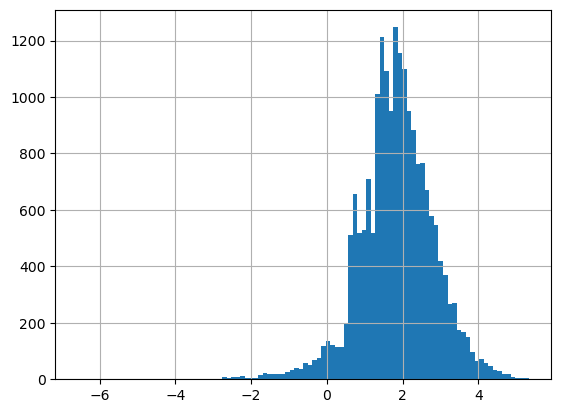

In [23]:
data[target_col].hist(bins=100)

In [28]:
y_pred, y_test = run_regression(data, target_col)

X_train: (16000, 50)
RMSE: 0.469866077957173
R2: 0.5178261281223758


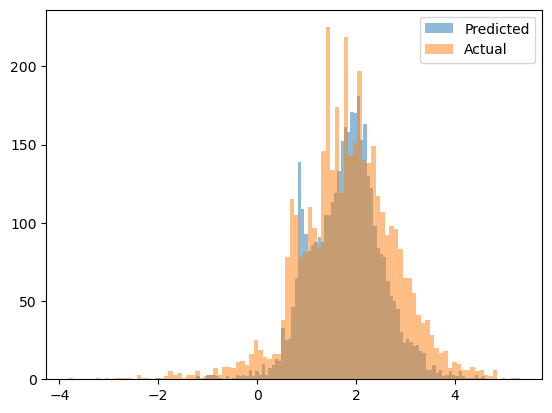

In [35]:
import matplotlib.pyplot as plt

# Plot the distribution of the data
plt.hist(y_pred, bins = 100, alpha = 0.5, label = 'Predicted')
plt.hist(y_test, bins = 100, alpha = 0.5, label = 'Actual')
plt.legend(loc = 'upper right')
plt.show()

## Diabetes

In [146]:
from sklearn.datasets import load_diabetes
normalize = True
threshold = 0.15
data_obj = load_diabetes(as_frame=True)
data = data_obj['frame']
data = data.dropna()
target_col = 'target'

# if normalize:
# 	data = normalization(data, target_col)

# # move target to the end of the dataframe
data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col]).abs().sort_values(ascending=False)
# # correlation
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'important_features': important_features,
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	'num_cols': data.shape[1] - 1,
	'task_type': 'regression',
}
correlation_ret

['bmi', 's5', 'bp', 's4', 's3', 's6', 's1', 'age', 's2']
(442, 11)
Average correlation: 0.34185669222980936 0.5864501344746884


target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441482
s4        0.430453
s3        0.394789
s6        0.382483
s1        0.212022
age       0.187889
s2        0.174054
sex       0.043062
dtype: float64

## California Housing

In [29]:
from sklearn.datasets import fetch_california_housing
normalize = True
threshold = 0.1
data_obj = fetch_california_housing(data_home = './data/california_housing', as_frame=True)
data = data_obj['frame']
sample_size = 1000
data = data.sample(sample_size, random_state=42)
data = data.dropna()
data
target_col = 'MedHouseVal'

if normalize:
	data = normalization(data, target_col)

# # move target to the end of the dataframe
data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col]).abs().sort_values(ascending=False)
# # correlation
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'important_features': important_features,
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	'num_cols': data.shape[1] - 1,
	'task_type': 'regression',
}
correlation_ret

['MedInc', 'AveRooms', 'AveOccup', 'Latitude']
(1000, 9)
Average correlation: 0.19750437151557662 0.6887874432146511


MedHouseVal    1.000000
MedInc         0.688787
AveRooms       0.263954
AveOccup       0.258307
Latitude       0.136581
HouseAge       0.099851
Longitude      0.063320
AveBedrms      0.037114
Population     0.032120
dtype: float64

## Housing

In [40]:
normalize = True
threshold = 0.2
data = pd.read_csv("./data/housing/housing.csv", delimiter='\s+', header=None)
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
# sample_size = 1000
# data = data.sample(sample_size, random_state=42)
data = data.dropna()
# data
target_col = '14'

if normalize:
	data = normalization(data, target_col)

# # # move target to the end of the dataframe
data = move_target_to_end(data, target_col)
data
correlation_ret = data.corrwith(data[target_col]).abs().sort_values(ascending=False)
# # # correlation
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'important_features': important_features,
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	'num_cols': data.shape[1] - 1,
	'task_type': 'regression',
}
correlation_ret

['13', '6', '11', '3', '10', '5', '1', '9', '7', '2', '12', '8']
(506, 14)
Average correlation: 0.42972090018211806 0.7376627261740144


14    1.000000
13    0.737663
6     0.695360
11    0.507787
3     0.483725
10    0.468536
5     0.427321
1     0.388305
9     0.381626
7     0.376955
2     0.360445
12    0.333461
8     0.249929
4     0.175260
dtype: float64

## Red Wine Regression

In [46]:
threshold = 0.15
data = pd.read_csv("./data/wine/winequality-red.csv", delimiter=';')

# data = data.drop(["id", "Unnamed: 32"], axis=1)
data = data.dropna()
#data['target'] = data.apply(lambda row: 0 if row['quality'] <= 5 else 1, axis=1)
#data = data.drop('quality', axis=1)

target_col = 'quality'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)

# print("Wine Red data loaded. Train size {}, Test size {}".format(train.shape, test.shape))
correlation_ret = data.corrwith(data[target_col]).abs().sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

['alcohol', 'volatile acidity', 'sulphates', 'citric acid', 'total sulfur dioxide', 'density']
(1599, 12)
6
Average correlation: 0.18905368265412123 0.4761663240011358
5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64


quality                 1.000000
alcohol                 0.476166
volatile acidity        0.390558
sulphates               0.251397
citric acid             0.226373
total sulfur dioxide    0.185100
density                 0.174919
chlorides               0.128907
fixed acidity           0.124052
pH                      0.057731
free sulfur dioxide     0.050656
residual sugar          0.013732
dtype: float64

## White Wine Regression

In [ ]:
threshold = 0.15
data = pd.read_csv("./data/wine/winequality-white.csv", delimiter=';')

# data = data.drop(["id", "Unnamed: 32"], axis=1)
data = data.dropna()
#data['target'] = data.apply(lambda row: 0 if row['quality'] <= 5 else 1, axis=1)
#data = data.drop('quality', axis=1)

target_col = 'quality'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)

# print("Wine Red data loaded. Train size {}, Test size {}".format(train.shape, test.shape))
correlation_ret = data.corrwith(data[target_col]).abs().sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)

# data_config = {
# 	'target': target_col,
# 	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
# 	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
# 	"num_cols": data.shape[1] - 1,
# 	'task_type': 'classification',
# 	'clf_type': 'binary-class'
# }

# if verbose:
# 	print("Data shape {} Test shape {}".format(data.shape))
# 	print(data_config)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

# Synthetic Data

In [61]:
from sklearn.datasets import make_blobs, make_circles, make_moons, make_classification, make_gaussian_quantiles, make_hastie_10_2
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3
import numpy as np
import matplotlib.pyplot as plt

## Gaussian

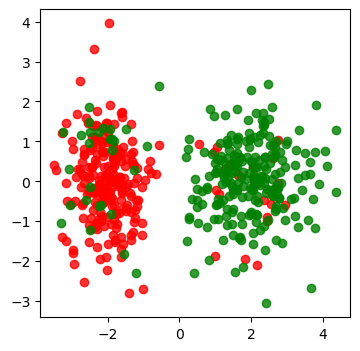

In [133]:
X, y = make_classification(
    n_samples=500, n_features=2, n_redundant=0, n_informative=1, random_state=1, flip_y=0.2,
    class_sep = 2, n_clusters_per_class=1) 

red = y == 0
green = y == 1
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(X[red, 0], X[red, 1], c="r", marker='o', alpha = 0.8)
ax.scatter(X[green, 0], X[green, 1], c="g", marker='o', alpha = 0.8)
plt.axis("tight")
plt.show()

## Circles

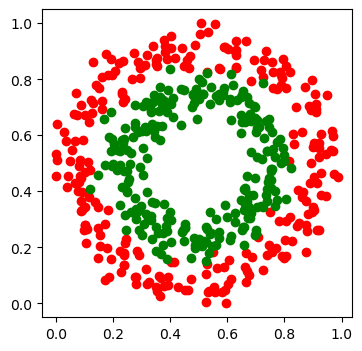

In [91]:
X, y = make_circles(n_samples=500, shuffle=True, noise=0.1, random_state=None, factor=0.6)
data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
data = pd.DataFrame(data)
X = (X - X.min())/(X.max() - X.min())
red = y == 0
green = y == 1
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
plt.axis("tight")
plt.show()

## Moon

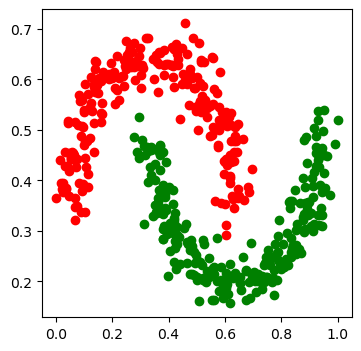

In [88]:
X, y = make_moons(n_samples=500, shuffle=True, noise=0.1, random_state=None)
X = (X - X.min())/(X.max() - X.min())
data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
data = pd.DataFrame(data)
red = y == 0
green = y == 1
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
plt.axis("tight")
plt.show()

## Ellipse

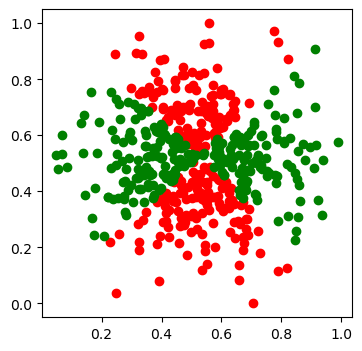

In [145]:
def gen_ellipse(n_samples, random_state=0):
    np.random.seed(random_state)
    x1 = np.random.normal(0, 1, n_samples)
    x2 = np.random.normal(0, 1, n_samples)
    y = x1**2 - x2**2
    X = np.array([x1, x2]).T
    y = np.where(y > 0, 1, 0)

    return X, y

X, y = gen_ellipse(500)
X = (X - X.min())/(X.max() - X.min())
red = y == 0
green = y == 1
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
plt.axis("tight")
plt.show()

## Regression